In [ ]:
import numpy as np 
import pandas as pd
from typing import Union, List
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, root_mean_squared_error, r2_score

# from src.preliminary_models import ConstraintBothRegression, ConstraintDeviationRegression, ConstraintGroupsMeanRegression, UpperBoundLossRegression

# K-means
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# New imports
import yaml

from time import sleep


import gurobipy
import mosek
import cvxpy as cp 
print(cp.installed_solvers())

# Linear regression
import os
import sys
folder_path = os.path.join(os.getcwd(), "2025_assessment_python")
sys.path.append(folder_path)
from recipes.recipes_pipelined import build_model_pipeline, build_model_pipeline_supress_onehot, ModelMainRecipe, ModelMainRecipeImputer


from src_.motivation_utils import compute_taxation_metrics

['CLARABEL', 'GUROBI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
# %pip install mosek
#!module avail pytorch
#!module load sloan/pytorch/1.1.0_cuda10.0
# !module --ignore_cache load sloan/dropbox/cli/2.0.8                       sloan/pytorch/1.1.0_cuda10.0
# !python -c "import torch; print(torch.__version__)"
%pip install dcor

Note: you may need to restart the kernel to use updated packages.


In [3]:
source = "CCAO" # "toy_data"




if source == "toy_data":
    # Toy dataset
    df = pd.read_csv("data/toy_data.csv")
    df.head()

    y = df["Price"]
    X = df.drop(columns=["Price"])

elif source == "House":
    # Kaggle House Pricing dataset
    df = pd.read_csv("data/Housing.csv")

    # Get dummies of categorial
    df = pd.get_dummies(df, drop_first=True)

    # Add a constant columns
    # df["intercept"] = 1

    display(df.head())

    y = df["price"]
    X = df.drop(columns=["price"])
elif source == "California":
    # Data from Google Colab samples
    df = pd.read_csv("data/california_housing_train.csv")
    # Add a constant columns
    # df["intercept"] = 1

    # Drop outliers at y.max() (too many to be true. Must be a threshold)
    df = df.loc[df["median_house_value"] < df["median_house_value"].max(),:]

    y = df["median_house_value"]
    X = df.drop(columns=["median_house_value"])

elif source == "CCAO":
    df = pd.read_parquet("../../data_county/2025/training_data.parquet", engine="fastparquet")#.sample(100000)
    df = df[
        (~df['ind_pin_is_multicard'].astype('bool').fillna(True)) &
        (~df['sv_is_outlier'].astype('bool').fillna(True))
    ]



In [4]:
# Get only the desired columns
with open('../params.yaml', 'r') as file:
    params = yaml.safe_load(file)

desired_columns = params['model']['predictor']['all'] +  ['meta_sale_price', 'meta_sale_date'] 
df = df.loc[:,desired_columns]


# Train - test split
df.sort_values(by="meta_sale_date", ascending=True, inplace=True)
n,m = df.shape
print("shape: ", (n,m))
train_prop = 0.822871 # exact match of 2022 // 2023+2024
df_train = df.iloc[:int(train_prop*n),:]
df_test = df.iloc[int(train_prop*n):,:]

# Random sample of train
sample_size = 100000
if sample_size < df_train.shape[0]:
    df_train = df_train.sample(min(sample_size, df_train.shape[0]), random_state=42, replace=False)
else:
    sample_size = df_train.shape[0]
df_train.sort_values(by="meta_sale_date", ascending=True, inplace=True)

# Train - val split
train_prop = 0.8622 # almost exact match of 2021 // 2022, for 10k sample
df_val = df_train.iloc[int(train_prop*sample_size):,:]
df_train = df_train.iloc[:int(train_prop*sample_size),:]
df_train['meta_sale_date']


# Create proper X,y 
X_train, y_train = df_train.drop(columns=['meta_sale_date', 'meta_sale_price']), df_train['meta_sale_price']
X_val, y_val = df_val.drop(columns=['meta_sale_date', 'meta_sale_price']), df_val['meta_sale_price']
X_test, y_test = df_test.drop(columns=['meta_sale_date', 'meta_sale_price']), df_test['meta_sale_price']

# Log version of the targets
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)


# Preprocessing pipeline (TO BE REVISED)
linear_pipeline = build_model_pipeline(
    pred_vars=params['model']['predictor']['all'],
    cat_vars=params['model']['predictor']['categorical'],
    id_vars=[],
)

# embeddings_pipeline = 
model_emb_pipeline = build_model_pipeline_supress_onehot( # WARNING: We only changed to this to perform changes on the pipeline
        pred_vars=params['model']['predictor']['all'],
        cat_vars=params['model']['predictor']['categorical'],
        id_vars=params['model']['predictor']['id']
    )

X_train = linear_pipeline.fit_transform(X_train, y_train_log)
X_val = linear_pipeline.transform(X_val)
X_test = linear_pipeline.transform(X_test)

X_train_emb = model_emb_pipeline.fit_transform(X_train, y_train_log)
X_val_emb = model_emb_pipeline.transform(X_val)
X_test_emb = model_emb_pipeline.transform(X_test)
X_train.head()

shape:  (381763, 97)


meta_township_code  meta_nbhd_code  meta_sale_count_past_n_years  \
386075           -0.125513        0.719475                           0.0   
156023            0.662379        0.191198                           0.0   
411374            2.250353        0.739907                           0.0   
332292           -0.301301       -0.246578                           0.0   
167435            0.342110       -0.277310                           0.0   

        char_yrblt  char_beds  char_bldg_sf  char_class  char_fbath  \
386075    1.701216        4.0      1.449297    1.721582         3.0   
156023   -0.107467        2.0     -1.326313   -1.453390         1.0   
411374    0.273309        3.0     -0.593242   -0.568340         1.0   
332292    0.336771        3.0     -0.625617   -0.302357         1.0   
167435    0.654084        2.0     -1.299283   -1.453390         1.0   

        char_frpl  char_hbath  ...  time_sale_quarter_of_year_Q1  \
386075        1.0         1.0  ...                           1.0   
156023        0.0         0.0  ...                           1.0   
411374        0.0         0.0  ...                           1.0   
332292        0.0         1.0  ...                           1.0   
167435        0.0         0.0  ...                           1.0   

        time_sale_quarter_of_year_Q2  time_sale_quarter_of_year_Q3  \
386075                           0.0                           0.0   
156023                           0.0                           0.0   
411374                           0.0                           0.0   
332292                           0.0                           0.0   
167435                           0.0                           0.0   

        time_sale_quarter_of_year_Q4  prox_nearest_vacant_land_dist_ft_1  \
386075                           0.0                           -0.809044   
156023                           0.0                            1.248703   
411374                           0.0                           -0.450348   
332292                           0.0                            0.366442   
167435                           0.0                            0.120777   

        prox_nearest_new_construction_dist_ft_1  \
386075                                 2.569407   
156023                                -0.521399   
411374                                 0.121326   
332292                                -0.190409   
167435                                -0.015688   

        acs5_percent_employment_unemployed_1  char_yrblt^2  char_bldg_sf^2  \
386075                             -0.019665      1.718343        1.450675   
156023                             -0.448002     -0.115575       -1.325127   
411374                             -0.234066      0.266115       -0.594080   
332292                              0.409420      0.329959       -0.626397   
167435                              0.233996      0.650151       -1.298198   

        char_land_sf^2  
386075        1.325147  
156023       -0.602154  
411374       -0.033783  
332292       -0.656657  
167435        0.668881  

[5 rows x 162 columns]

In [5]:


# m_ = FairnessConstrainedRidgeLog(alpha=0.01, rho=0, fit_intercept=True)
# m_.fit(X_train, y_train_log)
# y_pred_log = m_.predict(X_val)
# plt.scatter((y_val_log - np.mean(y_val_log))  ,y_pred_log/y_val_log)
# plt.show()
# plt.scatter((y_pred_log - np.mean(y_pred_log))  ,y_pred_log/y_val_log)
# plt.show()




Best Alpha found: 0.00100
Starting Path Search over 20 rho values...

--- Validation Results ---
        rho  val_mse_log  val_slope_log  val_cod_real
0    0.0000       0.1142        -0.0243       24.4148
1    5.2632       0.1150        -0.0201       24.4730
2   10.5263       0.1158        -0.0160       24.5335
3   15.7895       0.1166        -0.0122       24.6096
4   21.0526       0.1173        -0.0084       24.6693
5   26.3158       0.1181        -0.0048       24.7231
6   31.5789       0.1188        -0.0013       24.7784
7   36.8421       0.1196         0.0021       24.8394
8   42.1053       0.1203         0.0053       24.9034
9   47.3684       0.1210         0.0085       24.9766
10  52.6316       0.1217         0.0115       25.0381
11  57.8947       0.1224         0.0145       25.0945
12  63.1579       0.1231         0.0173       25.1553
13  68.4211       0.1237         0.0201       25.2111
14  73.6842       0.1244         0.0228       25.2660
15  78.9474       0.1250         0.0254

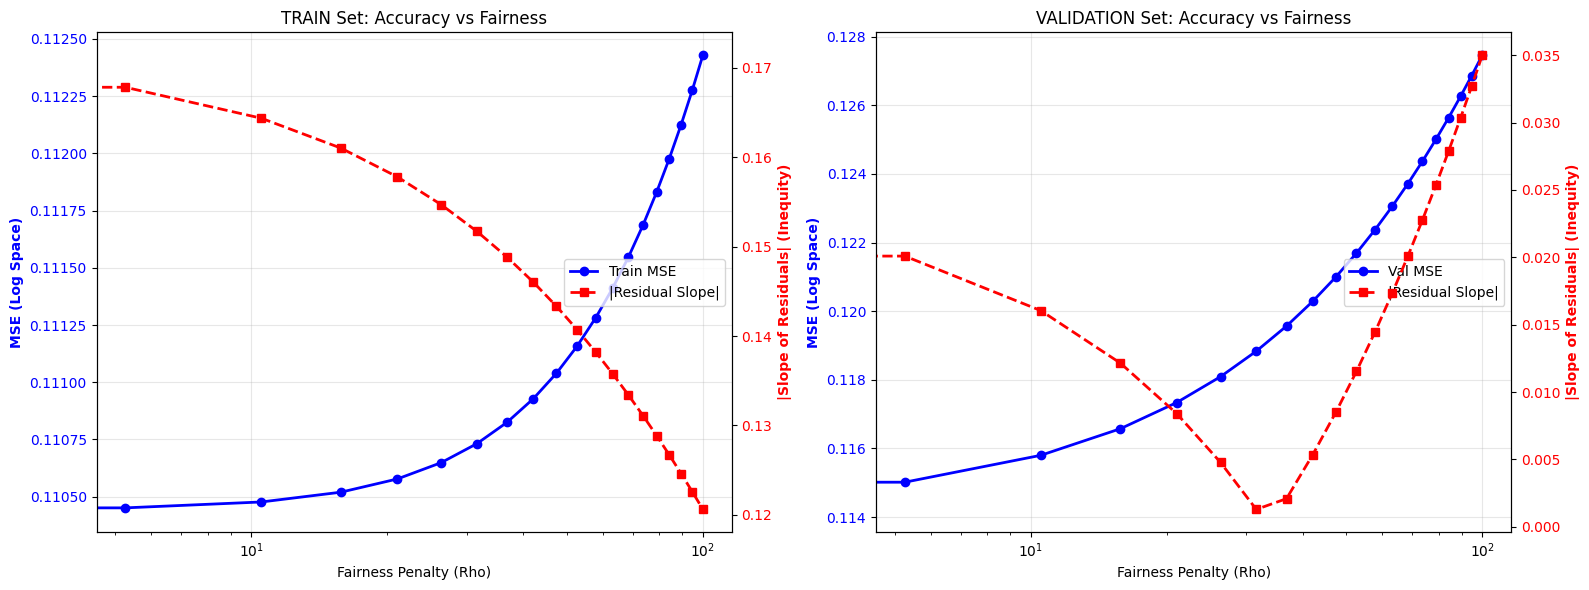

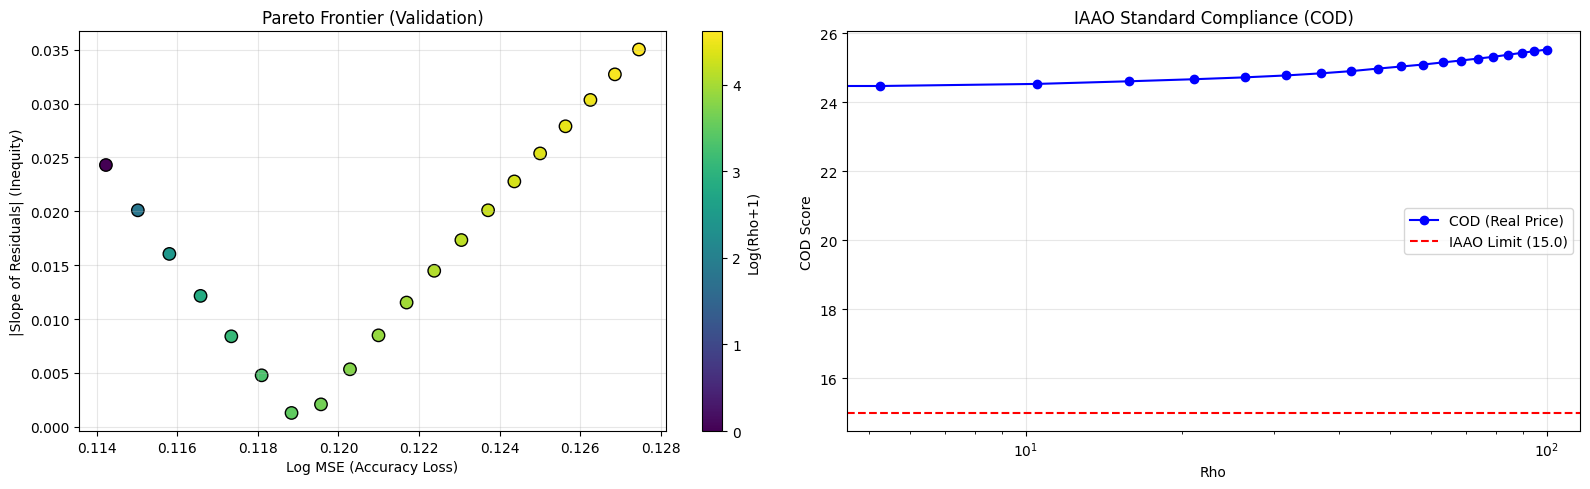


Generating Model Comparison Scatter Plots...


KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  # Required for the Lowess line
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import RidgeCV

# ==========================================
# 1. The Core Estimator (Log-Space Corrected)
# ==========================================
# class FairnessConstrainedRidgeLog(BaseEstimator, RegressorMixin):
#     """Ridge regression for log-price targets with a global covariance penalty.

#     We fit y = log(Price) with y_hat = X @ beta (+ intercept).

#     Objective (sklearn-style scaling):
#         (1/(2n)) * ||y - y_hat||^2
#         + (alpha/2) * ||beta||^2   (intercept not penalized)
#         + (rho/2) * c(beta)^2

#     Two penalty modes (choose via `mode`):

#       mode='diff'  (Case B: log-residual moment)
#         r_i = y_hat_i - y_i = log(P_hat/P)
#         c = Cov(r, y) = Cov(y_hat - y, y)
#         Hard-constraint limit (rho -> inf): Cov(y_hat, y) = Var(y)
#         => slope of simple regression of y_hat on y equals 1 (in log/log space).

#       mode='div'   (Case A: ratio-of-logs moment)
#         r_i = y_hat_i / y_i
#         c = Cov(r, y) = Cov(y_hat / y, y)
#         Hard-constraint limit (rho -> inf): Cov(y_hat / y, y) = 0.

#     Notes
#     -----
#     * This penalty is a GLOBAL moment (depends on all samples), but in the linear case
#       it induces a rank-1 correction to ridge, which we solve with Sherman–Morrison.
#     * The penalty enforces a zero covariance moment on the TRAINING set; out-of-sample
#       behavior depends on stability and distribution shift.
#     """

#     def __init__(self, alpha=1.0, rho=1.0, mode="diff", fit_intercept=True, eps_y=1e-12):
#         self.alpha = alpha
#         self.rho = rho
#         self.mode = mode  # 'diff' or 'div'
#         self.fit_intercept = fit_intercept
#         self.eps_y = eps_y

#     def fit(self, X, y):
#         X, y = check_X_y(X, y, accept_sparse=False, y_numeric=True)
#         n, d = X.shape

#         if self.mode not in ("diff", "div"):
#             raise ValueError("mode must be one of {'diff','div'}")

#         # ---- Augment for intercept (bias trick)
#         if self.fit_intercept:
#             X_aug = np.hstack([X, np.ones((n, 1), dtype=X.dtype)])
#             p = d + 1
#         else:
#             X_aug = X
#             p = d

#         # ---- sklearn-style scaling: MSE uses 1/n
#         XtX = (X_aug.T @ X_aug) / float(n)
#         Xty = (X_aug.T @ y) / float(n)

#         # ---- Ridge regularizer (do not penalize intercept)
#         I_reg = np.eye(p, dtype=X_aug.dtype)
#         if self.fit_intercept:
#             I_reg[-1, -1] = 0.0
#         A = XtX + (self.alpha * I_reg)

#         # ---- Build fairness vector u and RHS shift
#         y_mean = float(np.mean(y))
#         y_c = y - y_mean

#         if self.mode == "diff":
#             # u = (1/n) X^T (y - y_mean)
#             u = (X_aug.T @ y_c) / float(n)
#             # Numerical hygiene: in exact arithmetic, intercept component is 0.
#             if self.fit_intercept:
#                 u[-1] = 0.0
#             var_y = float(np.mean(y_c * y_c))
#             rhs = Xty + (self.rho * var_y) * u
#         else:
#             # u = (1/n) X^T ((y - y_mean) / y)
#             y_safe = np.where(np.abs(y) < self.eps_y, np.sign(y) * self.eps_y + (y == 0) * self.eps_y, y)
#             w = y_c / y_safe
#             u = (X_aug.T @ w) / float(n)
#             rhs = Xty  # no shift term in 'div'

#         u = u.reshape(-1, 1)
#         rhs = rhs.reshape(-1, 1)

#         # ---- Solve (A + rho u u^T) beta = rhs  via Sherman–Morrison
#         # If rho=0, this is standard ridge.
#         if float(self.rho) == 0.0:
#             beta = self._solve(A, rhs)
#         else:
#             beta0 = self._solve(A, rhs)         # A^{-1} rhs
#             Au = self._solve(A, u)              # A^{-1} u
#             denom = 1.0 + float(self.rho) * float(u.T @ Au)

#             # If denom is numerically problematic, fall back to direct solve.
#             if not np.isfinite(denom) or abs(denom) < 1e-15:
#                 LHS = A + float(self.rho) * (u @ u.T)
#                 beta = self._solve(LHS, rhs)
#             else:
#                 beta = beta0 - (float(self.rho) / denom) * (Au * float(u.T @ beta0))

#         coef_full = beta.ravel()

#         if self.fit_intercept:
#             self.coef_ = coef_full[:-1]
#             self.intercept_ = float(coef_full[-1])
#         else:
#             self.coef_ = coef_full
#             self.intercept_ = 0.0

#         # Optional: store training moment values (useful for debugging)
#         self.y_mean_ = y_mean
#         self._u_ = u.ravel()
#         self._n_features_in_ = d

#         return self

#     def predict(self, X):
#         check_is_fitted(self, ["coef_", "intercept_"])
#         X = check_array(X)
#         return X @ self.coef_ + self.intercept_

#     @staticmethod
#     def _solve(M, b):
#         """Solve M x = b with a robust fallback."""
#         try:
#             return np.linalg.solve(M, b)
#         except np.linalg.LinAlgError:
#             return np.linalg.lstsq(M, b, rcond=None)[0]

import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class FairnessConstrainedRidgeLog(BaseEstimator, RegressorMixin):
    """Ridge regression for log-price targets with a global covariance penalty,
    plus an optional separable (upper-bound) surrogate penalty.

    Objective (sklearn-style scaling):
        (1/(2n)) * ||y - y_hat||^2
        + (alpha/2) * ||beta||^2   (intercept not penalized)
        + (rho/2) * c(beta)^2
        + (rho_sep/2) * s(beta)

    Global covariance moment (same as before):
        c(beta) = (1/n) * sum_i r_i * y_c,i

      mode='diff': r_i = y_hat_i - y_i     (target 0)
      mode='div' : r_i = y_hat_i / y_i^safe (target 1)

    Separable surrogate (Jensen upper bound on c^2), but centered at the right target:
        define r_tilde_i = r_i - t, where t=0 for diff and t=1 for div
        s(beta) := (1/n) * sum_i (r_tilde_i * y_c,i)^2
    """

    def __init__(
        self,
        alpha=1.0,
        rho=1.0,
        rho_sep=0.0,          # coefficient for separable surrogate
        mode="diff",
        fit_intercept=True,
        eps_y=1e-12
    ):
        self.alpha = alpha
        self.rho = rho
        self.rho_sep = rho_sep
        self.mode = mode
        self.fit_intercept = fit_intercept
        self.eps_y = eps_y

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False, y_numeric=True)
        n, d = X.shape

        if self.mode not in ("diff", "div"):
            raise ValueError("mode must be one of {'diff','div'}")
        if float(self.rho) < 0 or float(self.rho_sep) < 0:
            raise ValueError("rho and rho_sep must be >= 0")

        # ---- Augment for intercept
        if self.fit_intercept:
            X_aug = np.hstack([X, np.ones((n, 1), dtype=X.dtype)])
            p = d + 1
        else:
            X_aug = X
            p = d

        # ---- Base quadratic pieces
        XtX = (X_aug.T @ X_aug) / float(n)
        Xty = (X_aug.T @ y) / float(n)

        I_reg = np.eye(p, dtype=float)
        if self.fit_intercept:
            I_reg[-1, -1] = 0.0

        A = XtX + (float(self.alpha) * I_reg)
        rhs = Xty.copy()

        # ---- Centered y
        y_mean = float(np.mean(y))
        y_c = y - y_mean
        var_y = float(np.mean(y_c * y_c))

        # ==========================================================
        # A) Separable surrogate term (CENTERED at correct target)
        #     s(beta) = (1/n) sum_i ( (r_i - t) * y_c,i )^2
        # ==========================================================
        rho_s = float(self.rho_sep)
        if rho_s > 0.0:
            if self.mode == "diff":
                # r_tilde = (Xb - y) - 0 = Xb - y
                # s = (1/n)||diag(y_c)(Xb - y)||^2
                d2 = (y_c ** 2).astype(float)
                Xw = X_aug * d2[:, None]
                A += rho_s * (X_aug.T @ Xw) / float(n)
                rhs += rho_s * (X_aug.T @ (d2 * y)) / float(n)

            else:
                # mode == "div"
                # r = (Xb)/y_safe, target t=1 => r_tilde = (Xb)/y_safe - 1 = (Xb - y_safe)/y_safe
                # s = (1/n) sum (y_c^2 / y_safe^2) * (Xb - y_safe)^2
                y_safe = self._safe_y(y)
                d2 = (y_c ** 2) / (y_safe ** 2)
                Xw = X_aug * d2[:, None]
                A += rho_s * (X_aug.T @ Xw) / float(n)
                rhs += rho_s * (X_aug.T @ (d2 * y_safe)) / float(n)

        # ==========================================================
        # B) Global covariance penalty (unchanged; shift doesn't matter)
        # ==========================================================
        rho_g = float(self.rho)
        if rho_g > 0.0:
            if self.mode == "diff":
                # c = mean((Xb - y)*y_c) = u^T b - var_y
                u = (X_aug.T @ y_c) / float(n)
                if self.fit_intercept:
                    u[-1] = 0.0
                rhs = rhs + (rho_g * var_y) * u
            else:
                # c = mean(((Xb)/y_safe)*y_c) = u^T b
                y_safe = self._safe_y(y)
                w = y_c / y_safe
                u = (X_aug.T @ w) / float(n)

            u = u.reshape(-1, 1)
            rhs_vec = rhs.reshape(-1, 1)

            beta0 = self._solve(A, rhs_vec)
            Au = self._solve(A, u)
            denom = 1.0 + rho_g * float((u.T @ Au).item())

            if (not np.isfinite(denom)) or abs(denom) < 1e-15:
                LHS = A + rho_g * (u @ u.T)
                beta = self._solve(LHS, rhs_vec)
            else:
                beta = beta0 - (rho_g / denom) * (Au * float((u.T @ beta0).item()))
            beta = beta.ravel()

        else:
            beta = self._solve(A, rhs.reshape(-1, 1)).ravel()
            u = None

        # ---- unpack
        if self.fit_intercept:
            self.coef_ = beta[:-1]
            self.intercept_ = float(beta[-1])
        else:
            self.coef_ = beta
            self.intercept_ = 0.0

        # ---- diagnostics (train moments)
        y_hat = X_aug @ beta
        if self.mode == "diff":
            r = y_hat - y
            r_tilde = r  # target 0
        else:
            y_safe = self._safe_y(y)
            r = y_hat / y_safe
            r_tilde = r - 1.0  # target 1

        a = r * y_c              # for covariance moment (same as (r-1)*y_c)
        a_tilde = r_tilde * y_c  # for separable surrogate

        self.cov_moment_ = float(np.mean(a))
        self.cov_moment_sq_ = float(self.cov_moment_ ** 2)
        self.sep_surrogate_ = float(np.mean(a_tilde ** 2))  # (1/n) sum ( (r-t)*y_c )^2

        self.y_mean_ = y_mean
        self._u_ = None if u is None else u.ravel()
        self._n_features_in_ = d

        return self

    def predict(self, X):
        check_is_fitted(self, ["coef_", "intercept_"])
        X = check_array(X)
        return X @ self.coef_ + self.intercept_

    def _safe_y(self, y):
        y = np.asarray(y, dtype=float)
        eps = float(self.eps_y)
        y_safe = y.copy()
        mask = np.abs(y_safe) < eps
        if np.any(mask):
            y_safe[mask] = np.where(y_safe[mask] >= 0.0, eps, -eps)
        return y_safe

    @staticmethod
    def _solve(M, b):
        try:
            return np.linalg.solve(M, b)
        except np.linalg.LinAlgError:
            return np.linalg.lstsq(M, b, rcond=None)[0]


# ==========================================
# 2. The Path Searcher (Metrics & Loop)
# ==========================================
class FairnessPathSearch:
    """
    Loops over rho values, fits the model, and calculates comprehensive metrics.
    """
    
    def __init__(self, estimator_class, rhos, alpha=1.0, fit_intercept=True, mode=None):
        self.estimator_class = estimator_class
        self.rhos = rhos
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.path_results_ = None
        self.mode = mode,
        self.models_ = {}

    def _compute_metrics(self, y_true_log, y_pred_log, prefix):
        metrics = {}
        
        # --- Log Space Metrics ---
        resid_log = y_pred_log - y_true_log
        metrics[f'{prefix}_mse_log'] = np.mean(resid_log**2)
        
        # Slope of Residuals vs Price (Vertical Equity Proxy)
        if np.std(y_true_log) > 1e-9:
            slope = np.polyfit(y_true_log, resid_log, 1)[0]
            cov = np.cov(resid_log, y_true_log)[0, 1]
            corr = np.corrcoef(resid_log, y_true_log)[0, 1]
        else:
            slope, cov, corr = 0.0, 0.0, 0.0
            
        metrics[f'{prefix}_slope_log'] = slope
        metrics[f'{prefix}_cov_resid_log'] = cov
        metrics[f'{prefix}_corr_resid_log'] = corr
        
        # --- Real Price Space Metrics ---
        y_true = np.exp(y_true_log)
        y_pred = np.exp(y_pred_log)
        
        # COD (IAAO Standard)
        ratios = y_pred / y_true
        median_ratio = np.median(ratios)
        avg_abs_dev = np.mean(np.abs(ratios - median_ratio))
        cod = (avg_abs_dev / median_ratio) * 100
        
        metrics[f'{prefix}_cod_real'] = cod
        metrics[f'{prefix}_mape_real'] = np.mean(np.abs((y_pred - y_true) / y_true))
        
        return metrics

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        results = []
        print(f"Starting Path Search over {len(self.rhos)} rho values...")
        
        for rho in self.rhos:
            model = self.estimator_class(
                alpha=self.alpha, 
                rho=rho, 
                fit_intercept=self.fit_intercept,
                mode=self.mode[0],
            )
            model.fit(X_train, y_train)
            self.models_[rho] = model
            
            row = {'rho': rho}
            
            # Train Stats
            y_pred_train = model.predict(X_train)
            row.update(self._compute_metrics(y_train, y_pred_train, 'train'))
            
            # Val Stats
            if X_val is not None and y_val is not None:
                y_pred_val = model.predict(X_val)
                row.update(self._compute_metrics(y_val, y_pred_val, 'val'))
            
            row['L2_norm'] = np.sum(model.coef_**2)
            results.append(row)
            
        self.path_results_ = pd.DataFrame(results)
        return self

# ==========================================
# 3. Execution & ALL Plots
# ==========================================
if __name__ == "__main__":
    # # --- A. Generate Synthetic Log-Normal Data ---
    # np.random.seed(42)
    # N = 1000
    # X = np.random.rand(N, 5) 
    
    # # Truth: Biased structure
    # true_log_price = 11.0 + 2.0 * X[:, 0] + 0.5 * X[:, 1]
    # y_log = true_log_price + np.random.normal(0, 0.3, N)

    # # Split
    # split = int(0.8 * N)
    # X_train, y_train_log = X[:split], y_log[:split]
    # X_val, y_val_log = X[split:], y_log[split:]

    # --- B. Find Best Alpha & Run Search ---
    rcv = RidgeCV(alphas=np.logspace(-3, 2, 20)).fit(X_train, y_train_log)
    best_alpha = rcv.alpha_
    print(f"Best Alpha found: {best_alpha:.5f}")

    rhos_to_search = np.linspace(0, 1e2, 20)#[0, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
    # rhos_to_search = np.logspace(-3, 2, 20)

    searcher = FairnessPathSearch(
        estimator_class=FairnessConstrainedRidgeLog,
        rhos=rhos_to_search,
        alpha=best_alpha,
        fit_intercept=True,
        mode="div",
    )
    searcher.fit(X_train, y_train_log, X_val=X_val, y_val=y_val_log)
    df = searcher.path_results_

    # --- C. Print Table ---
    print("\n--- Validation Results ---")
    print(df[['rho', 'val_mse_log', 'val_slope_log', 'val_cod_real']].to_string(float_format="%.4f"))

    # =======================================================
    # PLOT SET 1: Evolution of Metrics (Blue=MSE, Red=Slope)
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Subplot 1: TRAIN ---
    ax_train = axes[0]
    ln1 = ax_train.semilogx(df['rho'], df['train_mse_log'], 'b-o', lw=2, label='Train MSE')
    ax_train.set_xlabel('Fairness Penalty (Rho)')
    ax_train.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_train.tick_params(axis='y', labelcolor='b')
    ax_train.set_title('TRAIN Set: Accuracy vs Fairness')
    ax_train.grid(True, alpha=0.3)

    ax_train_twin = ax_train.twinx()
    ln2 = ax_train_twin.semilogx(df['rho'], df['train_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_train_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_train_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax_train.legend(lns, labs, loc='center right')

    # --- Subplot 2: VALIDATION ---
    ax_val = axes[1]
    ln3 = ax_val.semilogx(df['rho'], df['val_mse_log'], 'b-o', lw=2, label='Val MSE')
    ax_val.set_xlabel('Fairness Penalty (Rho)')
    ax_val.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_val.tick_params(axis='y', labelcolor='b')
    ax_val.set_title('VALIDATION Set: Accuracy vs Fairness')
    ax_val.grid(True, alpha=0.3)

    ax_val_twin = ax_val.twinx()
    ln4 = ax_val_twin.semilogx(df['rho'], df['val_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_val_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_val_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns2 = ln3 + ln4
    labs2 = [l.get_label() for l in lns2]
    ax_val.legend(lns2, labs2, loc='center right')

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 2: Pareto Frontier & COD
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Trade-off (MSE vs Slope)
    sc = axes[0].scatter(
        df['val_mse_log'], 
        df['val_slope_log'].abs(), 
        c=np.log1p(df['rho']), cmap='viridis', s=80, edgecolors='k'
    )
    plt.colorbar(sc, ax=axes[0], label='Log(Rho+1)')
    axes[0].set_xlabel('Log MSE (Accuracy Loss)')
    axes[0].set_ylabel('|Slope of Residuals| (Inequity)')
    axes[0].set_title('Pareto Frontier (Validation)')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Real Price Metrics (COD vs Rho)
    axes[1].semilogx(df['rho'], df['val_cod_real'], 'b-o', label='COD (Real Price)')
    axes[1].axhline(15.0, color='red', linestyle='--', label='IAAO Limit (15.0)')
    # axes[1].axhline(5.0, color='green', linestyle='--', label='IAAO Lower Limit (5.0)')
    axes[1].set_xlabel('Rho')
    axes[1].set_ylabel('COD Score')
    axes[1].set_title('IAAO Standard Compliance (COD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 3: Model Comparison Scatters (Lowess)
    # =======================================================
    print("\nGenerating Model Comparison Scatter Plots...")

    models_to_plot = [
        FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0, fit_intercept=True, mode="div"),
        FairnessConstrainedRidgeLog(alpha=best_alpha, rho=20, fit_intercept=True, mode="div"),
    ]


    # --- 1. Robust K-Means Clustering Setup ---
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    # A. Prepare data: Stack X and Y into a matrix
    # X_cluster = np.column_stack((y_val_log, ratios))

    # B. Standardize: Essential so 'Log Value' doesn't dominate 'Ratio' due to scale differences
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_scaled_val = scaler.fit_transform(X_val)

    # C. Robust K-Means: 
    # n_init=50 runs the algo 50 times with different seeds and picks the best inertia 
    # (This satisfies "multiple runs and majority result" logic mathematically)
    K_CLUSTERS = 3  # You can adjust this number
    kmeans = KMeans(n_clusters=K_CLUSTERS, init='k-means++', n_init=50, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    cluster_labels = kmeans.predict(X_scaled_val)
    # --- 1. Robust K-Means Clustering Setup ---


    for model_ in models_to_plot:
        # 1. Fit & Predict
        model_.fit(X_train, y_train_log)
        y_pred_log = model_.predict(X_val)
        
        # Transform to Real Money for Ratio Calculation
        y_pred_money = np.exp(y_pred_log)
        y_val_money = np.exp(y_val_log)
        ratios = y_pred_money / y_val_money

        # 2. Setup Plot
        plt.figure(figsize=(6, 4))
        
        # Scatter points
        plt.scatter(y_val_log, ratios, 
            facecolors='none', 
            edgecolors='black', 
            s=50, 
            alpha=0.4,
            label='Properties'
        )
        
        # --- Gray Grid Lines ---
        plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

        # --- Reference Line (Perfect Equity) ---
        plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

        # --- Tendency Line (Lowess Smoothing) ---
        lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
        plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')
        
        # --- Linear Trend (Slope Check) ---
        z = np.polyfit(y_val_log, ratios, 1)
        p = np.poly1d(z)
        plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

        # Formatting
        plt.ylabel("Assessment Ratio (AV / MV)")
        plt.xlabel("Log Market Value")
        plt.title(f"Vertical Equity Check\nrho={model_.rho:.1f} | Lowess should be flat")
        plt.legend(loc='upper right')
        plt.ylim(0, 3) 
        plt.show()

        display(compute_taxation_metrics(y_val_log, y_pred_log, scale="log"))








        # --- 2. Setup Plot (Mirroring your workflow) ---
        plt.figure(figsize=(6, 4))

        # Scatter points (Colored by Cluster)
        # We use a colormap (viridis) and map 'c' to the labels
        scatter = plt.scatter(y_val_log, ratios, 
                    c=cluster_labels, 
                    cmap='viridis', 
                    edgecolors='black', 
                    linewidth=0.5,
                    s=50, 
                    alpha=0.6, # Slightly more opaque to see colors
                    label='Clustered Properties'
        )

        # --- Gray Grid Lines ---
        plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

        # --- Reference Line (Perfect Equity) ---
        plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

        # --- Tendency Line (Lowess Smoothing on ALL data) ---
        # We still calculate this on the whole dataset to see the global trend
        lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
        plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')

        # --- Linear Trend (Slope Check on ALL data) ---
        z = np.polyfit(y_val_log, ratios, 1)
        p = np.poly1d(z)
        plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

        # Formatting
        plt.ylabel("Assessment Ratio (AV / MV)")
        plt.xlabel("Log Market Value")
        plt.title(f"Vertical Equity (k={K_CLUSTERS} Clusters)\nrho={model_.rho:.1f} | Colored by Robust K-Means")

        # Legend Handling
        # We want the lines, but we also might want a legend for the clusters. 
        # This gathers the lines + the scatter handle
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, loc='upper right')

        plt.ylim(0, 3) 
        plt.show()

        display(compute_taxation_metrics(y_val_log, y_pred_log, scale="log"))


Generating Model Comparison Scatter Plots...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


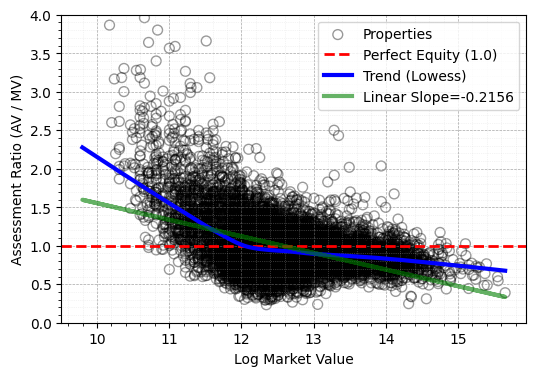

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


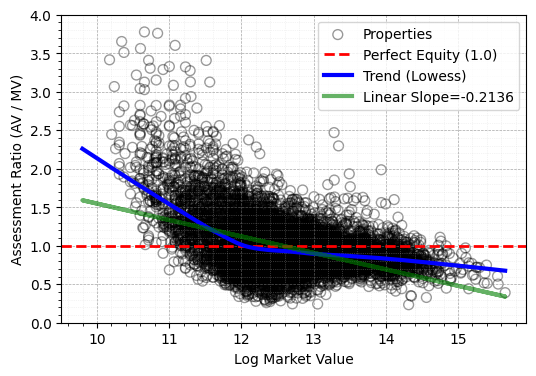

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


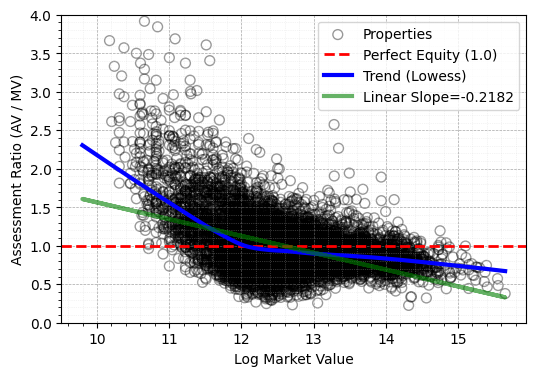

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


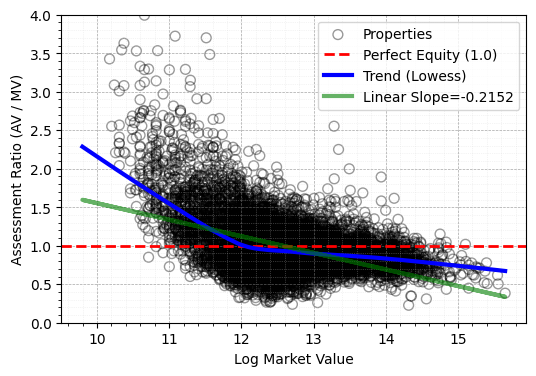

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


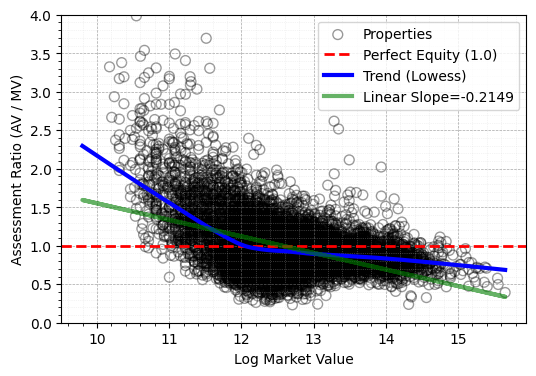

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


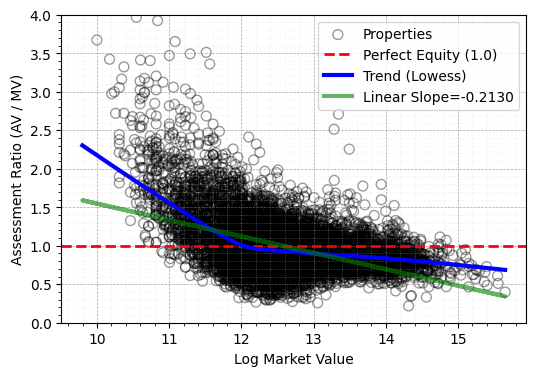

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


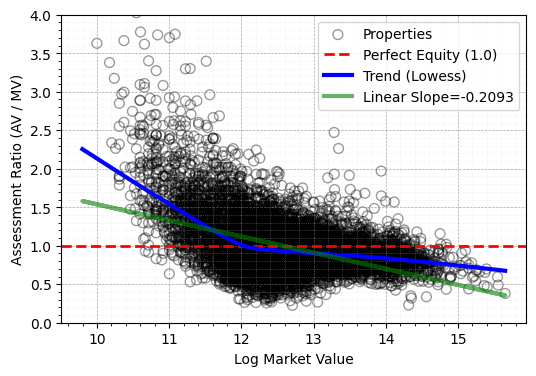

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


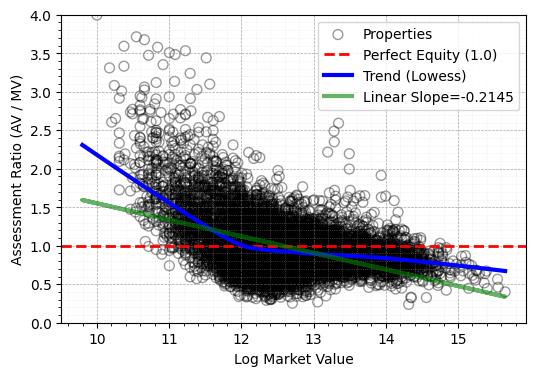

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614


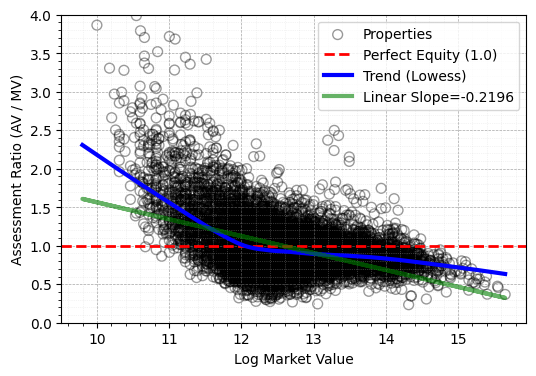

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16295
[LightGBM] [Info] Number of data points in the train set: 86220, number of used features: 150
[LightGBM] [Info] Start training from score 12.397614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


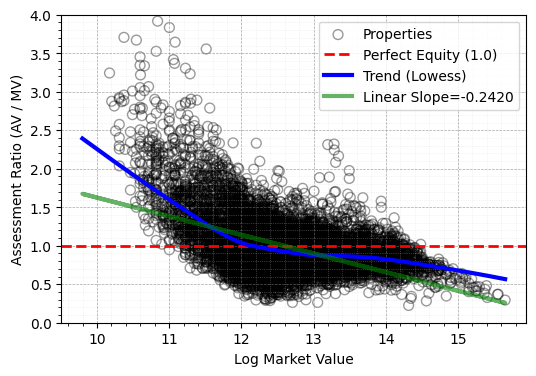

R2  R2 (log)           RMSE           MAE      MAPE      MdAPE  \
0  0.909891  0.889512   89969.810895  51952.135019  0.204705  14.143323   
1  0.909649  0.889548   90090.939527  52077.749085  0.204730  14.131184   
2  0.909524  0.889591   90153.100906  51952.708229  0.204674  14.164362   
3  0.910035  0.889402   89898.304357  52001.688345  0.204789  14.134115   
4  0.910836  0.889244   89497.125107  52042.672004  0.204998  14.218953   
5  0.911045  0.889268   89392.077438  51867.059441  0.204825  14.126756   
6  0.907919  0.888180   90948.964706  52052.007644  0.205565  14.116611   
7  0.903279  0.884646   93212.389842  52462.216466  0.208095  14.188944   
8  0.892600  0.876920   98223.715374  53780.375920  0.214360  14.433531   
9  0.864429  0.866082  110356.268967  56633.813038  0.224007  14.930608   

   Corr(r,price)  Corr(r,logprice)  Slope(r~logy)  Var ratio  Median ratio  \
0      -0.226170         -0.418747      -0.163180   0.098193      0.981212   
1      -0.226281         -0.417363      -0.163055   0.098693      0.980845   
2      -0.225609         -0.417546      -0.163082   0.098640      0.981556   
3      -0.226158         -0.417854      -0.163164   0.098593      0.981106   
4      -0.225369         -0.417313      -0.163517   0.099277      0.981026   
5      -0.225352         -0.418305      -0.163468   0.098748      0.981471   
6      -0.224637         -0.416254      -0.164997   0.101597      0.981339   
7      -0.223333         -0.415794      -0.170151   0.108283      0.981908   
8      -0.227370         -0.422790      -0.181649   0.119361      0.981308   
9      -0.237732         -0.434021      -0.198021   0.134601      0.981770   

   Mean ratio  W. Mean ratio        COD  COV_IAAO        VEI       PRD  \
0    1.038115       0.973232  20.789049  0.301854 -29.580817  1.066667   
1    1.038153       0.973073  20.796591  0.302611 -29.512018  1.066881   
2    1.038131       0.973262  20.777511  0.302536 -29.055258  1.066651   
3    1.038181       0.973170  20.799641  0.302449 -29.662518  1.066804   
4    1.038270       0.973261  20.820007  0.303470 -29.282070  1.066795   
5    1.038235       0.973404  20.797679  0.302671 -29.195792  1.066602   
6    1.038701       0.973151  20.876805  0.306869 -29.382173  1.067359   
7    1.039934       0.972654  21.123265  0.316430 -29.922517  1.069172   
8    1.042944       0.971029  21.772647  0.331263 -30.387388  1.074060   
9    1.047042       0.967194  22.751233  0.350399 -31.172701  1.082557   

        PRB       MKI  
0 -0.076779  0.935466  
1 -0.076540  0.934883  
2 -0.076567  0.935429  
3 -0.076616  0.935120  
4 -0.076703  0.935227  
5 -0.076780  0.935690  
6 -0.077207  0.935160  
7 -0.079143  0.934277  
8 -0.084182  0.930221  
9 -0.091680  0.921230

R2  R2 (log)           RMSE           MAE      MAPE      MdAPE  \
0  0.851649  0.827370  138859.380734  75145.383750  0.212130  16.742079   
1  0.852770  0.828488  138333.611631  74966.629288  0.211304  16.736881   
2  0.851344  0.829191  139001.889122  74847.257151  0.211856  16.742196   
3  0.853269  0.827808  138098.977654  74862.773174  0.211865  16.774164   
4  0.852390  0.828053  138512.165876  74935.082881  0.211605  16.742903   
5  0.854487  0.829013  137524.599480  74765.725530  0.211348  16.649434   
6  0.851464  0.828941  138946.092362  74420.542666  0.210226  16.356910   
7  0.847598  0.828932  140742.552969  75212.211677  0.212027  16.737636   
8  0.831913  0.827615  147807.721307  76412.574673  0.212957  16.898320   
9  0.793035  0.819776  164013.154768  80119.929152  0.218863  17.348108   

   Corr(r,price)  Corr(r,logprice)  Slope(r~logy)  Var ratio  Median ratio  \
0      -0.266602         -0.469027      -0.215598   0.100675      0.919793   
1      -0.266654         -0.468069      -0.213607   0.099229      0.918796   
2      -0.269060         -0.472931      -0.218246   0.101467      0.920937   
3      -0.265207         -0.467433      -0.215206   0.100995      0.919935   
4      -0.263556         -0.467092      -0.214882   0.100838      0.919562   
5      -0.262516         -0.465271      -0.213012   0.099867      0.919513   
6      -0.262490         -0.458638      -0.209263   0.099191      0.923600   
7      -0.263620         -0.467238      -0.214531   0.100446      0.919500   
8      -0.271964         -0.473896      -0.219640   0.102350      0.919201   
9      -0.296083         -0.504146      -0.242021   0.109805      0.916858   

   Mean ratio  W. Mean ratio        COD  COV_IAAO        VEI       PRD  \
0    0.977076       0.902157  21.611043  0.324750 -32.356808  1.083044   
1    0.976823       0.902429  21.529279  0.322493 -32.416073  1.082437   
2    0.979981       0.904074  21.622816  0.325058 -32.969016  1.083961   
3    0.977664       0.903018  21.608861  0.325069 -32.895074  1.082662   
4    0.976831       0.902708  21.548318  0.325093 -31.685756  1.082112   
5    0.977659       0.904185  21.547253  0.323251 -29.463007  1.081260   
6    0.978673       0.905455  21.400721  0.321821 -29.228542  1.080863   
7    0.977211       0.903215  21.585490  0.324335 -31.014033  1.081926   
8    0.977195       0.900136  21.689007  0.327399 -33.417951  1.085608   
9    0.978505       0.891611  22.354596  0.338659 -35.121215  1.097458   

        PRB       MKI  
0 -0.105697  0.884243  
1 -0.104795  0.885073  
2 -0.107774  0.883318  
3 -0.105147  0.885455  
4 -0.105069  0.886512  
5 -0.103767  0.887969  
6 -0.100122  0.887471  
7 -0.104835  0.888259  
8 -0.108990  0.882297  
9 -0.126703  0.862562

In [ ]:
# =======================================================
# PLOT SET 3: Model Comparison Scatters (Lowess) + cluster tests
# =======================================================
print("\nGenerating Model Comparison Scatter Plots...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from fairness_models.boosting_fairness_models import LGBCovPenalty, LGBSmoothPenalty
import lightgbm as lgb


# Inputs
random_state = 42
n_jobs =190
max_iter=200#500 #0

fit_intercept = True
l1,l2 = 1e-3, 1e-2
max_depth = 15
lr = 1e-1


lgbm_params = {
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "max_depth": max_depth,
    # "num_leaves":  2**(max_depth)//8, # must be at most 2^max_depth 
    "learning_rate": lr,
    "n_estimators": max_iter,
    "subsample_for_bin": 200000,
    "objective": "mse", # To be updated inside
    "class_weight": None,
    "min_child_samples": 30,
    "colsample_bytree": 1.0,
    "reg_alpha": l1,
    "reg_lambda": l2,
    "random_state": random_state,
    "n_jobs": 1,#n_jobs,
    "importance_type": "split",
    # "verbose":-2,
    # "verbosity":-2,
    # "verbose_eval":False,
    # "verbosity_eval":False,
}


models_to_plot = [
    # lgb.LGBMRegressor(**lgbm_params),
    # LGBCovPenalty(rho=1082.0, ratio_mode="div", zero_grad_tol=1e-12, eps_y=1e-12, lgbm_params=lgbm_params),
   
   
    # LGBSmoothPenalty(rho=2.043, ratio_mode="diff", zero_grad_tol=1e-12, eps_y=1e-12, lgbm_params=lgbm_params),
    # LGBCovPenalty(rho=1e4, ratio_mode="div", zero_grad_tol=1e-12, eps_y=1e-12, lgbm_params=lgbm_params),

    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0 , rho_sep=0, fit_intercept=True, mode="div"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=20, rho_sep=0, fit_intercept=True, mode="div"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0 , rho_sep=20, fit_intercept=True, mode="div"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=10, rho_sep=10, fit_intercept=True, mode="div"),
]

l1_values = np.logspace(-3, 2, 10)
for l1 in l1_values:
# for l1 in np.linspace(1e-3, 0.5, 10):
    lgbm_params["reg_alpha"] = l1
    models_to_plot.append(
        lgb.LGBMRegressor(**lgbm_params)
    )

# model_names = ["Baseline LightGBM", "Covariance-Penalized LightGBM"]
results = []
results_train = []
for index_,model_ in enumerate(models_to_plot):
    # 1. Fit & Predict
    model_.fit(X_train, y_train_log)
    y_pred_log_train = model_.predict(X_train) 
    y_pred_log = model_.predict(X_val)
    
    # Transform to Real Money for Ratio Calculation
    y_pred_money = np.exp(y_pred_log)
    y_val_money = np.exp(y_val_log)
    ratios = y_pred_money / y_val_money

    # 2. Setup Plot
    plt.figure(figsize=(6, 4))
    
    # Scatter points
    plt.scatter(y_val_log, ratios, 
        facecolors='none', 
        edgecolors='black', 
        s=50, 
        alpha=0.4,
        label='Properties'
    )
    
    # --- Gray Grid Lines ---
    plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

    # --- Reference Line (Perfect Equity) ---
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

    # --- Tendency Line (Lowess Smoothing) ---
    lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
    plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')
    
    # --- Linear Trend (Slope Check) ---
    z = np.polyfit(y_val_log, ratios, 1)
    p = np.poly1d(z)
    plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=3, label=f'Linear Slope={z[0]:.4f}')

    # Formatting
    plt.ylabel("Assessment Ratio (AV / MV)")
    plt.xlabel("Log Market Value")
    # plt.title(f"Vertical Equity Check | Lowess should be flat") # | rho_sep={model_.rho_sep:.1f}
    # plt.title(f"{model_names[index_]}")
    # plt.title(f"LGBM (l1={})")
    plt.legend(loc='upper right')
    plt.ylim(0, 4) 
    # plt.savefig(f"../temp/slides/{model_names[index_]}_motivation.pdf", dpi=300)
    plt.show()

    tax_metrics_train = compute_taxation_metrics(y_train_log, y_pred_log_train, scale="log") 
    results_train.append(tax_metrics_train)
    tax_metrics = compute_taxation_metrics(y_val_log, y_pred_log, scale="log") 
    results.append(tax_metrics)

display(pd.DataFrame(results_train))
display(pd.DataFrame(results))




# # --- 1) Robust K-Means clustering on X (train-fitted scaler + train-fitted kmeans) ---
# K_CLUSTERS = 3
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled   = scaler.transform(X_val)   # IMPORTANT: do NOT fit on val

# kmeans = KMeans(n_clusters=K_CLUSTERS, n_init=50, random_state=42)
# train_clusters = kmeans.fit_predict(X_train_scaled)
# val_clusters   = kmeans.predict(X_val_scaled)

In [15]:
# for i,l1 in enumerate(np.linspace(1e-3, 0.5, 10)):
    # print(i, l1)
l1_values = np.logspace(-3, 2, 10)
l1_values

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

In [9]:
pred_vars = [col for col in params['model']['predictor']['all'] if col in X_train_emb.columns] 
large_categories = ['meta_nbhd_code', 'meta_township_code', 'char_class'] + [c for c in pred_vars if c.startswith('loc_school_')]
coord_vars = ["loc_longitude", "loc_latitude"]

cat_cols = params['model']['predictor']['categorical']

cat_cols_new = []
for col in X_train.columns:
    for col_sw in cat_cols:
        if col.startswith(col_sw):
            cat_cols_new.append(col)


num_cols = []
for col in X_train.columns:
    if col not in cat_cols_new:
        num_cols.append(col)
X_train[cat_cols_new].head()

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols_new]
X_val_num = X_val[num_cols]
X_val_cat = X_val[cat_cols_new]

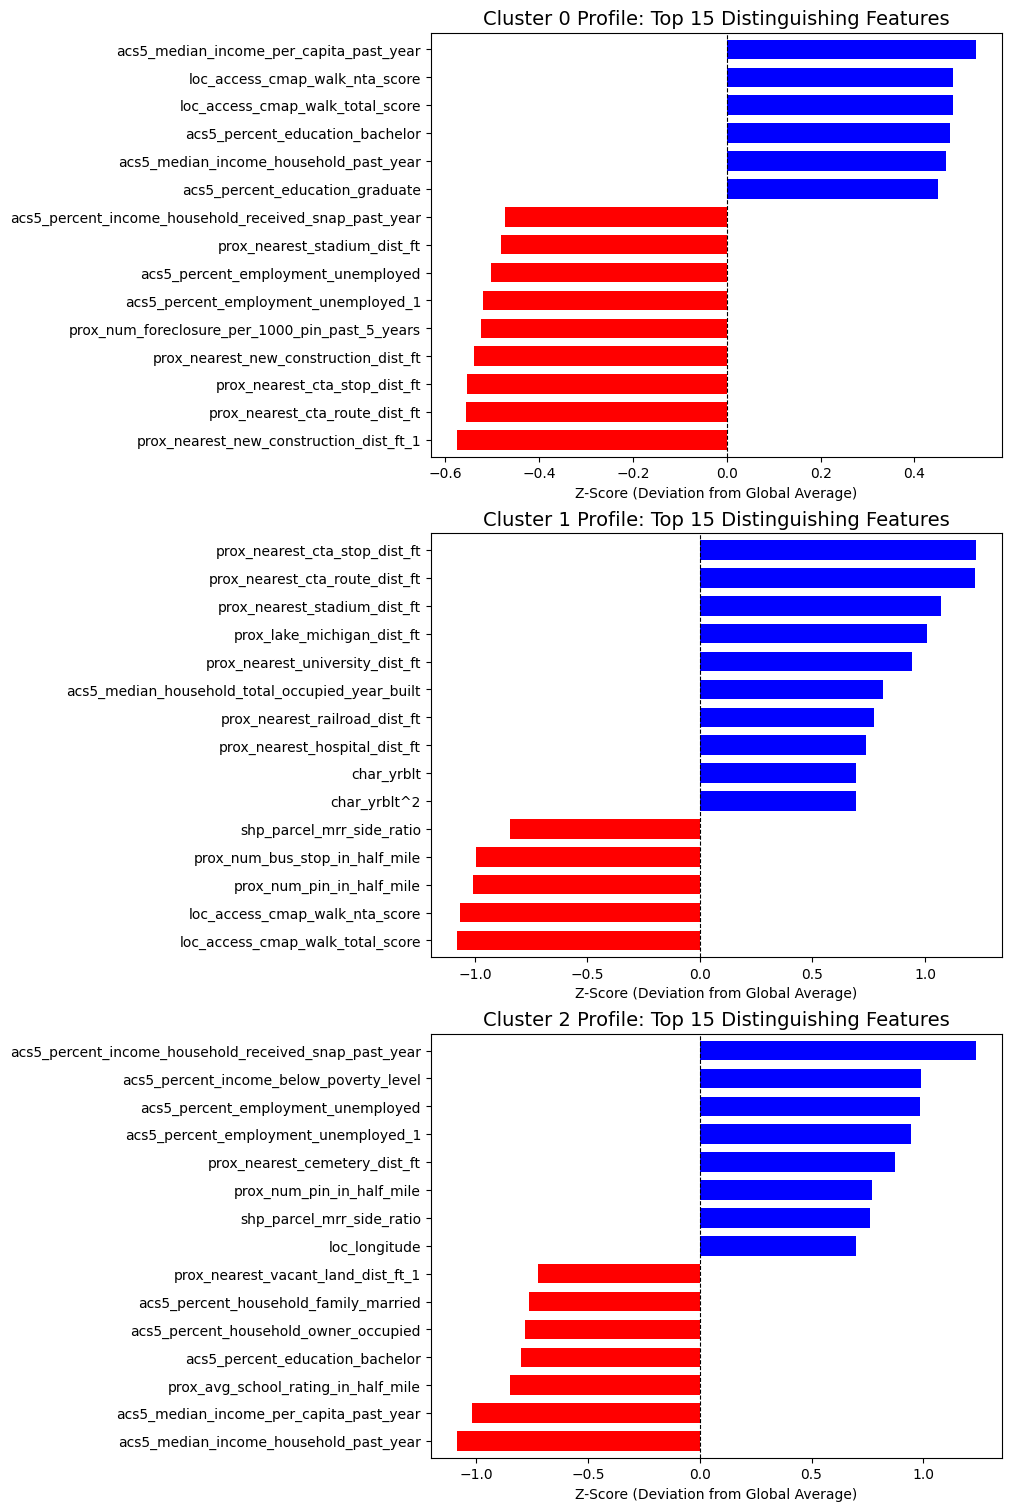

Cluster                                            High In  \
0        0  acs5_median_income_per_capita_past_year, loc_a...   
1        1  prox_nearest_cta_stop_dist_ft, prox_nearest_ct...   
2        2  acs5_percent_income_household_received_snap_pa...   

                                              Low In  
0  prox_nearest_new_construction_dist_ft_1, prox_...  
1  loc_access_cmap_walk_total_score, loc_access_c...  
2  acs5_median_income_household_past_year, acs5_m...

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

K_CLUSTERS = 3
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled   = scaler.transform(X_val_num)   # IMPORTANT: do NOT fit on val

kmeans = KMeans(n_clusters=K_CLUSTERS, n_init=100, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
val_clusters   = kmeans.predict(X_val_scaled)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare Data
# Ensure we have feature names. If X_train is numpy, create placeholders
feature_names = X_train_num.columns if hasattr(X_train, 'columns') else [f"Feature_{i}" for i in range(X_train.shape[1])]

# Create a DataFrame of the Scaled Centroids (Z-Scores)
centroids_df = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=feature_names
)
centroids_df.index.name = 'Cluster'

# 2. Function to Plot Top Features per Cluster
def plot_cluster_profiles(centroids_df, n_top_features=10):
    n_clusters = len(centroids_df)
    
    # Create a subplot for each cluster
    fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 5 * n_clusters), constrained_layout=True)
    
    # If only 1 cluster, axes is not a list, so we wrap it
    if n_clusters == 1: axes = [axes]

    for i, ax in enumerate(axes):
        # Get the centroid for this cluster
        cluster_series = centroids_df.iloc[i]
        
        # Sort by absolute magnitude to find "Importance"
        # We want the features that are MOST different from the global average
        top_features = cluster_series.abs().sort_values(ascending=False).head(n_top_features)

        # print(top_features)
        
        # Get the actual signed values (positive or negative) for these top features
        plot_data = cluster_series[top_features.index].sort_values() # Sort for cleaner plotting

        # print(plot_data)
        
        # Color coding: Blue for High values, Red for Low values
        colors = ['red' if x < 0 else 'blue' for x in plot_data]
        
        # Plot
        plot_data.plot(kind='barh', ax=ax, color=colors, width=0.7)
        
        # Formatting
        ax.set_title(f"Cluster {i} Profile: Top {n_top_features} Distinguishing Features", fontsize=14)
        ax.set_xlabel("Z-Score (Deviation from Global Average)")
        ax.axvline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
        
        # Add labels to explain the bars
        # Positive = Higher than average, Negative = Lower than average

    plt.show()

# Run the visualization
plot_cluster_profiles(centroids_df, n_top_features=15)

summary_data = []

for i in range(K_CLUSTERS):
    row = centroids_df.iloc[i]
    # Get top 3 highest values
    highs = row.nlargest(3).index.tolist()
    # Get top 3 lowest values
    lows = row.nsmallest(3).index.tolist()
    
    summary_data.append({
        "Cluster": i,
        "High In": ", ".join(highs),
        "Low In": ", ".join(lows)
    })

summary_df = pd.DataFrame(summary_data)
# Display with clear formatting
display(summary_df)


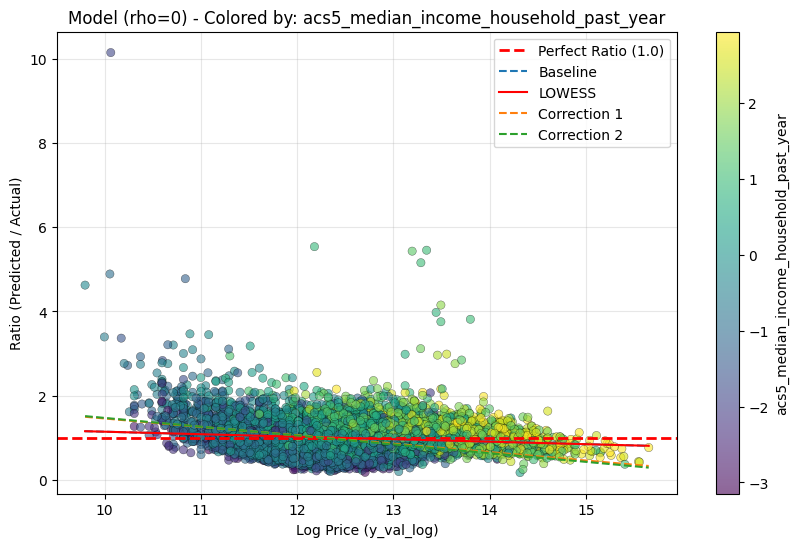

Correlation between poverty and ratios of prediction (1000):
log-price:  0.3035157375277554
price:  0.21677579023115712
Correlation for residuals versus poverty:
log-price:  0.31122339957894435
price:  0.133147300880808
{'R2': 0.8082077668943616, 'R2 (log)': 0.7602728067140447, 'RMSE': 157886.72375563104, 'MAE': 85676.3091922742, 'MAPE': 0.23636940518252367, 'MdAPE': 18.28186570893638, 'Corr(r,price)': np.float64(-0.04984502378246249), 'Corr(r,logprice)': np.float64(-0.12009531634029971), 'Slope(r~logy)': np.float64(-0.05922415718567389), 'Var ratio': np.float64(0.11587060302327766), 'Median ratio': np.float64(0.9557892985793214), 'Mean ratio': np.float64(0.9829037643393341), 'W. Mean ratio': np.float64(0.9678766570311568), 'COD': np.float64(24.41435232008424), 'COV_IAAO': np.float64(0.34633102159600015), 'VEI': np.float64(7.427472847891751), 'PRD': np.float64(1.0155258494964339), 'PRB': np.float64(0.037160327357957885), 'MKI': np.float64(1.0074618803331783)}


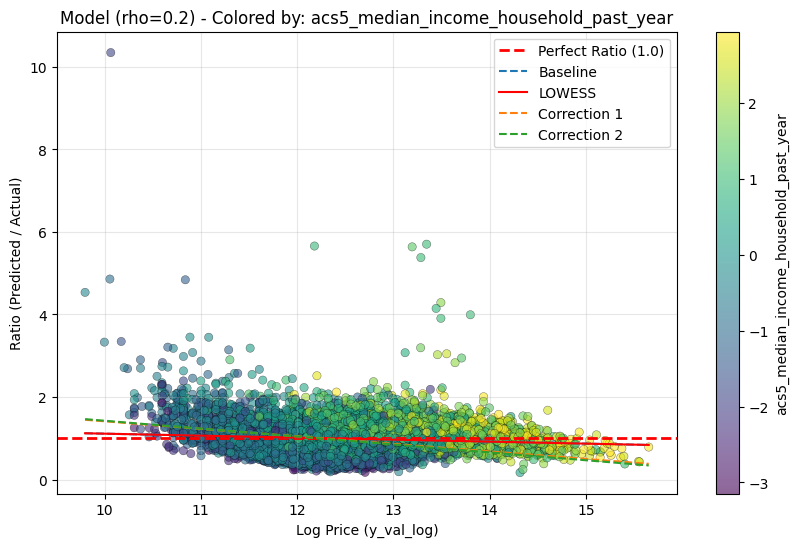

Correlation between poverty and ratios of prediction (1000):
log-price:  0.30161299740616243
price:  0.21487553512021537
Correlation for residuals versus poverty:
log-price:  0.309048040632085
price:  0.1395599778346196
{'R2': 0.8050132914520821, 'R2 (log)': 0.7561103917618024, 'RMSE': 159196.16782762072, 'MAE': 86354.09296905932, 'MAPE': 0.23824126840694332, 'MdAPE': 18.33337438279456, 'Corr(r,price)': np.float64(-0.032024336530181406), 'Corr(r,logprice)': np.float64(-0.09700836599917476), 'Slope(r~logy)': np.float64(-0.04830968221221093), 'Var ratio': np.float64(0.11816193994153282), 'Median ratio': np.float64(0.9566643919423465), 'Mean ratio': np.float64(0.9838636900394704), 'W. Mean ratio': np.float64(0.9741141103421449), 'COD': np.float64(24.608191692176725), 'COV_IAAO': np.float64(0.34939737024758527), 'VEI': np.float64(10.636918590624166), 'PRD': np.float64(1.0100086628392038), 'PRB': np.float64(0.04568569739430495), 'MKI': np.float64(1.0181764160533389)}


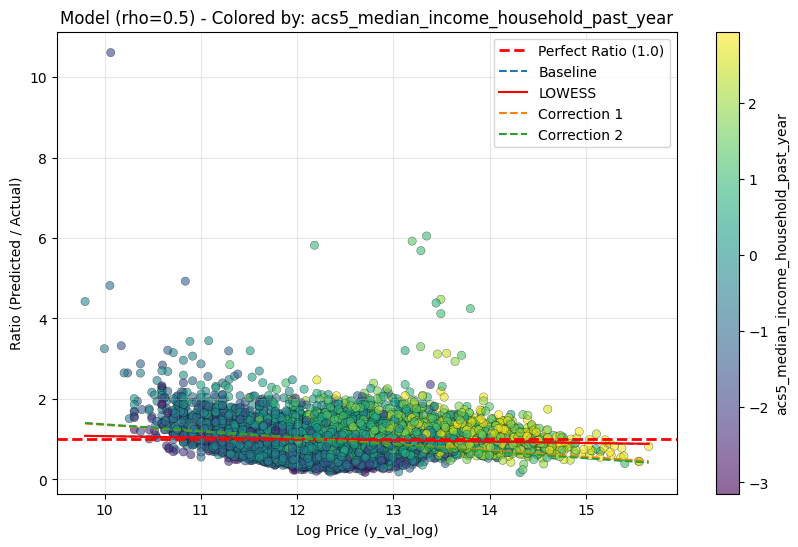

Correlation between poverty and ratios of prediction (1000):
log-price:  0.29871430958976436
price:  0.2118570586757371
Correlation for residuals versus poverty:
log-price:  0.3057659550189063
price:  0.14724045429038085
{'R2': 0.7984373722846625, 'R2 (log)': 0.7498261557807263, 'RMSE': 161858.3507282738, 'MAE': 87642.86316253318, 'MAPE': 0.24124568189178291, 'MdAPE': 18.64617099358274, 'Corr(r,price)': np.float64(-0.008822000187776178), 'Corr(r,logprice)': np.float64(-0.06703761446024646), 'Slope(r~logy)': np.float64(-0.033891389764836105), 'Var ratio': np.float64(0.12177812504999044), 'Median ratio': np.float64(0.9584903654223093), 'Mean ratio': np.float64(0.9853203789821555), 'W. Mean ratio': np.float64(0.982593796432576), 'COD': np.float64(24.90201076170708), 'COV_IAAO': np.float64(0.3541791041276428), 'VEI': np.float64(14.470374549641766), 'PRD': np.float64(1.002774882723134), 'PRB': np.float64(0.0568815921098994), 'MKI': np.float64(1.0322661226383898)}


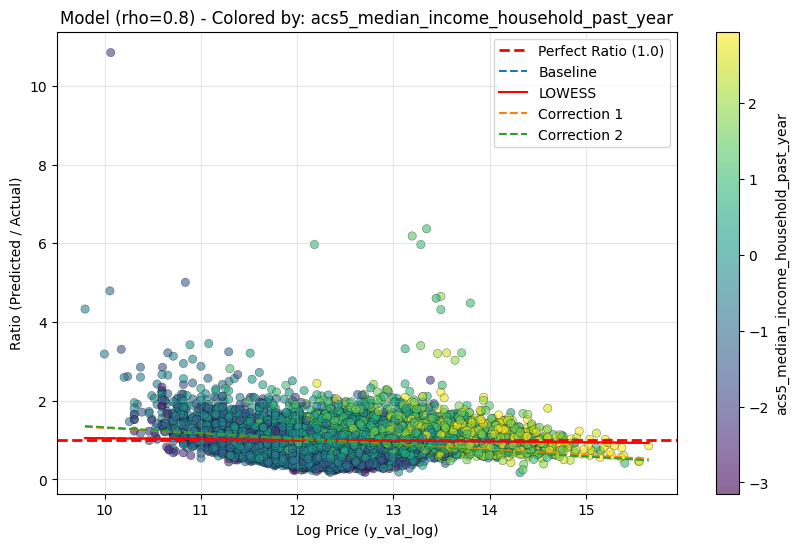

Correlation between poverty and ratios of prediction (1000):
log-price:  0.2958877525917536
price:  0.20881021865607693
Correlation for residuals versus poverty:
log-price:  0.3025907783472771
price:  0.1530776151667826
{'R2': 0.7903960653114652, 'R2 (log)': 0.7436666209065533, 'RMSE': 165055.43159317476, 'MAE': 89100.37013288429, 'MAPE': 0.2443333912198566, 'MdAPE': 18.78415265238506, 'Corr(r,price)': np.float64(0.010865549008739553), 'Corr(r,logprice)': np.float64(-0.04168704269965006), 'Slope(r~logy)': np.float64(-0.02139241189215241), 'Var ratio': np.float64(0.12547146234753845), 'Median ratio': np.float64(0.9605676800514205), 'Mean ratio': np.float64(0.9867557419917729), 'W. Mean ratio': np.float64(0.9901644602073693), 'COD': np.float64(25.18778935093835), 'COV_IAAO': np.float64(0.3589868797524774), 'VEI': np.float64(18.617751425730745), 'PRD': np.float64(0.9965574221731989), 'PRB': np.float64(0.06651925622506541), 'MKI': np.float64(1.04441363105953)}


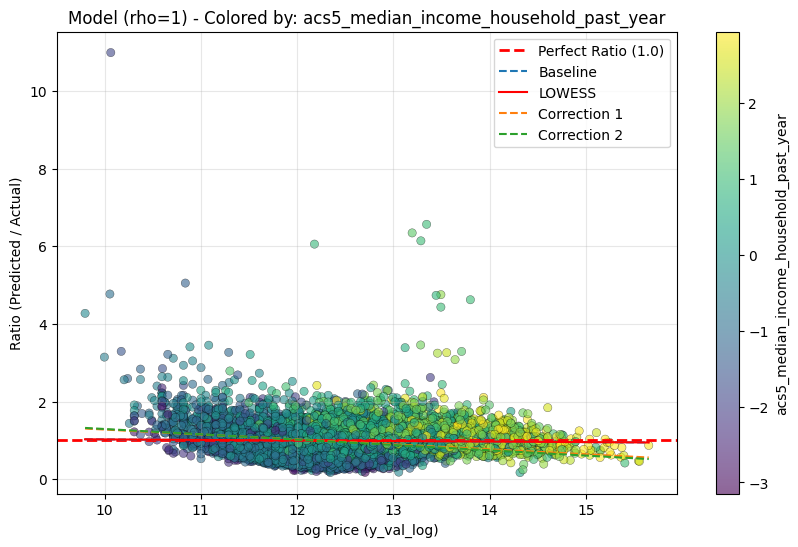

Correlation between poverty and ratios of prediction (1000):
log-price:  0.294081040950899
price:  0.206820717385472
Correlation for residuals versus poverty:
log-price:  0.3005710984771837
price:  0.15616978644786014
{'R2': 0.7844974865807259, 'R2 (log)': 0.7396857691740795, 'RMSE': 167361.7756442311, 'MAE': 90093.13636032943, 'MAPE': 0.2463588221292447, 'MdAPE': 18.960546957920084, 'Corr(r,price)': np.float64(0.022371536793937618), 'Corr(r,logprice)': np.float64(-0.02690654218173042), 'Slope(r~logy)': np.float64(-0.013941973397808756), 'Var ratio': np.float64(0.1279264508284047), 'Median ratio': np.float64(0.96124620713373), 'Mean ratio': np.float64(0.9876870308719835), 'W. Mean ratio': np.float64(0.9947737127997923), 'COD': np.float64(25.388290987714385), 'COV_IAAO': np.float64(0.362140071562145), 'VEI': np.float64(20.84748525348771), 'PRD': np.float64(0.9928760864540104), 'PRB': np.float64(0.07231389443639902), 'MKI': np.float64(1.0516223291477218)}


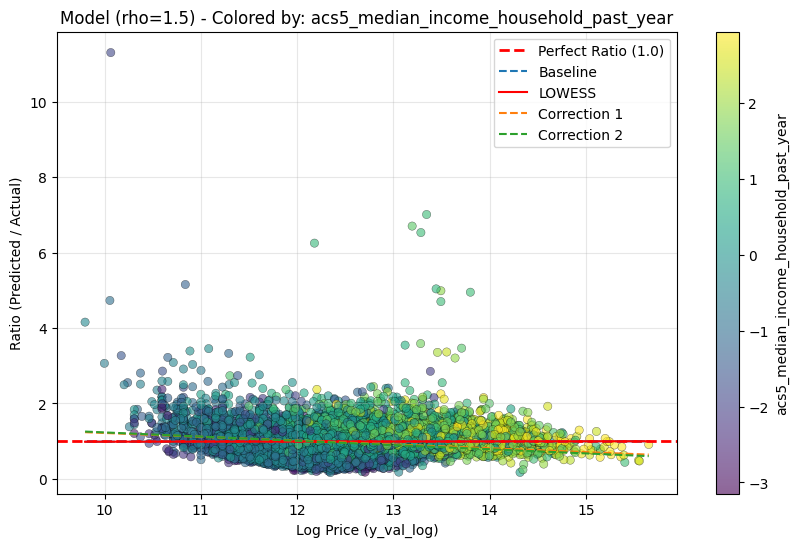

Correlation between poverty and ratios of prediction (1000):
log-price:  0.2899005701783168
price:  0.20211557625660573
Correlation for residuals versus poverty:
log-price:  0.2959212471960802
price:  0.16184873891249144
{'R2': 0.7686915403357228, 'R2 (log)': 0.7302869684184965, 'RMSE': 173390.7253182018, 'MAE': 92499.0012980941, 'MAPE': 0.2511292986330151, 'MdAPE': 19.412769097485565, 'Corr(r,price)': np.float64(0.04660948329501084), 'Corr(r,logprice)': np.float64(0.004140757477470782), 'Slope(r~logy)': np.float64(0.0021952089084832857), 'Var ratio': np.float64(0.133912079245366), 'Median ratio': np.float64(0.9632714774252822), 'Mean ratio': np.float64(0.9898962302708789), 'W. Mean ratio': np.float64(1.0050022870135722), 'COD': np.float64(25.85714920368564), 'COV_IAAO': np.float64(0.3696885203931674), 'VEI': np.float64(25.366075382342927), 'PRD': np.float64(0.9849691319732397), 'PRB': np.float64(0.08478505102175886), 'MKI': np.float64(1.0671460167434887)}


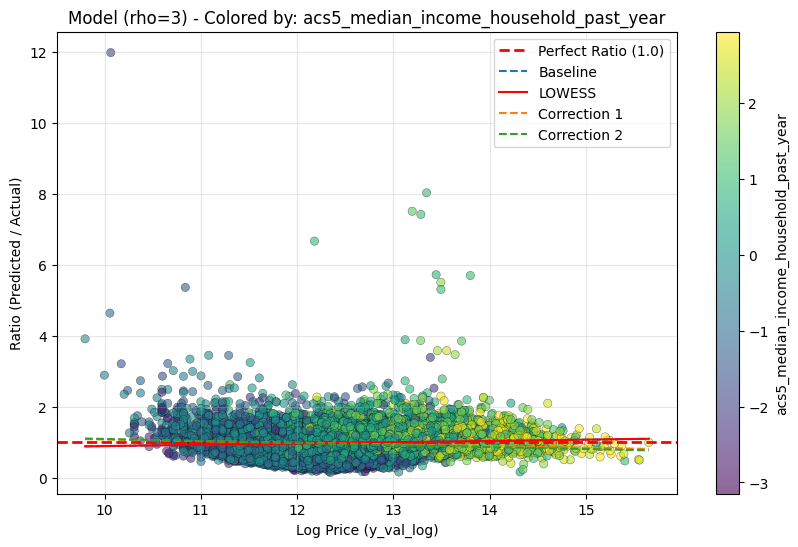

Correlation between poverty and ratios of prediction (1000):
log-price:  0.28017192050705175
price:  0.1907459972206389
Correlation for residuals versus poverty:
log-price:  0.2851964439652979
price:  0.16942468104788333
{'R2': 0.720147284382763, 'R2 (log)': 0.7070577372320777, 'RMSE': 190719.39825950403, 'MAE': 99095.84877722144, 'MAPE': 0.2631728517052475, 'MdAPE': 20.27736922011545, 'Corr(r,price)': np.float64(0.09421816575578378), 'Corr(r,logprice)': np.float64(0.06474210818484832), 'Slope(r~logy)': np.float64(0.03629176073658923), 'Var ratio': np.float64(0.14971662683245637), 'Median ratio': np.float64(0.964800052883674), 'Mean ratio': np.float64(0.9954132350964369), 'W. Mean ratio': np.float64(1.0277008978660747), 'COD': np.float64(27.09999671958207), 'COV_IAAO': np.float64(0.38872937916435124), 'VEI': np.float64(35.48449515249678), 'PRD': np.float64(0.968582626679922), 'PRB': np.float64(0.11143664586853338), 'MKI': np.float64(1.0994915598795674)}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.nonparametric.smoothers_lowess import lowess

# List of features to color the scatter plots by
features_to_plot = [
    # "acs5_percent_income_household_received_snap_past_year",
    "acs5_median_income_household_past_year"
]


class FairnessConstrainedRidgeLog(BaseEstimator, RegressorMixin):
    """Ridge regression with:
      - MSE + L2 ridge
      - global covariance penalty with y (existing)
      - optional separable surrogate (existing)
      - NEW: global covariance penalty with a sensitive attribute z in X

    Objective (sklearn-style scaling):
        (1/(2n)) * ||y - y_hat||^2
        + (alpha/2) * ||beta||^2
        + (rho/2) * c_y(beta)^2
        + (rho_sep/2) * s(beta)
        + (rho_sensitive/2) * c_z(beta)^2

    where:
      mode='diff': r_i = y_hat_i - y_i
      mode='div' : r_i = y_hat_i / y_i^safe

      c_z(beta) = (1/n) * sum_i r_i * (z_i - z_mean)
               = mean(r * z_c)
    """

    def __init__(
        self,
        alpha=1.0,
        rho=1.0,
        rho_sep=0.0,
        rho_sensitive=0.0,          # NEW
        sensitive_feature=None,     # NEW: name (str, for DataFrame) or int index
        mode="diff",
        fit_intercept=True,
        eps_y=1e-12
    ):
        self.alpha = alpha
        self.rho = rho
        self.rho_sep = rho_sep
        self.rho_sensitive = rho_sensitive
        self.sensitive_feature = sensitive_feature
        self.mode = mode
        self.fit_intercept = fit_intercept
        self.eps_y = eps_y

    def fit(self, X, y):
        # --- preserve column names (if any) BEFORE sklearn converts to ndarray
        feature_names = None
        if hasattr(X, "columns"):
            feature_names = list(X.columns)

        X, y = check_X_y(X, y, accept_sparse=False, y_numeric=True)
        n, d = X.shape

        if self.mode not in ("diff", "div"):
            raise ValueError("mode must be one of {'diff','div'}")
        if float(self.rho) < 0 or float(self.rho_sep) < 0 or float(self.rho_sensitive) < 0:
            raise ValueError("rho, rho_sep, rho_sensitive must be >= 0")

        # ---- resolve sensitive column (if requested)
        sens_idx = None
        if self.sensitive_feature is not None and float(self.rho_sensitive) > 0.0:
            sf = self.sensitive_feature
            if isinstance(sf, (int, np.integer)):
                sens_idx = int(sf)
                if sens_idx < 0 or sens_idx >= d:
                    raise ValueError(f"sensitive_feature index {sens_idx} out of bounds for X with {d} columns")
            elif isinstance(sf, str):
                if feature_names is None:
                    raise ValueError(
                        "sensitive_feature was given as a string, but X has no column names. "
                        "Pass X as a pandas DataFrame or provide an integer column index."
                    )
                if sf not in feature_names:
                    raise ValueError(f"sensitive_feature='{sf}' not found in X.columns")
                sens_idx = feature_names.index(sf)
            else:
                raise ValueError("sensitive_feature must be a column name (str) or a column index (int)")

        # ---- Augment for intercept
        if self.fit_intercept:
            X_aug = np.hstack([X, np.ones((n, 1), dtype=X.dtype)])
            p = d + 1
        else:
            X_aug = X
            p = d

        # ---- Base quadratic pieces
        XtX = (X_aug.T @ X_aug) / float(n)
        Xty = (X_aug.T @ y) / float(n)

        I_reg = np.eye(p, dtype=float)
        if self.fit_intercept:
            I_reg[-1, -1] = 0.0

        A = XtX + (float(self.alpha) * I_reg)
        rhs = Xty.copy()

        # ---- Centered y
        y_mean = float(np.mean(y))
        y_c = y - y_mean
        var_y = float(np.mean(y_c * y_c))

        # ==========================================================
        # A) Separable surrogate term (CENTERED at correct target)
        # ==========================================================
        rho_s = float(self.rho_sep)
        if rho_s > 0.0:
            if self.mode == "diff":
                d2 = (y_c ** 2).astype(float)
                Xw = X_aug * d2[:, None]
                A += rho_s * (X_aug.T @ Xw) / float(n)
                rhs += rho_s * (X_aug.T @ (d2 * y)) / float(n)
            else:
                y_safe = self._safe_y(y)
                d2 = (y_c ** 2) / (y_safe ** 2)
                Xw = X_aug * d2[:, None]
                A += rho_s * (X_aug.T @ Xw) / float(n)
                rhs += rho_s * (X_aug.T @ (d2 * y_safe)) / float(n)

        # ==========================================================
        # B) Global covariance penalties: with y (existing) + sensitive z (NEW)
        #     Each adds: (rho/2)*(u^T b - k)^2  =>  LHS += rho*u*u^T, rhs += rho*k*u
        #     We solve with Woodbury (rank-1 or rank-2).
        # ==========================================================
        pen_us = []   # list of (rho_j, u_j) with u_j as (p,1)
        rho_g = float(self.rho)
        if rho_g > 0.0:
            if self.mode == "diff":
                u = (X_aug.T @ y_c) / float(n)
                if self.fit_intercept:
                    u[-1] = 0.0
                rhs = rhs + (rho_g * var_y) * u  # k = var_y
            else:
                y_safe = self._safe_y(y)
                w = y_c / y_safe
                u = (X_aug.T @ w) / float(n)
                # k = 0 in div
            pen_us.append((rho_g, u.reshape(-1, 1)))

        rho_z = float(self.rho_sensitive)
        z = None
        z_c = None
        if rho_z > 0.0 and sens_idx is not None:
            z = np.asarray(X[:, sens_idx], dtype=float)
            z_mean = float(np.mean(z))
            z_c = z - z_mean

            if self.mode == "diff":
                v = (X_aug.T @ z_c) / float(n)
                if self.fit_intercept:
                    v[-1] = 0.0  # exact since mean(z_c)=0
                k_yz = float(np.mean(y * z_c))   # k = mean(y*z_c)
                rhs = rhs + (rho_z * k_yz) * v
            else:
                y_safe = self._safe_y(y)
                w = z_c / y_safe
                v = (X_aug.T @ w) / float(n)
                # k = 0 in div
            pen_us.append((rho_z, v.reshape(-1, 1)))

        rhs_vec = rhs.reshape(-1, 1)

        if len(pen_us) == 0:
            beta = self._solve(A, rhs_vec).ravel()
            u_for_diag = None

        elif len(pen_us) == 1:
            rho1, u1 = pen_us[0]
            beta0 = self._solve(A, rhs_vec)
            Au1 = self._solve(A, u1)
            denom = 1.0 + float(rho1) * float((u1.T @ Au1).item())

            if (not np.isfinite(denom)) or abs(denom) < 1e-15:
                LHS = A + float(rho1) * (u1 @ u1.T)
                beta = self._solve(LHS, rhs_vec).ravel()
            else:
                beta = (beta0 - (float(rho1) / denom) * (Au1 * float((u1.T @ beta0).item()))).ravel()
            u_for_diag = u1.ravel()

        else:
            # rank-2 Woodbury (generalizes cleanly)
            (rho1, u1), (rho2, u2) = pen_us[0], pen_us[1]
            U = np.hstack([np.sqrt(float(rho1)) * u1, np.sqrt(float(rho2)) * u2])  # (p,2)

            Ainv_rhs = self._solve(A, rhs_vec)     # (p,1)
            Ainv_U = self._solve(A, U)             # (p,2)

            S = np.eye(2, dtype=float) + (U.T @ Ainv_U)  # (2,2)

            try:
                tmp = np.linalg.solve(S, (U.T @ Ainv_rhs))  # (2,1)
                beta = (Ainv_rhs - (Ainv_U @ tmp)).ravel()
            except np.linalg.LinAlgError:
                # fallback to explicit solve
                LHS = A + float(rho1) * (u1 @ u1.T) + float(rho2) * (u2 @ u2.T)
                beta = self._solve(LHS, rhs_vec).ravel()

            u_for_diag = None  # not unique anymore

        # ---- unpack
        if self.fit_intercept:
            self.coef_ = beta[:-1]
            self.intercept_ = float(beta[-1])
        else:
            self.coef_ = beta
            self.intercept_ = 0.0

        # ---- diagnostics (train moments)
        y_hat = X_aug @ beta
        if self.mode == "diff":
            r = y_hat - y
            r_tilde = r
        else:
            y_safe = self._safe_y(y)
            r = y_hat / y_safe
            r_tilde = r - 1.0

        # y-cov diagnostics
        a = r * y_c
        a_tilde = r_tilde * y_c
        self.cov_moment_ = float(np.mean(a))
        self.cov_moment_sq_ = float(self.cov_moment_ ** 2)
        self.sep_surrogate_ = float(np.mean(a_tilde ** 2))

        # sensitive-cov diagnostics (NEW)
        self.cov_sensitive_ = None
        self.cov_sensitive_sq_ = None
        self.sensitive_index_ = sens_idx
        self.sensitive_name_ = None
        if sens_idx is not None and feature_names is not None and isinstance(self.sensitive_feature, str):
            self.sensitive_name_ = self.sensitive_feature

        if z_c is not None:
            cs = float(np.mean(r * z_c))  # Cov(r,z) since z_c is centered
            self.cov_sensitive_ = cs
            self.cov_sensitive_sq_ = float(cs ** 2)

        # ---- store misc
        self.y_mean_ = y_mean
        self._u_ = None if u_for_diag is None else u_for_diag
        self._n_features_in_ = d
        if feature_names is not None:
            self.feature_names_in_ = np.asarray(feature_names, dtype=object)

        return self

    def predict(self, X):
        check_is_fitted(self, ["coef_", "intercept_"])
        X = check_array(X)
        return X @ self.coef_ + self.intercept_

    def _safe_y(self, y):
        y = np.asarray(y, dtype=float)
        eps = float(self.eps_y)
        y_safe = y.copy()
        mask = np.abs(y_safe) < eps
        if np.any(mask):
            y_safe[mask] = np.where(y_safe[mask] >= 0.0, eps, -eps)
        return y_safe

    @staticmethod
    def _solve(M, b):
        try:
            return np.linalg.solve(M, b)
        except np.linalg.LinAlgError:
            return np.linalg.lstsq(M, b, rcond=None)[0]


class LGBCovPenalty:
    """LightGBM objective: MSE
        + rho * (Cov(r, y))^2
        + rho_sep * (separable surrogate upper bound centered at target)^*
        + rho_sensitive * (Cov(r, z))^2   where z is a sensitive feature column in X

    r is chosen by ratio_mode:
      - "div"  : r = y_pred / max(|y_true|, eps_y)    (DEFAULT, preserves old behavior)
      - "diff" : r = y_pred - y_true

    Cov with y:
      cov_y = mean( r_eff * (y_true - y_mean_) )

    NEW: Cov with sensitive z:
      cov_z = mean( r_eff * (z - z_mean_) )

    NEW: Separable surrogate (centered at correct target):
      t = 0 for diff, 1 for div
      r_tilde = r - t
      sep = mean( (r_tilde * (y_true - y_mean_))^2 )

    Scaling (kept consistent with your existing cov penalty style):
      pen_cov = 0.5 * rho * n * cov_y^2
      pen_sens = 0.5 * rho_sensitive * n * cov_z^2
      pen_sep = 0.5 * rho_sep * n * sep

    Diagonal Hessian approximations:
      - cov penalties: same as before (diag approx)
      - sep surrogate: exact (separable)
    """

    def __init__(
        self,
        rho=1e-3,
        rho_sep=0.0,                 # NEW
        rho_sensitive=0.0,           # NEW
        sensitive_feature=None,      # NEW: str (DataFrame col) or int index
        ratio_mode="div",            # "div" or "diff"
        anchor_mode="none",          # "none" | "target" | "iter_mean"  (no-op for centered cov terms)
        target_value=None,           # if anchor_mode="target": default 1.0 (div) or 0.0 (diff)
        zero_grad_tol=1e-6,
        eps_y=1e-12,
        lgbm_params=None,
        verbose=True,
    ):
        self.rho = float(rho)
        self.rho_sep = float(rho_sep)
        self.rho_sensitive = float(rho_sensitive)
        self.sensitive_feature = sensitive_feature

        self.ratio_mode = ratio_mode
        self.anchor_mode = anchor_mode
        self.target_value = target_value
        self.zero_grad_tol = float(zero_grad_tol)
        self.eps_y = float(eps_y)
        self.verbose = bool(verbose)
        self.model = lgb.LGBMRegressor(**(lgbm_params or {}))

    def fit(self, X, y):
        # Keep feature names if available (for name-based sensitive_feature)
        feature_names = None
        if hasattr(X, "columns"):
            feature_names = list(X.columns)

        y = np.asarray(y, dtype=float)
        self.y_mean_ = float(np.mean(y))

        # Resolve and store sensitive column (centered), if requested
        self._z_c_ = None
        self.sensitive_index_ = None
        self.sensitive_name_ = None

        if self.rho_sensitive > 0.0 and self.sensitive_feature is not None:
            sf = self.sensitive_feature

            # Determine index
            if isinstance(sf, (int, np.integer)):
                idx = int(sf)
            elif isinstance(sf, str):
                if feature_names is None:
                    raise ValueError(
                        "sensitive_feature was given as a string, but X has no column names. "
                        "Pass X as a pandas DataFrame or provide an integer column index."
                    )
                if sf not in feature_names:
                    raise ValueError(f"sensitive_feature='{sf}' not found in X.columns")
                idx = feature_names.index(sf)
                self.sensitive_name_ = sf
            else:
                raise ValueError("sensitive_feature must be a column name (str) or a column index (int)")

            # Extract column without densifying whole X if sparse
            try:
                import scipy.sparse as sp
                is_sparse = sp.issparse(X)
            except Exception:
                is_sparse = False

            if is_sparse:
                z = np.asarray(X[:, idx].toarray()).ravel().astype(float)
            else:
                X_arr = X.values if hasattr(X, "values") else np.asarray(X)
                if idx < 0 or idx >= X_arr.shape[1]:
                    raise ValueError(f"sensitive_feature index {idx} out of bounds for X with {X_arr.shape[1]} columns")
                z = np.asarray(X_arr[:, idx], dtype=float)

            z_mean = float(np.mean(z))
            self._z_c_ = (z - z_mean).astype(float)
            self.sensitive_index_ = idx

        # Set custom objective and fit
        self.model.set_params(objective=self.fobj)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def fobj(self, y_true, y_pred):
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        n = y_pred.size

        yc = (y_true - self.y_mean_)  # centered y (mean ~ 0 on training data)

        # ---- choose r and dr/dy_pred ----
        if self.ratio_mode == "div":
            denom = np.maximum(np.abs(y_true), self.eps_y)
            r = y_pred / denom
            dr = 1.0 / denom
            t = 1.0
        elif self.ratio_mode == "diff":
            r = y_pred - y_true
            dr = np.ones_like(y_pred)
            t = 0.0
        else:
            raise ValueError("ratio_mode must be 'div' or 'diff'.")

        # ---- optional anchor (no-op for centered yc and centered zc; kept for API symmetry) ----
        if self.anchor_mode == "none":
            anchor = 0.0
        elif self.anchor_mode == "iter_mean":
            anchor = float(np.mean(r))
        elif self.anchor_mode == "target":
            if self.target_value is None:
                anchor = 1.0 if self.ratio_mode == "div" else 0.0
            else:
                anchor = float(self.target_value)
        else:
            raise ValueError("anchor_mode must be 'none', 'iter_mean', or 'target'.")

        r_eff = r - anchor  # cov uses r_eff (anchor has ~no effect because yc,z_c are centered)

        # ---- covariance with y ----
        cov_y = float(np.mean(r_eff * yc))

        # ---- NEW: covariance with sensitive z ----
        cov_z = 0.0
        z_c = self._z_c_
        if (z_c is not None) and (self.rho_sensitive > 0.0):
            # assumes objective is evaluated on training data in same order
            cov_z = float(np.mean(r_eff * z_c))

        # ---- NEW: separable surrogate (centered at target t) ----
        sep = 0.0
        if self.rho_sep > 0.0:
            r_tilde = r - t
            sep = float(np.mean((r_tilde * yc) ** 2))

        # ---- objective pieces (for prints) ----
        mse_vec = (y_true - y_pred) ** 2
        mse_mean = float(np.mean(mse_vec))

        pen_cov = 0.5 * self.rho * float(n) * (cov_y ** 2) if self.rho > 0.0 else 0.0
        pen_sens = 0.5 * self.rho_sensitive * float(n) * (cov_z ** 2) if self.rho_sensitive > 0.0 else 0.0
        pen_sep = 0.5 * self.rho_sep * float(n) * sep if self.rho_sep > 0.0 else 0.0

        try:
            corr_ry = float(np.corrcoef(r, y_true)[0, 1])
        except Exception:
            corr_ry = float("nan")

        corr_rz = float("nan")
        if z_c is not None:
            try:
                # z_c is centered; correlation with raw z differs by a constant shift only
                corr_rz = float(np.corrcoef(r, z_c)[0, 1])
            except Exception:
                corr_rz = float("nan")

        if self.verbose:
            model_name = self.__str__().split("(")[0]
            print(
                f"[{model_name}] "
                f"Loss: {(mse_mean + pen_cov + pen_sep + pen_sens):.6f} | "
                f"MSE: {mse_mean:.6f} | "
                f"Cov(y): {cov_y:.6e} | PenCov: {pen_cov:.6f} | "
                f"Sep: {sep:.6e} | PenSep: {pen_sep:.6f} | "
                f"Cov(z): {cov_z:.6e} | PenSens: {pen_sens:.6f} | "
                f"Corr(r,y): {corr_ry:.6f} | Corr(r,z): {corr_rz:.6f}"
            )

        # ---- base MSE grads/hess ----
        grad_base = 2.0 * (y_pred - y_true)
        hess_base = 2.0 * np.ones_like(y_pred)

        grad = grad_base.copy()
        hess = hess_base.copy()

        # ---- cov(y) penalty grads/hess (diag approx) ----
        # dc/dy_pred_i = (1/n) * yc_i * dr_i
        if self.rho > 0.0:
            a_y = (yc * dr) / float(n)
            grad += self.rho * float(n) * cov_y * a_y
            hess += self.rho * float(n) * (a_y ** 2)

        # ---- NEW: cov(z) penalty grads/hess (diag approx) ----
        if (z_c is not None) and (self.rho_sensitive > 0.0):
            a_z = (z_c * dr) / float(n)
            grad += self.rho_sensitive * float(n) * cov_z * a_z
            hess += self.rho_sensitive * float(n) * (a_z ** 2)

        # ---- NEW: separable surrogate grads/hess (exact diag) ----
        if self.rho_sep > 0.0:
            r_tilde = r - t
            grad += self.rho_sep * (yc ** 2) * r_tilde * dr
            hess += self.rho_sep * (yc ** 2) * (dr ** 2)

        # ---- stabilize ----
        grad[np.abs(grad) < self.zero_grad_tol] = self.zero_grad_tol
        hess[hess < self.zero_grad_tol] = self.zero_grad_tol

        return grad, hess

    def __str__(self):
        return (
            "LGBCovPenalty("
            f"rho={self.rho}, rho_sep={self.rho_sep}, "
            f"rho_sensitive={self.rho_sensitive}, ratio_mode={self.ratio_mode}"
            ")"
        )


sens_feat = "acs5_median_income_household_past_year"#"acs5_percent_income_household_received_snap_past_year"

models_to_plot = [
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0, rho_sensitive=1000,  sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0.20, rho_sensitive=1000,  sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0.50, rho_sensitive=1000, sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0.80, rho_sensitive=1000, sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=1, rho_sensitive=1000, sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=1.5, rho_sensitive=1000, sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),
    # FairnessConstrainedRidgeLog(alpha=best_alpha, rho=3, rho_sensitive=1000, sensitive_feature=sens_feat, fit_intercept=True, mode="diff"),

    LGBCovPenalty(rho=0, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params),
    LGBCovPenalty(rho=0.1, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params),
    LGBCovPenalty(rho=0.5, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params),
    LGBCovPenalty(rho=1, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params),
    LGBCovPenalty(rho=3, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params),
    LGBCovPenalty(rho=5, rho_sensitive=10, sensitive_feature=sens_feat, ratio_mode="diff", anchor_mode="target", zero_grad_tol=1e-12, lgbm_params=lgbm_params)
]

# --- 1) Run Models & Plot
for model_ in models_to_plot:
    # 1) Fit & Predict
    model_.fit(X_train, y_train_log)
    y_pred_log = model_.predict(X_val)

    # 2) Compute ratios in price space (AV/MV style)
    y_pred_money = np.exp(y_pred_log)
    y_val_money  = np.exp(y_val_log)
    ratios = y_pred_money / y_val_money

    # 3) Plot y_val_log vs ratios, colored by each feature in the list
    for feature in features_to_plot:
        plt.figure(figsize=(10, 6))
        
        # We use X_val[feature] for coloring because y_val_log and ratios correspond to validation data
        sc = plt.scatter(
            y_val_log, 
            ratios, 
            c=X_val[feature], 
            cmap='viridis', 
            alpha=0.6,
            edgecolors='k',
            linewidth=0.3
        )
        
        cbar = plt.colorbar(sc)
        cbar.set_label(feature)
        
        plt.axhline(1.0, color='red', linestyle='--', linewidth=2, label="Perfect Ratio (1.0)")
        plt.xlabel("Log Price (y_val_log)")
        plt.ylabel("Ratio (Predicted / Actual)")
        
        # Access 'rho' for title if available, otherwise generic
        rho_val = getattr(model_, 'rho', 'N/A')
        plt.title(f"Model (rho={rho_val}) - Colored by: {feature}")



        # Regression of slopes
        X_slopes = pd.DataFrame()
        X_slopes["y"] = y_val_log

        m_ = LinearRegression(fit_intercept=True)
        m_.fit(X_slopes, ratios)
        # print("Baseline: ")
        # print(X_slopes.columns)
        # print(m_.intercept_, m_.coef_)
        x_poly = np.linspace(y_val_log.min(), y_val_log.max(), 10) 
        y_poly = m_.intercept_ + m_.coef_[0] * x_poly
        # Apply LOWESS (frac controls smoothness: lower = wigglier)
        plt.plot(x_poly, y_poly, "--", alpha=1, label="Baseline")
        smoothed = lowess(y_poly, x_poly, frac=0.3, return_sorted=True)
        plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOWESS')

        # Regression of slopes
        X_slopes = pd.DataFrame()
        X_slopes["y"] = y_val_log
        X_slopes[feature] = X_val[feature] 
        # X_slopes["interaction"] = y_val_log * X_val[feature] 

        m_ = LinearRegression(fit_intercept=True)
        m_.fit(X_slopes, ratios)
        # print("Coefficients 1: ")
        # print(X_slopes.columns)
        # print(m_.intercept_, m_.coef_) 
        x_poly = np.linspace(y_val_log.min(), y_val_log.max(), 10) 
        y_poly = m_.intercept_ + m_.coef_[0] * x_poly
        plt.plot(x_poly, y_poly, "--", alpha=1, label="Correction 1")

        # Regression of slopes
        X_slopes = pd.DataFrame()
        X_slopes["y"] = y_val_log
        X_slopes[feature] = X_val[feature] 
        X_slopes["interaction"] = y_val_log * X_val[feature] 

        m_ = LinearRegression(fit_intercept=True)
        m_.fit(X_slopes, ratios)
        # print("Coefficients 2: ")
        # print(X_slopes.columns)
        # print(m_.intercept_, m_.coef_) 
        x_poly = np.linspace(y_val_log.min(), y_val_log.max(), 10) 
        y_poly = m_.intercept_ + m_.coef_[0] * x_poly
        plt.plot(x_poly, y_poly, "--", alpha=1, label="Correction 2")

        plt.legend()
        plt.grid(True, alpha=0.3)
        # plt.ylim([0,4])
        plt.show()

        print(f"Correlation between poverty and ratios of prediction ({model_.rho_sensitive}):")
        print("log-price: ", np.corrcoef(y_pred_log/y_val_log, X_val[feature])[0,1])
        print("price: ", np.corrcoef(y_pred_money/y_val_money, X_val[feature])[0,1])
        print("Correlation for residuals versus poverty:")
        print("log-price: ", np.corrcoef(y_pred_log - y_val_log, X_val[feature])[0,1])
        print("price: ", np.corrcoef(y_pred_money - y_val_money, X_val[feature])[0,1])

        print(compute_taxation_metrics(y_val_log, y_pred_log, scale="log"))
        
        # 


Generating Model Comparison Scatter Plots...


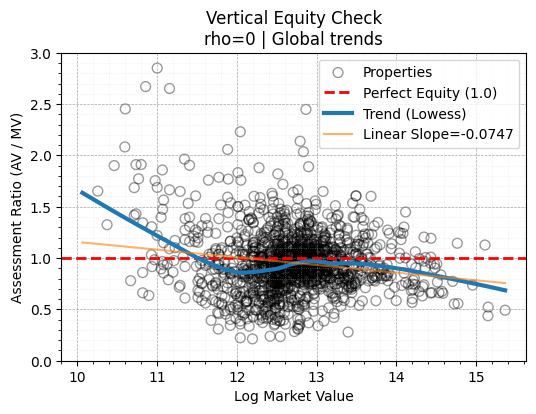

{'R2': 0.8114292555059072,
 'R2 (log)': 0.7475585675636452,
 'RMSE': 167167.7957913747,
 'MAE': 90268.63143068849,
 'MAPE': 0.2341659078545654,
 'MdAPE': 18.91584891582003,
 'Corr(r,price)': np.float64(-0.0947222982157005),
 'Corr(r,logprice)': np.float64(-0.1617402214536415),
 'Slope(r~logy)': np.float64(-0.07473928452302055),
 'Var ratio': np.float64(0.10167661202492514),
 'Median ratio': np.float64(0.9280440666204978),
 'Mean ratio': np.float64(0.9557066449782198),
 'W. Mean ratio': np.float64(0.9278820178905991),
 'COD': np.float64(24.36582768933392),
 'COV_IAAO': np.float64(0.33376713153105775),
 'VEI': np.float64(5.061659577833877),
 'PRD': np.float64(1.0299872468170854),
 'PRB': np.float64(0.022781396127285636),
 'MKI': np.float64(0.9734674111572256)}


================ CLUSTER DIAGNOSTICS =================
rho=0 | K=3
eta^2(y_log | cluster)   = 0.241   (high => clusters ~ price strata)
eta^2(ratio | cluster)   = 0.029
After demeaning ratio within cluster: slope=-0.1128, corr=-0.2478

Per-cluster table (look at y_mean separation and within-cluster slope/corr):


cluster    n     y_mean     y_std  ratio_mean  ratio_std  slope_ratio_vs_y  \
0        0  583  13.028705  0.605455    1.004333   0.256225         -0.102028   
1        1  494  12.629561  0.576634    0.955540   0.263866         -0.034915   
2        2  301  12.145473  0.632087    0.861798   0.458974         -0.386661   

   corr_ratio_y  
0     -0.241090  
1     -0.076301  
2     -0.532499

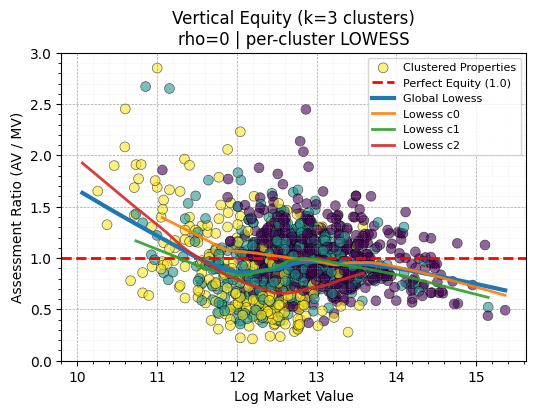

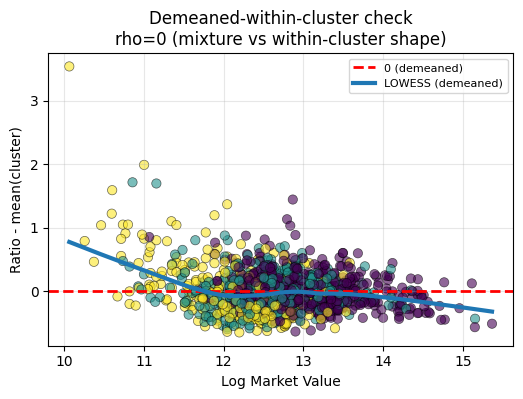

/tmp/ipykernel_2129640/2430424571.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = 1.0 + float(self.rho) * float(u.T @ Au)
/tmp/ipykernel_2129640/2430424571.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = beta0 - (float(self.rho) / denom) * (Au * float(u.T @ beta0))


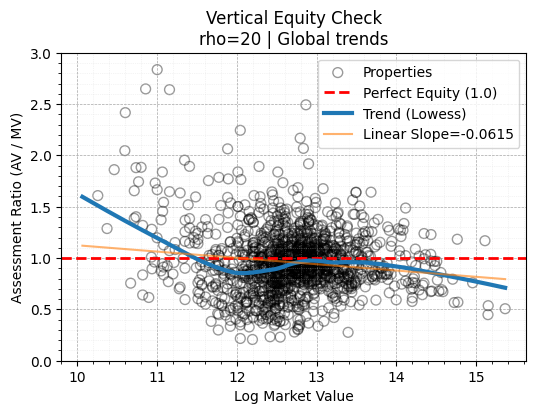

{'R2': 0.8142117895871668,
 'R2 (log)': 0.7424390266998887,
 'RMSE': 165929.85509893368,
 'MAE': 90903.1034182633,
 'MAPE': 0.23644734911178936,
 'MdAPE': 18.977454392072413,
 'Corr(r,price)': np.float64(-0.07342580925940954),
 'Corr(r,logprice)': np.float64(-0.13209236900535795),
 'Slope(r~logy)': np.float64(-0.061458244277622504),
 'Var ratio': np.float64(0.10307755339199731),
 'Median ratio': np.float64(0.9310610137510338),
 'Mean ratio': np.float64(0.9589383814432101),
 'W. Mean ratio': np.float64(0.9372215037619095),
 'COD': np.float64(24.621218411450062),
 'COV_IAAO': np.float64(0.3349260965700732),
 'VEI': np.float64(9.023900271161649),
 'PRD': np.float64(1.0231715529297305),
 'PRB': np.float64(0.03339083300203727),
 'MKI': np.float64(0.986031180825403)}


================ CLUSTER DIAGNOSTICS =================
rho=20 | K=3
eta^2(y_log | cluster)   = 0.241   (high => clusters ~ price strata)
eta^2(ratio | cluster)   = 0.035
After demeaning ratio within cluster: slope=-0.1036, corr=-0.2267

Per-cluster table (look at y_mean separation and within-cluster slope/corr):


cluster    n     y_mean     y_std  ratio_mean  ratio_std  slope_ratio_vs_y  \
0        0  583  13.028705  0.605455    1.013020   0.260269         -0.091380   
1        1  494  12.629561  0.576634    0.958236   0.266709         -0.021840   
2        2  301  12.145473  0.632087    0.855341   0.455577         -0.373274   

   corr_ratio_y  
0     -0.212574  
1     -0.047219  
2     -0.517896

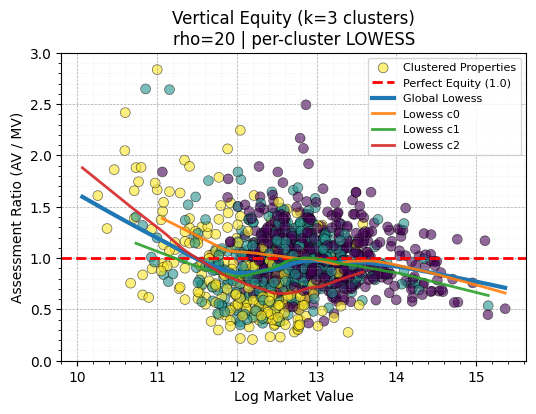

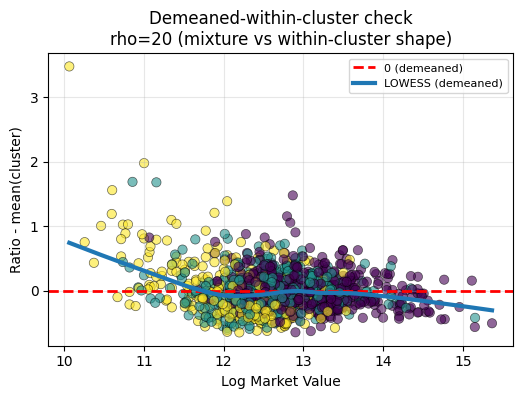

In [13]:
# =======================================================
# PLOT SET 3: Model Comparison Scatters (Lowess) + cluster tests
# =======================================================
print("\nGenerating Model Comparison Scatter Plots...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

models_to_plot = [
    FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0,  fit_intercept=True, mode="div"),
    FairnessConstrainedRidgeLog(alpha=best_alpha, rho=20, fit_intercept=True, mode="div"),
]

# # --- 1) Robust K-Means clustering on X (train-fitted scaler + train-fitted kmeans) ---
# K_CLUSTERS = 3
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled   = scaler.transform(X_val)   # IMPORTANT: do NOT fit on val

# kmeans = KMeans(n_clusters=K_CLUSTERS, n_init=50, random_state=42)
# train_clusters = kmeans.fit_predict(X_train_scaled)
# val_clusters   = kmeans.predict(X_val_scaled)

def _eta_sq(values, groups):
    """eta^2 = between-SS / total-SS (how much 'groups' explains 'values')"""
    values = np.asarray(values, float)
    groups = np.asarray(groups)
    mu = float(values.mean())
    ss_tot = float(np.sum((values - mu) ** 2))
    if ss_tot <= 1e-12:
        return np.nan
    ss_between = 0.0
    for g in np.unique(groups):
        idx = (groups == g)
        if idx.sum() == 0:
            continue
        mu_g = float(values[idx].mean())
        ss_between += float(idx.sum()) * (mu_g - mu) ** 2
    return ss_between / ss_tot

def _cluster_table(y_log, ratios, clusters):
    rows = []
    y_log = np.asarray(y_log, float)
    ratios = np.asarray(ratios, float)
    clusters = np.asarray(clusters)

    for g in np.unique(clusters):
        idx = (clusters == g)
        n = int(idx.sum())
        if n < 10:
            continue
        x = y_log[idx]
        r = ratios[idx]

        # within-cluster slope/corr
        if np.std(x) > 1e-9 and np.std(r) > 1e-12:
            slope = float(np.polyfit(x, r, 1)[0])
            corr = float(np.corrcoef(x, r)[0, 1])
        else:
            slope, corr = np.nan, np.nan

        rows.append({
            "cluster": int(g),
            "n": n,
            "y_mean": float(x.mean()),
            "y_std": float(x.std(ddof=0)),
            "ratio_mean": float(r.mean()),
            "ratio_std": float(r.std(ddof=0)),
            "slope_ratio_vs_y": slope,
            "corr_ratio_y": corr,
        })
    return pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)


    

for model_ in models_to_plot:
    # 1) Fit & Predict
    model_.fit(X_train, y_train_log)
    y_pred_log = model_.predict(X_val)

    # 2) Compute ratios in price space (AV/MV style)
    y_pred_money = np.exp(y_pred_log)
    y_val_money  = np.exp(y_val_log)
    ratios = y_pred_money / y_val_money

    # ------------------------------------------------------------------
    # A) Plot 1: global scatter + global LOWESS/linear
    # ------------------------------------------------------------------
    y_log_np = y_val_log.to_numpy()          # positional-safe
    order = np.argsort(y_log_np)

    x_sorted = y_log_np[order]
    r_sorted = np.asarray(ratios)[order]

    plt.figure(figsize=(6, 4))
    plt.scatter(y_val_log, ratios,
                facecolors='none', edgecolors='black', s=50, alpha=0.4, label='Properties')
    plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

    lowess_all = sm.nonparametric.lowess(r_sorted, x_sorted, frac=0.4, return_sorted=True)
    plt.plot(lowess_all[:, 0], lowess_all[:, 1], linewidth=3, label='Trend (Lowess)')

    z = np.polyfit(y_val_log, ratios, 1)
    p = np.poly1d(z)
    plt.plot(x_sorted, p(x_sorted), alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

    plt.ylabel("Assessment Ratio (AV / MV)")
    plt.xlabel("Log Market Value")
    plt.title(f"Vertical Equity Check\nrho={model_.rho:.3g} | Global trends")
    plt.legend(loc='upper right')
    plt.ylim(0, 3)
    plt.show()

    display(compute_taxation_metrics(y_val_log, y_pred_log, scale="log"))

    # ------------------------------------------------------------------
    # B) TESTS: are clusters basically price strata? and is the “shape” mixture?
    # ------------------------------------------------------------------
    tab = _cluster_table(y_val_log, ratios, val_clusters)

    eta_y = _eta_sq(y_val_log, val_clusters)      # how much clustering explains y
    eta_r = _eta_sq(ratios, val_clusters)         # how much clustering explains ratios

    # Demean ratios within cluster (tests mixture/intercept effect)
    ratios_demeaned = ratios.copy().astype(float)
    # before the cluster loop (once)
    y_log_np = y_val_log.to_numpy()
    ratios_np = np.asarray(ratios)
    clusters_np = np.asarray(val_clusters)

    for g in np.unique(val_clusters):
        idx = (val_clusters == g)
        if idx.sum() > 0:
            ratios_demeaned[idx] -= float(ratios[idx].mean())

    if np.std(y_val_log) > 1e-9 and np.std(ratios_demeaned) > 1e-12:
        slope_demean = float(np.polyfit(y_val_log, ratios_demeaned, 1)[0])
        corr_demean = float(np.corrcoef(y_val_log, ratios_demeaned)[0, 1])
    else:
        slope_demean, corr_demean = np.nan, np.nan

    print("\n================ CLUSTER DIAGNOSTICS =================")
    print(f"rho={model_.rho:.3g} | K={K_CLUSTERS}")
    print(f"eta^2(y_log | cluster)   = {eta_y:.3f}   (high => clusters ~ price strata)")
    print(f"eta^2(ratio | cluster)   = {eta_r:.3f}")
    print(f"After demeaning ratio within cluster: slope={slope_demean:.4f}, corr={corr_demean:.4f}")
    print("\nPer-cluster table (look at y_mean separation and within-cluster slope/corr):")
    display(tab)

    # ------------------------------------------------------------------
    # C) Plot 2: colored scatter + LOWESS per cluster (key visual check)
    # ------------------------------------------------------------------
    plt.figure(figsize=(6, 4))
    sc = plt.scatter(y_val_log, ratios,
                     c=val_clusters, cmap='viridis',
                     edgecolors='black', linewidth=0.5,
                     s=50, alpha=0.6, label='Clustered Properties')

    plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)
    plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

    # global lowess again
    plt.plot(lowess_all[:, 0], lowess_all[:, 1], linewidth=3, label='Global Lowess')

    # # per-cluster LOWESS + per-cluster linear slopes (small lines)
    # for g in np.unique(val_clusters):
    #     idx = (val_clusters == g)
    #     if idx.sum() < 30:
    #         continue
    # inside the per-cluster LOWESS loop
    for g in np.unique(clusters_np):
        idx = (clusters_np == g)          # boolean mask (ndarray)
        if idx.sum() < 30:
            continue

        xg = y_log_np[idx]               # ndarray
        rg = ratios_np[idx]              # ndarray

        og = np.argsort(xg)
        low = sm.nonparametric.lowess(rg[og], xg[og], frac=0.4, return_sorted=True)
        plt.plot(low[:, 0], low[:, 1], linewidth=2, alpha=0.9, label=f'Lowess c{int(g)}')


    plt.ylabel("Assessment Ratio (AV / MV)")
    plt.xlabel("Log Market Value")
    plt.title(f"Vertical Equity (k={K_CLUSTERS} clusters)\nrho={model_.rho:.3g} | per-cluster LOWESS")
    plt.legend(loc='upper right', fontsize=8)
    plt.ylim(0, 3)
    plt.show()

    # ------------------------------------------------------------------
    # D) Optional: plot demeaned ratios (mixture test visualization)
    # ------------------------------------------------------------------
    y_log_np = y_val_log.to_numpy()
    ratios_dm_np = np.asarray(ratios_demeaned)
    clusters_np = np.asarray(val_clusters)

    plt.figure(figsize=(6, 3.8))
    plt.scatter(
        y_log_np, ratios_dm_np,
        c=clusters_np, cmap='viridis',
        edgecolors='black', linewidth=0.5,
        s=45, alpha=0.6
    )
    plt.axhline(0.0, color='red', linestyle='--', linewidth=2, label='0 (demeaned)')

    ord2 = np.argsort(y_log_np)
    low2 = sm.nonparametric.lowess(
        ratios_dm_np[ord2], y_log_np[ord2],
        frac=0.4, return_sorted=True
    )
    plt.plot(low2[:, 0], low2[:, 1], linewidth=3, label='LOWESS (demeaned)')

    plt.grid(True, alpha=0.3)
    plt.ylabel("Ratio - mean(cluster)")
    plt.xlabel("Log Market Value")
    plt.title(f"Demeaned-within-cluster check\nrho={model_.rho:.3g} (mixture vs within-cluster shape)")
    plt.legend(loc='upper right', fontsize=8)
    plt.show()


In [11]:
 np.argsort(y_val_log)

72946      895
15        1022
211594    1296
363317    1248
222377     654
          ... 
380194     518
157554    1098
256712     739
63632      193
293137     664
Name: meta_sale_price, Length: 1378, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  # Required for the Lowess line
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import RidgeCV

# ==========================================
# 1. The Core Estimator (Log-Space Corrected)
# ==========================================
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class FairnessConstrainedRidgeLogStratified(BaseEstimator, RegressorMixin):
    """
    Ridge regression for log-price targets with:
      (i) a GLOBAL covariance penalty (same as FairnessConstrainedRidgeLog), and
      (ii) OPTIONAL per-stratum (cluster/market) covariance penalties.

    We fit y = log(Price) with y_hat = X @ beta (+ intercept).

    Objective (sklearn-style scaling):
        (1/(2n)) * ||y - y_hat||^2
        + (alpha/2) * ||beta||^2        (intercept not penalized)
        + (rho/2)      * c_global(beta)^2
        + (rho_group/2)* sum_{k in strata} c_k(beta)^2     (or per-group weights)

    where c_global and c_k are empirical covariance-like moments between a ratio proxy r_i and
    centered price level y, computed using the SAME trick as your original implementation:
    use y-centered weights so centering r is unnecessary.

    Modes:
      mode='diff'  : r_i = y_hat_i - y_i  (log residual = log(P_hat/P))
                     c_global = (1/n) sum r_i * (y_i - mean(y))
                     c_k      = (1/n) sum_{i in k} r_i * (y_i - mean_k(y))
                     => in linear case, each moment becomes (u^T beta - shift) with rank-1 curvature.

      mode='div'   : r_i = y_hat_i / y_i^dagger  (ratio-of-logs proxy)
                     c_global = (1/n) sum (y_hat_i / y_i^dagger) * (y_i - mean(y))
                     c_k      = (1/n) sum_{i in k} (y_hat_i / y_i^dagger) * (y_i - mean_k(y))

    Closed-form solve (linear case):
      The system is:
        (A + sum_j rho_j u_j u_j^T) beta = rhs
      where u_0 is the global moment direction and u_k are stratum directions.
      We solve it via Woodbury (low-rank update), which reduces to Sherman–Morrison when only global
      is present.

    Notes (adversarial / important):
      - Stratum moments are computed with global scaling 1/n, not 1/n_k, so small strata naturally
        have smaller influence unless you upweight them via rho_group_weights.
      - You MUST provide strata labels for training via fit(..., groups=...).
        For val/test, use the SAME stratification rule (e.g., fixed clusters/centroids).
    """

    def __init__(
        self,
        alpha=1.0,
        rho=1.0,                 # global penalty weight (same meaning as in your original class)
        rho_group=0.0,           # uniform per-stratum penalty weight (0 disables strata penalties)
        rho_group_weights=None,  # optional dict/array for per-stratum weights overriding rho_group
        mode="diff",
        fit_intercept=True,
        eps_y=1e-12,
        min_group_size=30,       # ignore strata smaller than this (stability)
    ):
        self.alpha = alpha
        self.rho = rho
        self.rho_group = rho_group
        self.rho_group_weights = rho_group_weights
        self.mode = mode
        self.fit_intercept = fit_intercept
        self.eps_y = eps_y
        self.min_group_size = min_group_size

    def fit(self, X, y, groups=None):
        X, y = check_X_y(X, y, accept_sparse=False, y_numeric=True)
        n, d = X.shape

        if self.mode not in ("diff", "div"):
            raise ValueError("mode must be one of {'diff','div'}")

        # ---- Augment for intercept (bias trick)
        if self.fit_intercept:
            X_aug = np.hstack([X, np.ones((n, 1), dtype=X.dtype)])
            p = d + 1
        else:
            X_aug = X
            p = d

        # ---- sklearn-style scaling: MSE uses 1/n
        XtX = (X_aug.T @ X_aug) / float(n)
        Xty = (X_aug.T @ y) / float(n)

        # ---- Ridge regularizer (do not penalize intercept)
        I_reg = np.eye(p, dtype=float)
        if self.fit_intercept:
            I_reg[-1, -1] = 0.0
        A = XtX + float(self.alpha) * I_reg

        # ---- Precompute global centered y
        y_mean = float(np.mean(y))
        y_c = y - y_mean

        # ---- Build the list of moment directions u_j and (for diff) shift terms
        u_list = []
        rho_list = []
        rhs = Xty.copy().astype(float)

        # ===== 1) GLOBAL moment (same as your original) =====
        if float(self.rho) != 0.0:
            if self.mode == "diff":
                u0 = (X_aug.T @ y_c) / float(n)  # (p,)
                if self.fit_intercept:
                    u0[-1] = 0.0
                var_y = float(np.mean(y_c * y_c))  # (1/n) sum y_c^2
                rhs = rhs + float(self.rho) * var_y * u0
            else:
                y_safe = self._safe_y(y)
                w = y_c / y_safe
                u0 = (X_aug.T @ w) / float(n)
                # intercept hygiene: in exact arithmetic, sum(w)=0 -> intercept component 0
                if self.fit_intercept:
                    u0[-1] = 0.0

            u_list.append(u0.reshape(-1, 1))
            rho_list.append(float(self.rho))

        # ===== 2) STRATIFIED moments (optional) =====
        self.group_labels_ = None
        self.group_counts_ = None
        self.group_means_ = None
        used_groups = []

        if groups is not None and float(self.rho_group) != 0.0:
            groups = np.asarray(groups)
            if groups.shape[0] != n:
                raise ValueError("groups must have same length as y")

            # unique groups + counts
            labels, counts = np.unique(groups, return_counts=True)
            self.group_labels_ = labels
            self.group_counts_ = counts

            # resolve per-group rho weights
            rho_k_map = self._resolve_group_rhos(labels)

            # compute per-group mean(y)
            # (store for diagnostics; and for consistent centering definition)
            mean_by_label = {}
            for lab, cnt in zip(labels, counts):
                if int(cnt) < int(self.min_group_size):
                    continue
                idx = (groups == lab)
                mean_by_label[lab] = float(np.mean(y[idx]))
            self.group_means_ = mean_by_label

            # create one u_k per eligible group
            for lab, cnt in zip(labels, counts):
                cnt = int(cnt)
                if cnt < int(self.min_group_size):
                    continue

                rho_k = float(rho_k_map.get(lab, 0.0))
                if rho_k == 0.0:
                    continue

                idx = (groups == lab)
                # centered y within group, but zero outside group
                yc_k = np.zeros_like(y, dtype=float)
                yc_k[idx] = y[idx] - mean_by_label[lab]  # sum within group = 0

                if self.mode == "diff":
                    uk = (X_aug.T @ yc_k) / float(n)  # note scaling by n (global), not n_k
                    if self.fit_intercept:
                        uk[-1] = 0.0
                    shift_k = float(np.mean(yc_k * yc_k))  # (1/n) sum_{i in k} (y-mean_k)^2
                    rhs = rhs + rho_k * shift_k * uk
                else:
                    y_safe = self._safe_y(y)
                    wk = np.zeros_like(y, dtype=float)
                    wk[idx] = yc_k[idx] / y_safe[idx]
                    uk = (X_aug.T @ wk) / float(n)
                    if self.fit_intercept:
                        uk[-1] = 0.0

                u_list.append(uk.reshape(-1, 1))
                rho_list.append(rho_k)
                used_groups.append(lab)

        self.used_group_labels_ = np.array(used_groups, dtype=object)

        # ===== Solve system =====
        rhs_vec = rhs.reshape(-1, 1)

        if len(u_list) == 0:
            beta = self._solve(A, rhs_vec).ravel()
        else:
            # Build U = [sqrt(rho_j) u_j] columns (p, J)
            cols = []
            for u_j, rho_j in zip(u_list, rho_list):
                cols.append(np.sqrt(rho_j) * u_j)
            U = np.hstack(cols)  # (p, J)
            beta = self._woodbury_solve(A, U, rhs_vec).ravel()

        coef_full = beta

        if self.fit_intercept:
            self.coef_ = coef_full[:-1]
            self.intercept_ = float(coef_full[-1])
        else:
            self.coef_ = coef_full
            self.intercept_ = 0.0

        self.y_mean_ = y_mean
        self._n_features_in_ = d

        # ---- Diagnostics: compute realized moments on TRAIN using the exact same definitions
        self._diagnostics_train_(X_aug, y, groups)

        return self

    def predict(self, X):
        check_is_fitted(self, ["coef_", "intercept_"])
        X = check_array(X)
        return X @ self.coef_ + self.intercept_

    # ---------------- diagnostics ----------------

    def _diagnostics_train_(self, X_aug, y, groups):
        """Compute realized global and per-group moments under the penalty definitions."""
        n = y.shape[0]
        beta_full = np.r_[self.coef_, self.intercept_] if self.fit_intercept else self.coef_
        y_hat = X_aug @ beta_full

        # ratio proxy r
        if self.mode == "diff":
            r = y_hat - y
        else:
            y_safe = self._safe_y(y)
            r = y_hat / y_safe

        # global moment
        y_c = y - float(np.mean(y))
        self.c_global_ = float(np.mean(r * y_c))  # (1/n) sum r*y_c
        self.c_global_abs_ = abs(self.c_global_)

        # per-group moments
        self.c_groups_ = {}
        if groups is None or self.group_means_ is None:
            return

        groups = np.asarray(groups)
        for lab in self.used_group_labels_:
            idx = (groups == lab)
            mean_k = float(self.group_means_[lab])
            yc_k = y[idx] - mean_k
            # our training definition uses global scaling 1/n and zero elsewhere
            c_k = float(np.sum(r[idx] * yc_k) / float(n))
            self.c_groups_[lab] = c_k

    # ---------------- helpers ----------------

    def _resolve_group_rhos(self, labels):
        """
        Returns a dict label -> rho_k.

        If rho_group_weights is None: rho_k = rho_group for all labels.
        If dict: rho_k = rho_group * rho_group_weights[label] (missing -> 0).
        If array-like: must align with labels order and acts as multiplicative weights.
        """
        base = float(self.rho_group)
        w = self.rho_group_weights

        out = {}
        if w is None:
            for lab in labels:
                out[lab] = base
            return out

        if isinstance(w, dict):
            for lab in labels:
                out[lab] = base * float(w.get(lab, 0.0))
            return out

        w = np.asarray(w, dtype=float)
        if w.shape[0] != labels.shape[0]:
            raise ValueError("rho_group_weights as array must have same length as np.unique(groups)")
        for lab, wk in zip(labels, w):
            out[lab] = base * float(wk)
        return out

    def _woodbury_solve(self, A, U, rhs):
        """
        Solve (A + U U^T) x = rhs using Woodbury:
            (A + U U^T)^{-1} = A^{-1} - A^{-1}U(I + U^T A^{-1} U)^{-1} U^T A^{-1}
        """
        x0 = self._solve(A, rhs)    # A^{-1} rhs
        AU = self._solve(A, U)      # A^{-1} U
        J = U.shape[1]
        M = np.eye(J, dtype=float) + (U.T @ AU)
        v = U.T @ x0
        try:
            z = np.linalg.solve(M, v)
            return x0 - AU @ z
        except np.linalg.LinAlgError:
            return self._solve(A + (U @ U.T), rhs)

    def _safe_y(self, y):
        """Safe denominator for mode='div'."""
        y = np.asarray(y, dtype=float)
        eps = float(self.eps_y)
        y_safe = y.copy()
        mask = np.abs(y_safe) < eps
        if np.any(mask):
            y_safe[mask] = np.where(y_safe[mask] >= 0.0, eps, -eps)
        return y_safe

    @staticmethod
    def _solve(M, b):
        """Solve M x = b with a robust fallback."""
        try:
            return np.linalg.solve(M, b)
        except np.linalg.LinAlgError:
            return np.linalg.lstsq(M, b, rcond=None)[0]


# ==========================================
# 2. The Path Searcher (Metrics & Loop)
# ==========================================
class FairnessPathSearch:
    """
    Loops over rho values, fits the model, and calculates comprehensive metrics.
    """
    
    def __init__(self, estimator_class, rhos, alpha=1.0, fit_intercept=True, mode=None):
        self.estimator_class = estimator_class
        self.rhos = rhos
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.path_results_ = None
        self.mode = mode,
        self.models_ = {}

    def _compute_metrics(self, y_true_log, y_pred_log, prefix):
        metrics = {}
        
        # --- Log Space Metrics ---
        resid_log = y_pred_log - y_true_log
        metrics[f'{prefix}_mse_log'] = np.mean(resid_log**2)
        
        # Slope of Residuals vs Price (Vertical Equity Proxy)
        if np.std(y_true_log) > 1e-9:
            slope = np.polyfit(y_true_log, resid_log, 1)[0]
            cov = np.cov(resid_log, y_true_log)[0, 1]
            corr = np.corrcoef(resid_log, y_true_log)[0, 1]
        else:
            slope, cov, corr = 0.0, 0.0, 0.0
            
        metrics[f'{prefix}_slope_log'] = slope
        metrics[f'{prefix}_cov_resid_log'] = cov
        metrics[f'{prefix}_corr_resid_log'] = corr
        
        # --- Real Price Space Metrics ---
        y_true = np.exp(y_true_log)
        y_pred = np.exp(y_pred_log)
        
        # COD (IAAO Standard)
        ratios = y_pred / y_true
        median_ratio = np.median(ratios)
        avg_abs_dev = np.mean(np.abs(ratios - median_ratio))
        cod = (avg_abs_dev / median_ratio) * 100
        
        metrics[f'{prefix}_cod_real'] = cod
        metrics[f'{prefix}_mape_real'] = np.mean(np.abs((y_pred - y_true) / y_true))
        
        return metrics

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        results = []
        print(f"Starting Path Search over {len(self.rhos)} rho values...")
        
        for rho in self.rhos:
            model = self.estimator_class(
                alpha=self.alpha, 
                rho=rho, 
                fit_intercept=self.fit_intercept,
                mode=self.mode[0],
            )
            model.fit(X_train, y_train)
            self.models_[rho] = model
            
            row = {'rho': rho}
            
            # Train Stats
            y_pred_train = model.predict(X_train)
            row.update(self._compute_metrics(y_train, y_pred_train, 'train'))
            
            # Val Stats
            if X_val is not None and y_val is not None:
                y_pred_val = model.predict(X_val)
                row.update(self._compute_metrics(y_val, y_pred_val, 'val'))
            
            row['L2_norm'] = np.sum(model.coef_**2)
            results.append(row)
            
        self.path_results_ = pd.DataFrame(results)
        return self

# ==========================================
# 3. Execution & ALL Plots
# ==========================================
if __name__ == "__main__":
    # # --- A. Generate Synthetic Log-Normal Data ---
    # np.random.seed(42)
    # N = 1000
    # X = np.random.rand(N, 5) 
    
    # # Truth: Biased structure
    # true_log_price = 11.0 + 2.0 * X[:, 0] + 0.5 * X[:, 1]
    # y_log = true_log_price + np.random.normal(0, 0.3, N)

    # # Split
    # split = int(0.8 * N)
    # X_train, y_train_log = X[:split], y_log[:split]
    # X_val, y_val_log = X[split:], y_log[split:]

    # --- B. Find Best Alpha & Run Search ---
    rcv = RidgeCV(alphas=np.logspace(-3, 2, 20)).fit(X_train, y_train_log)
    best_alpha = rcv.alpha_
    print(f"Best Alpha found: {best_alpha:.5f}")

    # rhos_to_search = np.linspace(1e2, 1e4, 20)#[0, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
    rhos_to_search = np.logspace(-3, 3, 20)

    searcher = FairnessPathSearch(
        estimator_class=FairnessConstrainedRidgeLog,
        rhos=rhos_to_search,
        alpha=best_alpha,
        fit_intercept=True,
        mode="div",
    )
    searcher.fit(X_train, y_train_log, X_val=X_val, y_val=y_val_log)
    df = searcher.path_results_

    # --- C. Print Table ---
    print("\n--- Validation Results ---")
    print(df[['rho', 'val_mse_log', 'val_slope_log', 'val_cod_real']].to_string(float_format="%.4f"))

    # =======================================================
    # PLOT SET 1: Evolution of Metrics (Blue=MSE, Red=Slope)
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Subplot 1: TRAIN ---
    ax_train = axes[0]
    ln1 = ax_train.semilogx(df['rho'], df['train_mse_log'], 'b-o', lw=2, label='Train MSE')
    ax_train.set_xlabel('Fairness Penalty (Rho)')
    ax_train.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_train.tick_params(axis='y', labelcolor='b')
    ax_train.set_title('TRAIN Set: Accuracy vs Fairness')
    ax_train.grid(True, alpha=0.3)

    ax_train_twin = ax_train.twinx()
    ln2 = ax_train_twin.semilogx(df['rho'], df['train_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_train_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_train_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax_train.legend(lns, labs, loc='center right')

    # --- Subplot 2: VALIDATION ---
    ax_val = axes[1]
    ln3 = ax_val.semilogx(df['rho'], df['val_mse_log'], 'b-o', lw=2, label='Val MSE')
    ax_val.set_xlabel('Fairness Penalty (Rho)')
    ax_val.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_val.tick_params(axis='y', labelcolor='b')
    ax_val.set_title('VALIDATION Set: Accuracy vs Fairness')
    ax_val.grid(True, alpha=0.3)

    ax_val_twin = ax_val.twinx()
    ln4 = ax_val_twin.semilogx(df['rho'], df['val_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_val_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_val_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns2 = ln3 + ln4
    labs2 = [l.get_label() for l in lns2]
    ax_val.legend(lns2, labs2, loc='center right')

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 2: Pareto Frontier & COD
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Trade-off (MSE vs Slope)
    sc = axes[0].scatter(
        df['val_mse_log'], 
        df['val_slope_log'].abs(), 
        c=np.log1p(df['rho']), cmap='viridis', s=80, edgecolors='k'
    )
    plt.colorbar(sc, ax=axes[0], label='Log(Rho+1)')
    axes[0].set_xlabel('Log MSE (Accuracy Loss)')
    axes[0].set_ylabel('|Slope of Residuals| (Inequity)')
    axes[0].set_title('Pareto Frontier (Validation)')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Real Price Metrics (COD vs Rho)
    axes[1].semilogx(df['rho'], df['val_cod_real'], 'b-o', label='COD (Real Price)')
    axes[1].axhline(15.0, color='red', linestyle='--', label='IAAO Limit (15.0)')
    # axes[1].axhline(5.0, color='green', linestyle='--', label='IAAO Lower Limit (5.0)')
    axes[1].set_xlabel('Rho')
    axes[1].set_ylabel('COD Score')
    axes[1].set_title('IAAO Standard Compliance (COD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 3: Model Comparison Scatters (Lowess)
    # =======================================================
    print("\nGenerating Model Comparison Scatter Plots...")

    models_to_plot = [
        FairnessConstrainedRidgeLogStratified(alpha=best_alpha, rho=0, rho_group=0, fit_intercept=True, mode="div"),
        FairnessConstrainedRidgeLogStratified(alpha=best_alpha, rho=20, rho_group=10, fit_intercept=True, mode="div"),
    ]


    for model_ in models_to_plot:
        # 1. Fit & Predict
        model_.fit(X_train, y_train_log)
        y_pred_log = model_.predict(X_val)
        
        # Transform to Real Money for Ratio Calculation
        y_pred_money = np.exp(y_pred_log)
        y_val_money = np.exp(y_val_log)
        ratios = y_pred_money / y_val_money

        # 2. Setup Plot
        plt.figure(figsize=(6, 4))
        
        # Scatter points
        plt.scatter(y_val_log, ratios, 
            facecolors='none', 
            edgecolors='black', 
            s=50, 
            alpha=0.4,
            label='Properties'
        )
        
        # --- Gray Grid Lines ---
        plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

        # --- Reference Line (Perfect Equity) ---
        plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

        # --- Tendency Line (Lowess Smoothing) ---
        lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
        plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')
        
        # --- Linear Trend (Slope Check) ---
        z = np.polyfit(y_val_log, ratios, 1)
        p = np.poly1d(z)
        plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

        # Formatting
        plt.ylabel("Assessment Ratio (AV / MV)")
        plt.xlabel("Log Market Value")
        plt.title(f"Vertical Equity Check\nrho={model_.rho:.1f} | Lowess should be flat")
        plt.legend(loc='upper right')
        plt.ylim(0, 3) 
        plt.show()

        display(compute_taxation_metrics(y_val_log, y_pred_log, scale="log"))






In [11]:
from fairness_models.nn_fairness_models import FeedForwardNNRegressorWithEmbeddings6

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  # Required for the Lowess line
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import RidgeCV



# # 2. Fit / transform the data for models with embeddings
# X_train_fit_emb = model_emb_pipeline.fit_transform(X_train_prep, y_train_fit_log).drop(columns=params['model']['predictor']['id'], errors="ignore")
# X_val_fit_emb = model_emb_pipeline.transform(X_val_prep).drop(columns=params['model']['predictor']['id'], errors="ignore")
# X_test_fit_emb = model_emb_pipeline.transform(X_test_prep).drop(columns=params['model']['predictor']['id'], errors="ignore")
# # X_train_fit_emb["char_recent_renovation"] = X_train_fit_emb["char_recent_renovation"].astype(bool) # QUESTION: Why is this not in cat_vars?
# # na_columns = X_train_fit_emb.isna().sum()[X_train_fit_emb.isna().sum() > 0].index
# # X_train_fit_emb[na_columns] = X_train_fit_emb[na_columns].fillna(value="unknown")
# cat_cols_emb = [i for i,col in enumerate(X_train_emb.columns) if X_train_emb[col].dtype == object  or X_train_emb[col].dtype == "category"]
pred_vars = [col for col in params['model']['predictor']['all'] if col in X_train_emb.columns] 
large_categories = ['meta_nbhd_code', 'meta_township_code', 'char_class'] + [c for c in pred_vars if c.startswith('loc_school_')]
coord_vars = ["loc_longitude", "loc_latitude"]


emb_params = {
                'learning_rate': 0.000736, 'categorical_features': large_categories, 'coord_features': coord_vars,
                'random_state': 42, 'batch_size': 1024, 'num_epochs': 172, 'hidden_sizes': [1796, 193, 140, 69],
                'fourier_type': 'basic', 'patience': 11, 'loss_fn': 'huber', 'gamma': 1.409,
            }


        # categorical_features,
        # coord_features=(),
        # fourier_type="none",
        # fourier_mapping_size=16,
        # fourier_sigma=1.25,
        # hidden_sizes=(256, 256),         # in resnet mode, first entry is working dim
        # dropout=0.1,
        # normalization="layer_norm",       # 'layer_norm' or 'none'
        # mlp_style="resnet",               # 'resnet' (recommended) or 'plain'
        # batch_size=256,
        # learning_rate=1e-3,
        # num_epochs=50,
        # patience=10,
        # validation_split=0.1,
        # use_scaler=True,
        # loss="mse",           # "mse" or "huber"
        # huber_delta=1.0,
        # alpha=0.0,            # explicit L2 on NN params
        # rho=0.0,              # covariance penalty weight
        # mode="diff",          # "diff" or "div"
        # eps_y=1e-6,
        # random_state=0,

# ==========================================
# 2. The Path Searcher (Metrics & Loop)
# ==========================================
class FairnessPathSearch:
    """
    Loops over rho values, fits the model, and calculates comprehensive metrics.
    """
    
    def __init__(self, estimator_class, rhos, alpha=1.0, fit_intercept=True, mode=None):
        self.estimator_class = estimator_class
        self.rhos = rhos
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.path_results_ = None
        self.mode = mode,
        self.models_ = {}

    def _compute_metrics(self, y_true_log, y_pred_log, prefix):
        metrics = {}
        
        # --- Log Space Metrics ---
        resid_log = y_pred_log - y_true_log
        metrics[f'{prefix}_mse_log'] = np.mean(resid_log**2)
        
        # Slope of Residuals vs Price (Vertical Equity Proxy)
        if np.std(y_true_log) > 1e-9:
            slope = np.polyfit(y_true_log, resid_log, 1)[0]
            cov = np.cov(resid_log, y_true_log)[0, 1]
            corr = np.corrcoef(resid_log, y_true_log)[0, 1]
        else:
            slope, cov, corr = 0.0, 0.0, 0.0
            
        metrics[f'{prefix}_slope_log'] = slope
        metrics[f'{prefix}_cov_resid_log'] = cov
        metrics[f'{prefix}_corr_resid_log'] = corr
        
        # --- Real Price Space Metrics ---
        y_true = np.exp(y_true_log)
        y_pred = np.exp(y_pred_log)
        
        # COD (IAAO Standard)
        ratios = y_pred / y_true
        median_ratio = np.median(ratios)
        avg_abs_dev = np.mean(np.abs(ratios - median_ratio))
        cod = (avg_abs_dev / median_ratio) * 100
        
        metrics[f'{prefix}_cod_real'] = cod
        metrics[f'{prefix}_mape_real'] = np.mean(np.abs((y_pred - y_true) / y_true))
        
        return metrics

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        results = []
        print(f"Starting Path Search over {len(self.rhos)} rho values...")
        
        for rho in self.rhos:
            model = self.estimator_class(
                alpha=self.alpha, 
                rho=rho, 
                fit_intercept=self.fit_intercept,
                mode=self.mode[0],
                **emb_params
            )
            model.fit(X_train, y_train)
            self.models_[rho] = model
            
            row = {'rho': rho}
            
            # Train Stats
            y_pred_train = model.predict(X_train)
            row.update(self._compute_metrics(y_train, y_pred_train, 'train'))
            
            # Val Stats
            if X_val is not None and y_val is not None:
                y_pred_val = model.predict(X_val)
                row.update(self._compute_metrics(y_val, y_pred_val, 'val'))
            
            row['L2_norm'] = np.sum(model.coef_**2)
            results.append(row)
            
        self.path_results_ = pd.DataFrame(results)
        return self

# ==========================================
# 3. Execution & ALL Plots
# ==========================================
if __name__ == "__main__":
    # # --- A. Generate Synthetic Log-Normal Data ---
    # np.random.seed(42)
    # N = 1000
    # X = np.random.rand(N, 5) 
    
    # # Truth: Biased structure
    # true_log_price = 11.0 + 2.0 * X[:, 0] + 0.5 * X[:, 1]
    # y_log = true_log_price + np.random.normal(0, 0.3, N)

    # # Split
    # split = int(0.8 * N)
    # X_train, y_train_log = X[:split], y_log[:split]
    # X_val, y_val_log = X[split:], y_log[split:]

    # --- B. Find Best Alpha & Run Search ---
    rcv = RidgeCV(alphas=np.logspace(-3, 2, 20)).fit(X_train, y_train_log)
    best_alpha = rcv.alpha_
    print(f"Best Alpha found: {best_alpha:.5f}")

    # rhos_to_search = np.linspace(1e2, 1e4, 20)#[0, 10, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
    rhos_to_search = np.logspace(-3, 3, 20)

    searcher = FairnessPathSearch(
        estimator_class=FeedForwardNNRegressorWithEmbeddings6,
        rhos=rhos_to_search,
        alpha=best_alpha,
        fit_intercept=True,
        mode="div",
    )
    searcher.fit(X_train_emb, y_train_log, X_val=X_val_emb, y_val=y_val_log)
    df = searcher.path_results_

    # --- C. Print Table ---
    print("\n--- Validation Results ---")
    print(df[['rho', 'val_mse_log', 'val_slope_log', 'val_cod_real']].to_string(float_format="%.4f"))

    # =======================================================
    # PLOT SET 1: Evolution of Metrics (Blue=MSE, Red=Slope)
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Subplot 1: TRAIN ---
    ax_train = axes[0]
    ln1 = ax_train.semilogx(df['rho'], df['train_mse_log'], 'b-o', lw=2, label='Train MSE')
    ax_train.set_xlabel('Fairness Penalty (Rho)')
    ax_train.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_train.tick_params(axis='y', labelcolor='b')
    ax_train.set_title('TRAIN Set: Accuracy vs Fairness')
    ax_train.grid(True, alpha=0.3)

    ax_train_twin = ax_train.twinx()
    ln2 = ax_train_twin.semilogx(df['rho'], df['train_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_train_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_train_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax_train.legend(lns, labs, loc='center right')

    # --- Subplot 2: VALIDATION ---
    ax_val = axes[1]
    ln3 = ax_val.semilogx(df['rho'], df['val_mse_log'], 'b-o', lw=2, label='Val MSE')
    ax_val.set_xlabel('Fairness Penalty (Rho)')
    ax_val.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_val.tick_params(axis='y', labelcolor='b')
    ax_val.set_title('VALIDATION Set: Accuracy vs Fairness')
    ax_val.grid(True, alpha=0.3)

    ax_val_twin = ax_val.twinx()
    ln4 = ax_val_twin.semilogx(df['rho'], df['val_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_val_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_val_twin.tick_params(axis='y', labelcolor='r')
    
    # Combined Legend
    lns2 = ln3 + ln4
    labs2 = [l.get_label() for l in lns2]
    ax_val.legend(lns2, labs2, loc='center right')

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 2: Pareto Frontier & COD
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Trade-off (MSE vs Slope)
    sc = axes[0].scatter(
        df['val_mse_log'], 
        df['val_slope_log'].abs(), 
        c=np.log1p(df['rho']), cmap='viridis', s=80, edgecolors='k'
    )
    plt.colorbar(sc, ax=axes[0], label='Log(Rho+1)')
    axes[0].set_xlabel('Log MSE (Accuracy Loss)')
    axes[0].set_ylabel('|Slope of Residuals| (Inequity)')
    axes[0].set_title('Pareto Frontier (Validation)')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Real Price Metrics (COD vs Rho)
    axes[1].semilogx(df['rho'], df['val_cod_real'], 'b-o', label='COD (Real Price)')
    axes[1].axhline(15.0, color='red', linestyle='--', label='IAAO Limit (15.0)')
    # axes[1].axhline(5.0, color='green', linestyle='--', label='IAAO Lower Limit (5.0)')
    axes[1].set_xlabel('Rho')
    axes[1].set_ylabel('COD Score')
    axes[1].set_title('IAAO Standard Compliance (COD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 3: Model Comparison Scatters (Lowess)
    # =======================================================
    print("\nGenerating Model Comparison Scatter Plots...")

    models_to_plot = [
        FairnessConstrainedRidgeLog(alpha=best_alpha, rho=0, fit_intercept=True, mode="div"),
        FairnessConstrainedRidgeLog(alpha=best_alpha, rho=1e2, fit_intercept=True, mode="div"),
    ]

    for model_ in models_to_plot:
        # 1. Fit & Predict
        model_.fit(X_train, y_train_log)
        y_pred_log = model_.predict(X_val)
        
        # Transform to Real Money for Ratio Calculation
        y_pred_money = np.exp(y_pred_log)
        y_val_money = np.exp(y_val_log)
        ratios = y_pred_money / y_val_money

        # 2. Setup Plot
        plt.figure(figsize=(6, 4))
        
        # Scatter points
        plt.scatter(y_val_log, ratios, 
            facecolors='none', 
            edgecolors='black', 
            s=50, 
            alpha=0.4,
            label='Properties'
        )
        
        # --- Gray Grid Lines ---
        plt.grid(True, which='major', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(True, which='minor', axis='both', color='lightgray', linestyle=':', linewidth=0.5, alpha=0.5)

        # --- Reference Line (Perfect Equity) ---
        plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

        # --- Tendency Line (Lowess Smoothing) ---
        lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
        plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')
        
        # --- Linear Trend (Slope Check) ---
        z = np.polyfit(y_val_log, ratios, 1)
        p = np.poly1d(z)
        plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

        # Formatting
        plt.ylabel("Assessment Ratio (AV / MV)")
        plt.xlabel("Log Market Value")
        plt.title(f"Vertical Equity Check\nrho={model_.rho:.1f} | Lowess should be flat")
        plt.legend(loc='upper right')
        plt.ylim(0, 3) 
        plt.show()

ModuleNotFoundError: No module named 'torch'

Starting GLM Path Search over 30 rho values...

--- Validation Results ---
          rho  val_mse_log  val_slope_log  val_cod_real
0      0.1000       0.1514         0.0267       41.8844
1      0.1487       0.1462         0.0088       36.1266
2      0.2212       0.1307         0.0444       27.8092
3      0.3290       0.1551         0.0279       41.3458
4      0.4894       0.1305         0.0426       27.6144
5      0.7279       0.1299         0.0412       27.7657
6      1.0826       0.1312         0.0453       27.7404
7      1.6103       0.1303         0.0451       27.6443
8      2.3950       0.1309         0.0440       27.8272
9      3.5622       0.1308         0.0437       27.7318
10     5.2983       0.1306         0.0415       27.8597
11     7.8805       0.1300         0.0433       27.7218
12    11.7210       0.1308         0.0443       27.7991
13    17.4333       0.1315         0.0309       28.2599
14    25.9294       0.1289         0.0394       27.9040
15    38.5662       0.1317   

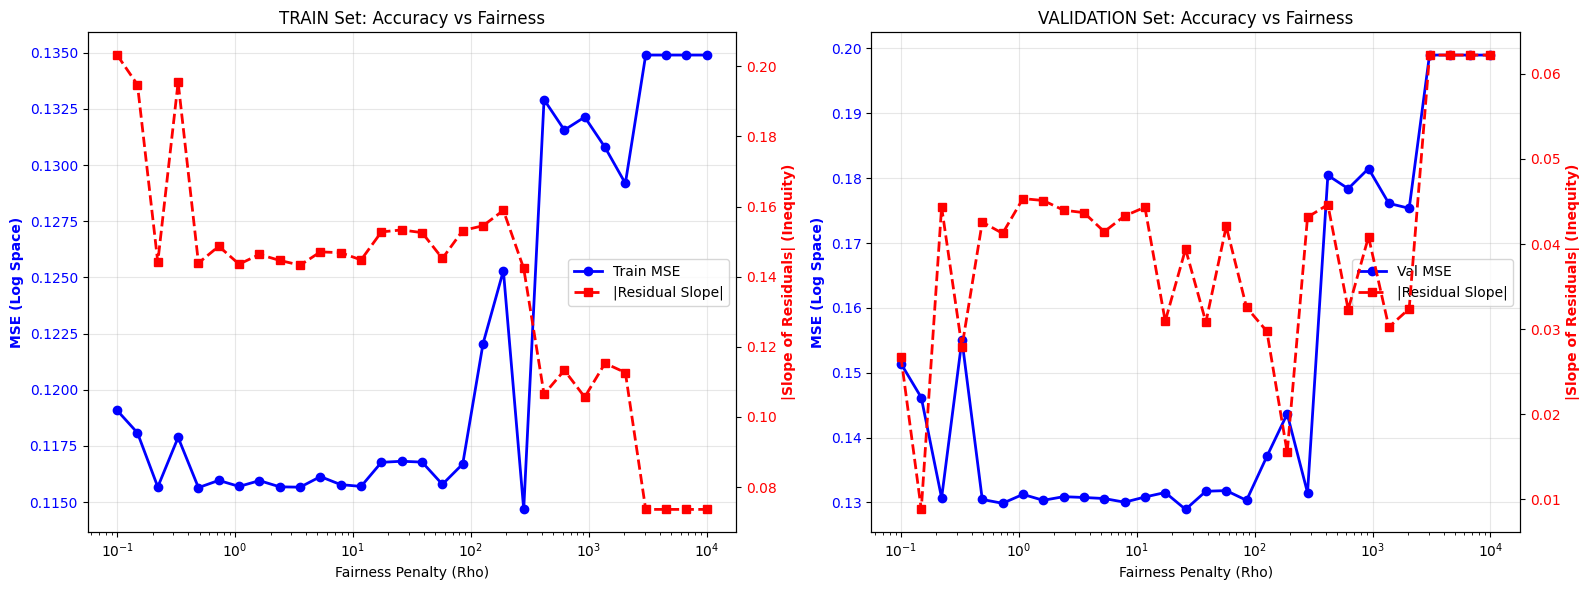

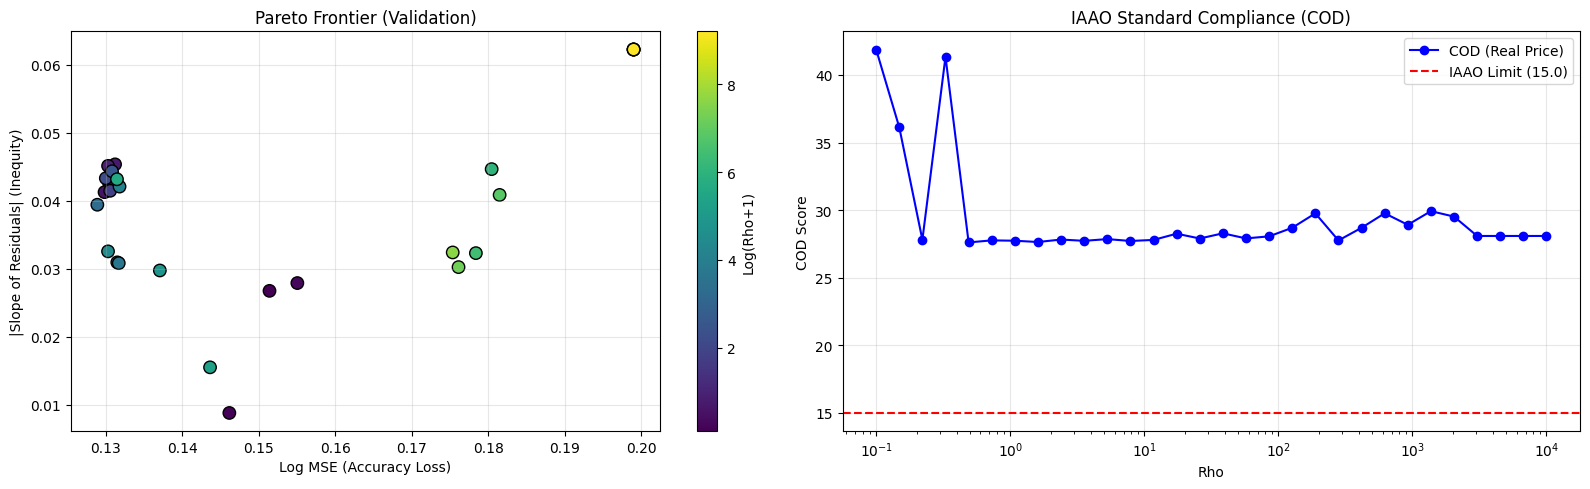


Generating Model Comparison Scatter Plots...


KeyError: 0

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# ==========================================
# 1. The Robust GLM Estimator (Gamma)
# ==========================================
class FairnessConstrainedGLM(BaseEstimator, RegressorMixin):
    """
    Generalized Linear Model (Gamma) with Vertical Equity Constraint.
    
    Objective:
        minimize GammaDeviance(y, exp(Xw)) + alpha*||w||^2 + rho * (Cov(Ratio, y))^2
        
    - Models y = exp(Xw) directly (Log-Link).
    - Minimizes Squared Percentage Error (proxy for COD).
    - Constrains the Covariance of the Ratio (Pred/True) vs True Price.
    """
    
    def __init__(self, alpha=1.0, rho=1.0, fit_intercept=True):
        self.alpha = alpha
        self.rho = rho
        self.fit_intercept = fit_intercept
        
    def _safe_predict(self, X, w):
        """Compute mu = exp(Xw) with numerical safety clipping."""
        eta = X @ w
        # Clip eta to prevent exp(eta) from overflowing. 
        # range [-20, 20] covers prices from $0.001 to $500M safely if scaled/centered
        eta = np.clip(eta, -20, 20) 
        return np.exp(eta)

    def _gamma_loss_and_grad(self, w, X, y):
        """
        Gamma Deviance ~ sum( (y - mu)/mu - log(y/mu) )
        """
        mu = self._safe_predict(X, w)
        
        # Stable Loss: sum( y/mu - log(y/mu) - 1 )
        y_div_mu = y / mu
        loss = np.sum(y_div_mu - np.log(y_div_mu) - 1.0)
        
        # Gradient: X.T * (1 - y/mu)
        grad = X.T @ (1.0 - y_div_mu)
        
        return loss, grad

    def _fairness_penalty_and_grad(self, w, X, y):
        """
        Penalty = rho * (Cov(Ratio, y))^2
        """
        N = len(y)
        mu = self._safe_predict(X, w)
        
        # R = Ratio
        R = mu / y
        
        # Covariance Proxy = mean( R * (y - y_mean) )
        y_mean = np.mean(y)
        y_centered = y - y_mean
        
        cov = np.mean(R * y_centered)
        penalty = self.rho * (cov**2)
        
        # Gradient Derivation:
        # d(Cov)/dw = (1/N) * X.T @ (R * y_centered)
        d_cov_d_w = (X.T @ (R * y_centered)) / N
        grad = 2 * self.rho * cov * d_cov_d_w
        
        return penalty, grad

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)
        N, D = X.shape
        
        # Data Augmentation (Intercept)
        if self.fit_intercept:
            X_aug = np.hstack([X, np.ones((N, 1))])
        else:
            X_aug = X
            
        # --- Initialization (Crucial for GLMs) ---
        # Initialize weights using Ridge on Log(y)
        # This gives the optimizer a "warm start" near the solution
        y_log = np.log(y + 1.0)
        init_ridge = Ridge(alpha=self.alpha, fit_intercept=False)
        init_ridge.fit(X_aug, y_log)
        w_init = init_ridge.coef_
        
        # --- Objective Function ---
        def objective(w):
            # 1. Main Loss (Gamma)
            l_val, l_grad = self._gamma_loss_and_grad(w, X_aug, y)
            
            # 2. L2 Regularization (skip intercept)
            if self.fit_intercept:
                reg_val = self.alpha * np.sum(w[:-1]**2)
                reg_grad = 2 * self.alpha * w
                reg_grad[-1] = 0.0
            else:
                reg_val = self.alpha * np.sum(w**2)
                reg_grad = 2 * self.alpha * w
                
            # 3. Fairness Penalty
            if self.rho > 0:
                f_val, f_grad = self._fairness_penalty_and_grad(w, X_aug, y)
            else:
                f_val, f_grad = 0.0, 0.0
                
            return l_val + reg_val + f_val, l_grad + reg_grad + f_grad

        # Optimize using L-BFGS-B (Handles bounds/smooth gradients well)
        res = minimize(
            objective, 
            w_init, 
            method='L-BFGS-B', 
            jac=True,
            options={'maxiter': 2000, 'ftol': 1e-9}
        )
        
        w_final = res.x
        
        if self.fit_intercept:
            self.coef_ = w_final[:-1]
            self.intercept_ = w_final[-1]
        else:
            self.coef_ = w_final
            self.intercept_ = 0.0
            
        return self

    def predict(self, X):
        check_is_fitted(self, ['coef_', 'intercept_'])
        X = check_array(X)
        eta = X @ self.coef_ + self.intercept_
        return np.exp(np.clip(eta, -20, 20))

# ==========================================
# 2. Path Searcher
# ==========================================
class FairnessPathSearchGLM:
    def __init__(self, rhos, alpha=1.0):
        self.rhos = rhos
        self.alpha = alpha
        self.path_results_ = None
        self.models_ = {}

    def _compute_metrics(self, y_true, y_pred, prefix):
        metrics = {}
        
        # --- Real Space Metrics ---
        # COD (IAAO Standard)
        ratios = y_pred / y_true
        median_ratio = np.median(ratios)
        avg_abs_dev = np.mean(np.abs(ratios - median_ratio))
        cod = (avg_abs_dev / median_ratio) * 100
        metrics[f'{prefix}_cod_real'] = cod
        
        # Log Space Metrics (for slope check)
        # We take log of predictions to compare linearity
        y_true_log = np.log(y_true)
        ratios_log = np.log(ratios) # This is effectively log(pred) - log(true)
        
        # Slope of "Log Ratio" vs "Log Price"
        # Ideally 0. A negative slope means Regressivity.
        slope = np.polyfit(y_true_log, ratios, 1)[0]
        metrics[f'{prefix}_slope_log'] = slope
        
        # MSE (Log Space)
        metrics[f'{prefix}_mse_log'] = np.mean((np.log(y_pred) - np.log(y_true))**2)

        return metrics

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        results = []
        print(f"Starting GLM Path Search over {len(self.rhos)} rho values...")
        
        for rho in self.rhos:
            # Instantiate model (Corrected: No 'loss' argument)
            model = FairnessConstrainedGLM(alpha=self.alpha, rho=rho)
            model.fit(X_train, y_train)
            self.models_[rho] = model
            
            row = {'rho': rho}
            
            # Train
            y_pred_t = model.predict(X_train)
            row.update(self._compute_metrics(y_train, y_pred_t, 'train'))
            
            # Val
            if X_val is not None:
                y_pred_v = model.predict(X_val)
                row.update(self._compute_metrics(y_val, y_pred_v, 'val'))
                
            results.append(row)
            # Progress print
            # print(f"Rho {rho:.0e}: Val COD={row.get('val_cod_real',0):.2f}, Slope={row.get('val_slope_log',0):.4f}")
            
        self.path_results_ = pd.DataFrame(results)
        return self

# ==========================================
# 3. Execution & Plots
# ==========================================
if __name__ == "__main__":
    # # --- A. Generate Synthetic Gamma Data ---
    # np.random.seed(42)
    # N = 1000
    # X_raw = np.random.rand(N, 5)
    
    # # Ground Truth Mean
    # true_log_mean = 10.0 + 2.0 * X_raw[:, 0] + 0.5 * X_raw[:, 1]
    # true_mean = np.exp(true_log_mean)
    
    # # Gamma Noise (Constant CV)
    # shape = 50.0 
    # y = np.random.gamma(shape, true_mean / shape)
    
    # # Introduce Regressive Bias (High value homes under-assessed)
    # bias_factor = 1.0 - 0.15 * (X_raw[:, 0] - 0.5)
    # y_biased = y / bias_factor

    # # Split
    # split = int(0.8 * N)
    # X_train_raw, y_train = X_raw[:split], y_biased[:split]
    # X_val_raw, y_val = X_raw[split:], y_biased[split:]

    # --- B. Scaling (MANDATORY for GLM) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # --- C. Run Search ---
    # Rhos must be large because Covariance^2 is tiny compared to Deviance
    # rhos_to_search = np.linspace(0, 5, 10)#[0, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
    rhos_to_search = np.logspace(-1, 4, 30)

    searcher = FairnessPathSearchGLM(rhos=rhos_to_search, alpha=1e2)
    searcher.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)
    df = searcher.path_results_
    
    # Print Table
    print("\n--- Validation Results ---")
    print(df[['rho', 'val_mse_log', 'val_slope_log', 'val_cod_real']].to_string(float_format="%.4f"))

    # =======================================================
    # PLOT SET 1: Evolution of Metrics (Blue=MSE, Red=Slope)
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Subplot 1: TRAIN ---
    ax_train = axes[0]
    ln1 = ax_train.semilogx(df['rho'], df['train_mse_log'], 'b-o', lw=2, label='Train MSE')
    ax_train.set_xlabel('Fairness Penalty (Rho)')
    ax_train.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_train.tick_params(axis='y', labelcolor='b')
    ax_train.set_title('TRAIN Set: Accuracy vs Fairness')
    ax_train.grid(True, alpha=0.3)

    ax_train_twin = ax_train.twinx()
    ln2 = ax_train_twin.semilogx(df['rho'], df['train_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_train_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_train_twin.tick_params(axis='y', labelcolor='r')
    
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax_train.legend(lns, labs, loc='center right')

    # --- Subplot 2: VALIDATION ---
    ax_val = axes[1]
    ln3 = ax_val.semilogx(df['rho'], df['val_mse_log'], 'b-o', lw=2, label='Val MSE')
    ax_val.set_xlabel('Fairness Penalty (Rho)')
    ax_val.set_ylabel('MSE (Log Space)', color='b', fontweight='bold')
    ax_val.tick_params(axis='y', labelcolor='b')
    ax_val.set_title('VALIDATION Set: Accuracy vs Fairness')
    ax_val.grid(True, alpha=0.3)

    ax_val_twin = ax_val.twinx()
    ln4 = ax_val_twin.semilogx(df['rho'], df['val_slope_log'].abs(), 'r--s', lw=2, label='|Residual Slope|')
    ax_val_twin.set_ylabel('|Slope of Residuals| (Inequity)', color='r', fontweight='bold')
    ax_val_twin.tick_params(axis='y', labelcolor='r')
    
    lns2 = ln3 + ln4
    labs2 = [l.get_label() for l in lns2]
    ax_val.legend(lns2, labs2, loc='center right')

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 2: Pareto Frontier & COD
    # =======================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Trade-off (MSE vs Slope)
    sc = axes[0].scatter(
        df['val_mse_log'], 
        df['val_slope_log'].abs(), 
        c=np.log1p(df['rho']), cmap='viridis', s=80, edgecolors='k'
    )
    plt.colorbar(sc, ax=axes[0], label='Log(Rho+1)')
    axes[0].set_xlabel('Log MSE (Accuracy Loss)')
    axes[0].set_ylabel('|Slope of Residuals| (Inequity)')
    axes[0].set_title('Pareto Frontier (Validation)')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Real Price Metrics (COD vs Rho)
    axes[1].semilogx(df['rho'], df['val_cod_real'], 'b-o', label='COD (Real Price)')
    axes[1].axhline(15.0, color='red', linestyle='--', label='IAAO Limit (15.0)')
    axes[1].set_xlabel('Rho')
    axes[1].set_ylabel('COD Score')
    axes[1].set_title('IAAO Standard Compliance (COD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =======================================================
    # PLOT SET 3: Model Comparison Scatters
    # =======================================================
    print("\nGenerating Model Comparison Scatter Plots...")
    
    # Pick models: Base (0) and Strong Fairness (Max Rho)
    models_to_plot = [
        searcher.models_[0],
        searcher.models_[rhos_to_search[-1]]
    ]
    labels = ["Standard Gamma GLM", f"Fair Gamma GLM (rho={rhos_to_search[-1]:.0e})"]

    for model, label in zip(models_to_plot, labels):
        # 1. Predict
        y_pred = model.predict(X_val_scaled)
        ratios = y_pred / y_val
        y_val_log = np.log(y_val)

        # 2. Setup Plot
        plt.figure(figsize=(9, 6))
        
        # Scatter points
        plt.scatter(y_val_log, ratios, 
            facecolors='none', 
            edgecolors='black', 
            s=50, 
            alpha=0.3,
            label='Properties'
        )
        
        # --- Grid & Reference ---
        plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Equity (1.0)')

        # --- Tendency Line (Lowess) ---
        lowess = sm.nonparametric.lowess(ratios, y_val_log, frac=0.4)
        plt.plot(lowess[:, 0], lowess[:, 1], color='blue', linewidth=3, label='Trend (Lowess)')
        
        # --- Linear Trend ---
        z = np.polyfit(y_val_log, ratios, 1)
        p = np.poly1d(z)
        plt.plot(y_val_log, p(y_val_log), "g-", alpha=0.6, linewidth=1.5, label=f'Linear Slope={z[0]:.4f}')

        # Formatting
        plt.ylabel("Assessment Ratio (AV / MV)")
        plt.xlabel("Log Market Value")
        plt.title(f"{label}\nSlope should be close to 0")
        plt.legend(loc='upper right')
        plt.ylim(0, 3) 
        plt.show()

---

# Simple regression

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train_log)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

print("train RMSE: ", root_mean_squared_error(y_train_log, y_pred_train) )

print(r"$R^2$ in Train: ",r2_score(y_pred_train, y_train_log))
print(r"$R^2$ in Val: ",r2_score(y_pred_val, y_val_log))
# print(r"$R^2$ in Test: ",r2_score(y_pred_test, y_test_log))
print("-"*100)
print("Residual = (y - X'b)")
print("Max residual Train: ", np.max(y_train_log - y_pred_train))
print("Min residual Train: ", np.min(y_train_log - y_pred_train))
print("Avg residual Train: ", np.mean(y_train_log - y_pred_train))
print("Median residual Train: ", np.median(y_train_log - y_pred_train))
print("-"*100)
print("Max residual Val: ", np.max(y_val_log - y_pred_val))
print("Min residual Val: ", np.min(y_val_log - y_pred_val))
print("Avg residual Val: ", np.mean(y_val_log - y_pred_val))
print("Median residual Val: ", np.median(y_val_log - y_pred_val))



train RMSE:  0.22464198644633118
$R^2$ in Train:  0.9171738754466998
$R^2$ in Val:  0.5959780770426828
----------------------------------------------------------------------------------------------------
Residual = (y - X'b)
Max residual Train:  1.2677712231440221
Min residual Train:  -1.541880789209097
Avg residual Train:  -1.430789490495532e-12
Median residual Train:  0.005660579426979062
----------------------------------------------------------------------------------------------------
Max residual Val:  1.7194012051112963
Min residual Val:  -1.26593576566105
Avg residual Val:  0.14254907794719615
Median residual Val:  0.15715061021534016


In [ ]:
def analyze_fairness_by_value(
    y_pred_log: Union[np.ndarray, pd.Series],
    y_real: Union[np.ndarray, pd.Series],
    tax_rate: float = 1.9/100,
    num_groups: int = 3,
) -> pd.DataFrame:
    """
    Analyzes regression model performance with a focus on fairness across value groups.

    This function is designed to highlight how a model that regresses to the mean
    can be unfair by systematically over-predicting low-value items and
    under-predicting high-value items.

    Args:
        y_pred_log: Model predictions in log scale (e.g., log(price)).
        y_real: The true target values in the original scale (e.g., price).
        tax_rate: The tax rate to be applied to the predicted price (e.g., 0.05 for 5%).
        num_groups: The number of equally spaced bins to cut the real values into.

    Returns:
        A pandas DataFrame containing a detailed summary of performance and fairness
        metrics for the overall dataset and for each value-based subgroup.
    """
    if not isinstance(y_pred_log, pd.Series):
        y_pred_log = pd.Series(y_pred_log, name="y_pred_log")
    else:
        y_pred_log = y_pred_log.reset_index()[0]
    if not isinstance(y_real, pd.Series):
        y_real = pd.Series(y_real, name="y_real")
    else:
        y_real = y_real.reset_index()["meta_sale_price"]
    
        
    # --- 1. Data Preparation ---
    # Convert log predictions back to the original price scale
    y_pred = np.exp(y_pred_log)

    print("Average of residuals ", np.mean(y_pred - y_real) )

    # Create a base DataFrame for analysis
    df = pd.DataFrame({
        'y_real': y_real,
        'y_real_log': np.log(y_real),
        'y_pred': y_pred
    })
    df.dropna(inplace=True)

    # --- 2. Helper function to compute statistics for any data slice ---
    def _compute_statistics(data_slice: pd.DataFrame) -> dict:
        """Computes all desired metrics for a given subset of data."""
        if data_slice.empty:
            return {}

        # Calculate residuals and tax differences
        residual = data_slice['y_pred'] - data_slice['y_real']
        pct_residual = residual / data_slice['y_real']
        tax_difference = residual * tax_rate

        # Separate overcharged and undercharged samples for specific stats
        overcharged_pct = pct_residual[residual > 0]
        undercharged_pct = pct_residual[residual < 0]

        stats = {
            # --- General & Error Metrics ---
            'count': len(data_slice),
            'avg real price': data_slice['y_real'].mean(),
            'rmse': np.sqrt(np.mean(residual**2)),
            'mae': np.mean(np.abs(residual)),

            # --- Residual Analysis ($) ---
            r'avg residual (\$)': residual.mean(),
            r'median residual (\$)': residual.median(),
            r'most overcharged (\$)': residual.max(),
            r'most undercharged (\$)': residual.min(),

            # --- Residual Analysis (%) ---
            r'highest overcharge (\%)': pct_residual.max() * 100,
            r'highest undercharge (\%)': pct_residual.min() * 100,
            r'avg overcharge (\%)': overcharged_pct.mean() * 100 if not overcharged_pct.empty else 0,
            r'avg undercharg (\%)': undercharged_pct.mean() * 100 if not undercharged_pct.empty else 0,


            # --- Fairness & Bias Metrics ---
            r'count overcharged': (residual > 0).sum(),
            r'count undercharged': (residual < 0).sum(),
            r'total tax diff (\$)': tax_difference.sum(),
            r'avg tax overpayment (\$)': tax_difference[tax_difference > 0].mean(),
            r'avg tax underpayment (\$)': tax_difference[tax_difference < 0].mean(),
        }
        return stats

    # --- 3. Perform Analysis ---
    all_stats = []

    # Analyze the entire dataset first
    overall_stats = _compute_statistics(df)
    overall_stats['group'] = 'Overall'
    all_stats.append(overall_stats)

    # Create value-based groups using uniform cuts
    group_labels = [f'Group {i+1}' for i in range(num_groups)]
    try:
        df['value_group'] = pd.cut(
            df['y_real_log'],
            bins=num_groups,
            labels=group_labels,
            include_lowest=True
        )
        has_groups = True
    except ValueError:
        # This can happen if there are not enough unique values to create bins
        print(f"Warning: Could not create {num_groups} bins from y_real. Skipping group analysis.")
        has_groups = False

    # Analyze each group
    if has_groups:
        for group_name in group_labels:
            group_df = df[df['value_group'] == group_name]
            if not group_df.empty:
                group_stats = _compute_statistics(group_df)
                group_stats['group'] = group_name
                all_stats.append(group_stats)

    # --- 4. Format and Return Results ---
    results_df = pd.DataFrame(all_stats).set_index('group')
    
    # Format for better readability
    pd.options.display.float_format = '{:,.2f}'.format
    format_cols_pct = [col for col in results_df.columns if '%' in col]
    format_cols_money = [col for col in results_df.columns if '$' in col]
    
    for col in format_cols_pct:
        results_df[col] = results_df[col].apply(lambda x: fr"{x:,.2f}\%")
    for col in format_cols_money:
        results_df[col] = results_df[col].apply(lambda x: fr"\${x:,.2f}")
        
    return results_df


# Summary
train_summary = analyze_fairness_by_value(
    y_pred_train,
    y_train,
    tax_rate=1.9/100,
    num_groups= 3,
)

val_summary = analyze_fairness_by_value(
    y_pred_val,
    y_val,
    tax_rate=1.9/100,
    num_groups= 3,
)


display(train_summary.T)#.to_latex(float_format="%.2f"))
display(val_summary.T)#.to_latex(float_format="%.2f")))

# print(train_summary.T.to_latex(float_format="%.2f"))
# print(val_summary.T.to_latex(float_format="%.2f"))


Average of residuals  -3216.9360954242015
Average of residuals  -61226.824572717705


group                            Overall       Group 1        Group 2  \
count                                862            71            566   
avg real price                329,858.57     44,977.69     228,767.10   
rmse                           70,215.39     27,701.33      45,019.30   
mae                            45,150.93     17,250.04      33,443.15   
avg residual (\$)            \$-3,216.94   \$13,756.33      \$-573.15   
median residual (\$)           \$-858.56    \$9,912.15    \$-1,971.28   
most overcharged (\$)       \$302,113.16  \$146,934.87   \$229,217.42   
most undercharged (\$)     \$-661,058.43  \$-24,596.17  \$-127,362.24   
highest overcharge (\%)         367.34\%      367.34\%       133.68\%   
highest undercharge (\%)        -71.85\%      -39.25\%       -53.00\%   
avg overcharge (\%)              19.93\%       49.10\%        17.03\%   
avg undercharg (\%)             -13.91\%      -15.20\%       -14.10\%   
count overcharged                    423            54            270   
count undercharged                   439            17            296   
total tax diff (\$)         \$-52,686.98   \$18,557.29    \$-6,163.60   
avg tax overpayment (\$)        \$811.81      \$387.29       \$654.60   
avg tax underpayment (\$)      \$-902.24     \$-138.62      \$-617.92   

group                            Group 3  
count                                225  
avg real price                674,055.52  
rmse                          116,394.30  
mae                            83,406.80  
avg residual (\$)           \$-15,223.55  
median residual (\$)        \$-11,215.13  
most overcharged (\$)       \$302,113.16  
most undercharged (\$)     \$-661,058.43  
highest overcharge (\%)          45.32\%  
highest undercharge (\%)        -71.85\%  
avg overcharge (\%)              11.92\%  
avg undercharg (\%)             -13.27\%  
count overcharged                     99  
count undercharged                   126  
total tax diff (\$)         \$-65,080.66  
avg tax overpayment (\$)      \$1,472.14  
avg tax underpayment (\$)    \$-1,673.19

group                              Overall       Group 1        Group 2  \
count                                  138            11            101   
avg real price                  408,917.32     73,181.82     312,743.96   
rmse                            191,253.86     50,251.18      97,495.71   
mae                             119,588.89     37,776.00      75,863.28   
avg residual (\$)             \$-61,226.82   \$13,304.53   \$-19,080.30   
median residual (\$)          \$-40,821.99    \$3,723.82   \$-33,383.67   
most overcharged (\$)         \$452,773.73  \$101,856.39   \$334,836.85   
most undercharged (\$)     \$-1,017,977.10  \$-74,899.23  \$-247,453.27   
highest overcharge (\%)           254.64\%      254.64\%       134.19\%   
highest undercharge (\%)          -82.08\%      -74.90\%       -82.08\%   
avg overcharge (\%)                39.73\%       74.58\%        33.63\%   
avg undercharg (\%)               -25.99\%      -40.02\%       -22.01\%   
count overcharged                       43             7             32   
count undercharged                      95             4             69   
total tax diff (\$)          \$-160,536.73    \$2,780.65   \$-36,615.09   
avg tax overpayment (\$)        \$1,779.36      \$762.56     \$1,702.60   
avg tax underpayment (\$)      \$-2,495.26     \$-639.32    \$-1,320.27   

group                              Group 3  
count                                   26  
avg real price                  924,555.77  
rmse                            395,160.43  
mae                             324,059.18  
avg residual (\$)            \$-256,482.36  
median residual (\$)         \$-186,351.19  
most overcharged (\$)         \$452,773.73  
most undercharged (\$)     \$-1,017,977.10  
highest overcharge (\%)            51.75\%  
highest undercharge (\%)          -69.49\%  
avg overcharge (\%)                27.56\%  
avg undercharg (\%)               -35.94\%  
count overcharged                        4  
count undercharged                      22  
total tax diff (\$)          \$-126,702.29  
avg tax overpayment (\$)        \$4,172.87  
avg tax underpayment (\$)      \$-6,517.90

In [12]:
import cvxpy as cp
import gurobipy as gp
import numpy as np

# Simple variations of Linear Models
class PercentageMAERegression:
    def __init__(self, fit_intercept=True):
        self.beta = None
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X, y = X.to_numpy(), y.to_numpy()
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        n, m = X.shape
        M = 1e4

        dual = False

        if dual:
            # CVXPY DUAL APPROACH
            theta = cp.Variable(n)
            constraints = [
                theta <= 1,
                theta >= -1
            ]
            beta=[X.T @ theta == 0]


            # Objective: Minimize the overall Mean Absolute Error
            obj = cp.Maximize(y @ theta)
            # obj = cp.Minimize(cp.mean(cp.log(z + self.tau)))
            prob = cp.Problem(obj, 
                            constraints+beta
                            )

            # Solve the optimization problem
            try:
                result = prob.solve(solver=cp.GUROBI, verbose=True)
            except cp.error.SolverError:
                print("GUROBI not available, trying default solver.")
                result = prob.solve(verbose=False)


            print(f"Problem status: {prob.status}")
            print(f"Optimal objective (Mean Absolute Error): {result}")


            # Print the difference in MAE between groups post-optimization
            if prob.status in ["optimal", "optimal_inaccurate"]:
                # self.beta = beta.value
                print(beta[0].dual_value)
                self.beta = beta[0].dual_value
            else:
                print("Solver did not find an optimal solution. Beta coefficients not set.")
                self.beta = np.zeros(m) # Fallback beta

        else:

            # PRIMAL CONSTRAINED APPROACH
            # optimal_mae = 1.324e+02
            optimal_rmse = 0.22464198644633118
            loss_rate = 0.0
            rmse_bound = (1+loss_rate)*optimal_rmse*np.sqrt(n)

            beta = cp.Variable(m)
            u,l = cp.Variable(1), cp.Variable(1)
            r = y - X @ beta
            constraints = [
                r <= u,
                -r <= u,
                r >= l,
                -r >= l,
            ]
            soc = [
                cp.SOC(rmse_bound, r)
            ]


            # Objective: Minimize the overall Mean Absolute Error
            obj = cp.Minimize(u - l)
            # obj = cp.Minimize(cp.mean(cp.log(z + self.tau)))
            prob = cp.Problem(obj, 
                            constraints+soc
                            )

            # Solve the optimization problem
            try:
                # result = prob.solve(solver=cp.GUROBI, verbose=True, warm_start=True)
                result = prob.solve(solver=cp.MOSEK, verbose=True, warm_start=True)
            except cp.error.SolverError:
                print("GUROBI not available, trying default solver.")
                result = prob.solve(verbose=False, warm_start=True)


            print(f"Problem status: {prob.status}")
            print(f"Optimal objective (Mean Absolute Error): {result}")


            # Print the difference in MAE between groups post-optimization
            if prob.status in ["optimal", "optimal_inaccurate"]:
                self.beta = beta.value
            else:
                print("Solver did not find an optimal solution. Beta coefficients not set.")
                self.beta = np.zeros(m) # Fallback beta

        
        return result

    def predict(self, X):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X @ self.beta
    
    def __str__(self):
        return f"PercentageMAERegression(fit_intercept={self.fit_intercept})"


In [13]:
model = PercentageMAERegression(fit_intercept=True)
model.fit(X_train, y_train_log)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

print(r"$R^2$ in Train: ",r2_score(y_pred_train, y_train_log))
print(r"$R^2$ in Val: ",r2_score(y_pred_val, y_val_log))
print(r"$R^2$ in Test: ",r2_score(y_pred_test, y_test_log))

(CVXPY) Oct 03 02:32:43 PM: Your problem has 152 variables, 3449 constraints, and 0 parameters.
(CVXPY) Oct 03 02:32:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 03 02:32:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 03 02:32:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 03 02:32:43 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 03 02:32:43 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 03 02:32:43 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Oct 03 02:32:43 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 03 02:32:43 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 03 02:32:43 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Oct 03 02:32:44 PM: Applying reduction MOSEK
(CVXPY) Oct 03 02:32:44 PM: Finished problem compilation (took 6.992e-01 seconds).
(CVXPY) Oct 03 02:32:44 PM: Invoking solver MOSEK  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------




(CVXPY) Oct 03 02:32:44 PM: Problem
(CVXPY) Oct 03 02:32:44 PM:   Name                   :                 
(CVXPY) Oct 03 02:32:44 PM:   Objective sense        : maximize        
(CVXPY) Oct 03 02:32:44 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Oct 03 02:32:44 PM:   Constraints            : 152             
(CVXPY) Oct 03 02:32:44 PM:   Affine conic cons.     : 0               
(CVXPY) Oct 03 02:32:44 PM:   Disjunctive cons.      : 0               
(CVXPY) Oct 03 02:32:44 PM:   Cones                  : 1               
(CVXPY) Oct 03 02:32:44 PM:   Scalar variables       : 4311            
(CVXPY) Oct 03 02:32:44 PM:   Matrix variables       : 0               
(CVXPY) Oct 03 02:32:44 PM:   Integer variables      : 0               
(CVXPY) Oct 03 02:32:44 PM: 
(CVXPY) Oct 03 02:32:44 PM: Optimizer started.
(CVXPY) Oct 03 02:32:44 PM: Presolve started.
(CVXPY) Oct 03 02:32:44 PM: Linear dependency checker started.
(CVXPY) Oct 03 02:32:44 PM: Linear depend

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Problem status: optimal
Optimal objective (Mean Absolute Error): 3.0835109748723584
$R^2$ in Train:  0.9171739172652961
$R^2$ in Val:  0.5931873895358566
$R^2$ in Test:  0.45182106814267153


In [29]:
# Summary
train_summary = analyze_fairness_by_value(
    y_pred_train,
    y_train,
    tax_rate=1.9/100,
    num_groups= 3,
)

val_summary = analyze_fairness_by_value(
    y_pred_val,
    y_val,
    tax_rate=1.9/100,
    num_groups= 3,
)


display(train_summary.T)#.to_latex(float_format="%.2f"))
display(val_summary.T)#.to_latex(float_format="%.2f")))


Average of residuals  -3217.234550277693
Average of residuals  -61127.05163356126


group                            Overall       Group 1        Group 2  \
count                                862            71            566   
avg real price                329,858.57     44,977.69     228,767.10   
rmse                           70,215.89     27,699.66      45,019.44   
mae                            45,151.03     17,249.71      33,443.28   
avg residual (\$)            \$-3,217.23   \$13,755.91      \$-573.12   
median residual (\$)           \$-858.23    \$9,911.79    \$-1,971.55   
most overcharged (\$)       \$302,104.41  \$146,911.43   \$229,219.60   
most undercharged (\$)     \$-661,072.82  \$-24,596.56  \$-127,362.02   
highest overcharge (\%)         367.28\%      367.28\%       133.68\%   
highest undercharge (\%)        -71.86\%      -39.25\%       -53.00\%   
avg overcharge (\%)              20.02\%       49.10\%        17.09\%   
avg undercharg (\%)             -13.84\%      -15.20\%       -14.06\%   
count overcharged                    421            54            269   
count undercharged                   441            17            297   
total tax diff (\$)         \$-52,691.87   \$18,556.72    \$-6,163.34   
avg tax overpayment (\$)        \$815.67      \$387.28       \$657.04   
avg tax underpayment (\$)      \$-898.16     \$-138.62      \$-615.85   

group                            Group 3  
count                                225  
avg real price                674,055.52  
rmse                          116,395.44  
mae                            83,406.94  
avg residual (\$)           \$-15,224.62  
median residual (\$)        \$-11,215.96  
most overcharged (\$)       \$302,104.41  
most undercharged (\$)     \$-661,072.82  
highest overcharge (\%)          45.32\%  
highest undercharge (\%)        -71.86\%  
avg overcharge (\%)              12.04\%  
avg undercharg (\%)             -13.17\%  
count overcharged                     98  
count undercharged                   127  
total tax diff (\$)         \$-65,085.25  
avg tax overpayment (\$)      \$1,487.14  
avg tax underpayment (\$)    \$-1,660.04

group                              Overall       Group 1        Group 2  \
count                                  138            11            101   
avg real price                  408,917.32     73,181.82     312,743.96   
rmse                            191,858.44     50,251.80      98,057.93   
mae                             119,987.23     37,776.42      76,203.27   
avg residual (\$)             \$-61,127.05   \$13,304.67   \$-18,740.04   
median residual (\$)          \$-40,822.13    \$3,723.91   \$-33,384.37   
most overcharged (\$)         \$452,791.25  \$101,857.63   \$334,845.46   
most undercharged (\$)     \$-1,017,983.01  \$-74,899.56  \$-247,450.98   
highest overcharge (\%)           254.64\%      254.64\%       134.20\%   
highest undercharge (\%)          -82.08\%      -74.90\%       -82.08\%   
avg overcharge (\%)                40.00\%       74.58\%        33.98\%   
avg undercharg (\%)               -26.02\%      -40.02\%       -22.01\%   
count overcharged                       43             7             32   
count undercharged                      95             4             69   
total tax diff (\$)          \$-160,275.13    \$2,780.68   \$-35,962.14   
avg tax overpayment (\$)        \$1,794.55      \$762.57     \$1,723.00   
avg tax underpayment (\$)      \$-2,499.38     \$-639.32    \$-1,320.26   

group                              Group 3  
count                                   26  
avg real price                  924,555.77  
rmse                            396,174.22  
mae                             324,852.57  
avg residual (\$)            \$-257,274.63  
median residual (\$)         \$-186,346.60  
most overcharged (\$)         \$452,791.25  
most undercharged (\$)     \$-1,017,983.01  
highest overcharge (\%)            51.75\%  
highest undercharge (\%)          -69.49\%  
avg overcharge (\%)                27.56\%  
avg undercharg (\%)               -36.06\%  
count overcharged                        4  
count undercharged                      22  
total tax diff (\$)          \$-127,093.67  
avg tax overpayment (\$)        \$4,172.94  
avg tax underpayment (\$)      \$-6,535.70

In [61]:
import numpy as np
import pandas as pd
from numpy.linalg import pinv
from sklearn.impute import KNNImputer
from sklearn.metrics import nan_euclidean_distances

def create_nan_mahalanobis_metric(X, cov_regularizer=1e-5):
    """
    Creates a callable NaN-robust Mahalanobis distance metric.

    This factory function pre-computes the inverse covariance matrix from the
    provided data `X`, handling missing values. The returned metric can then be
    used as a callable with scikit-learn's KNNImputer.

    Args:
        X (np.ndarray or pd.DataFrame): The data (n_samples, n_features) used to
            compute the covariance matrix. May contain NaNs.

    Returns:
        callable: A distance function `metric(u, v)` that computes the
                  Mahalanobis distance between 1-D arrays `u` and `v`,
                  robustly handling NaNs.
    """
    # Use pandas to compute pairwise covariance, which handles NaNs
    if isinstance(X, np.ndarray):
        df = pd.DataFrame(X)
    else:
        df = X.copy()

    cov_matrix = np.cov(df, rowvar=False) #.cov().to_numpy()
    cov_matrix += cov_regularizer * np.eye(df.shape[1])
    
    # Fallback for any NaNs remaining in the covariance matrix
    if np.isnan(cov_matrix).any():
        cov_matrix = np.nan_to_num(cov_matrix)

    # Use the pseudo-inverse for numerical stability
    inv_cov_matrix = pinv(cov_matrix)
    n_total_features = X.shape[1]

    def nan_mahalanobis_distance(u, v, missing_values=np.nan):
        """
        Computes the NaN-robust Mahalanobis distance between two vectors.
        This function is designed to be a metric for sklearn's KNNImputer.
        """
        u = np.asarray(u)
        v = np.asarray(v)
        
        # print("u", u)
        # print("v", v)
        # for u_i in u:
        #     for v_i in v:

        # Find features where both vectors are non-NaN
        mask = ~np.isnan(u) & ~np.isnan(v)
        n_common_features = np.sum(mask)

        # If no common features, distance is 0 (consistent with nan_euclidean)
        if n_common_features == 0:
            return 0.0

        # Subset vectors and the inverse covariance matrix to common features
        u_common = u[mask]
        v_common = v[mask]
        inv_cov_subset = inv_cov_matrix[np.ix_(mask, mask)]
        
        # Calculate the Mahalanobis distance in the subspace of common features
        diff = u_common - v_common
        dist_sq = diff.T @ inv_cov_subset @ diff

        # Scale the distance to account for the reduced number of features
        scaled_dist_sq = dist_sq * (n_total_features / n_common_features)

        return np.sqrt(scaled_dist_sq)

    return nan_mahalanobis_distance

In [62]:
# for col in df:
#     if col not in ["meta_sale_date"]:
#         print("-"*50)
#         print(col)
#         print(df[col].unique())


# # X_sample["char_type_resd"]

In [63]:
# [PENDING]
# # Impute the missing data with less than 10k missing values
# # from src.imputation import robust_nan_mahalanobis
# X_sample = X_train.sample(10000)
# nan_mahalanobis_metric = create_nan_mahalanobis_metric(X_sample)
# imputer = KNNImputer(n_neighbors=5, metric=nan_mahalanobis_metric, weights="distance")
# # imputer.fit(X_train)
# X_train_imputed = imputer.fit_transform(X_sample)
# # X_test_imputed = imputer.fit_transform(X_test.sample(10000))
# X_train_imputed.isna.sum()


# Fake NA fix
df_train = pd.concat([X_train, y_train], axis=1).dropna()
df_test = pd.concat([X_test, y_test], axis=1).dropna()
X_train, X_test = df_train.drop(columns=y.name), df_test.drop(columns=y.name)
y_train, y_test = df_train[y.name], df_test[y.name]


X_train = X_train.apply(pd.to_numeric, errors='raise')
X_test = X_test.apply(pd.to_numeric, errors='raise')

print(X_train.shape, X_test.shape)

(260817, 2927) (133926, 2927)


In [64]:
# import numpy as np

# Metrics

def mean_deviation(x, base_level=1):
    return np.mean(np.abs(x - 1))



# Haihao's metrics



def positive_part(x):
    x[x < 0] = 0
    return x

def quantiles_price(y):
    m = y.size
    y_tilde = y.copy()
    for i,x in enumerate(y):
        y_tilde[i] = np.sum(x >= y) # N_x
    return y_tilde / m



def F_dev(r, y_quants, alpha=2, base_level=1):
    w1 = lambda x: np.exp(-alpha * x)
    w2 = lambda x: np.exp(-alpha * (1-x))
    sum_r_1_pos = positive_part(r - base_level) @ w1(y_quants)
    sum_1_r_pos = positive_part(base_level - r) @ w2(y_quants)
    
    return sum_r_1_pos + sum_1_r_pos


def get_groups_from_quants(y, y_quants, n_groups=3):
    bounds = np.linspace(0,1,n_groups+1)
    # print(bounds[1:])
    groups = dict()
    if n_groups > 1:
        lb = bounds[0]
        for i,ub in enumerate(bounds[1:]):
            # print(lb, ub)

            groups[i] = np.where((lb < y_quants) & (y_quants <= ub))[0]
            lb = ub # update bound
        # print(groups)
    else:
        groups[0] = np.where(y_quants <= float("inf"))[0]

    return groups
    # groups = {}
    # for i, y_i in enumerate(y):


def F_grp(r, groups):
    score = 0
    for g1 in groups:
        for g2 in groups:
            if g1 < g2:
                m_g1 = len(groups[g1])
                m_g2 = len(groups[g2])
                score+=1/m_g1/m_g2*np.sum(positive_part(r[groups[g1], np.newaxis] - r[groups[g2]]))
                # for i in groups[g1]:
                #     score+= np.sum(positive_part(r[i] - r[groups[g2]]))
                # print(groups[g1])
                # print(groups[g2])
                # positive_part(r[0] - r[1])
                # print([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]])
                # print(np.sum([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]]))
                # score+= 1/m_g1/m_g2*np.sum([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]])
    return score


def compute_haihao_F_metrics(r, y, n_groups=3, alpha=2):
    # Get the quantiles
    y_quants = quantiles_price(y.to_numpy())
    # First metric: F_dev
    f_dev = F_dev(r, y_quants, alpha=alpha)
    groups = get_groups_from_quants(y.to_numpy(), y_quants, n_groups)
    f_grp = F_grp(r.to_numpy(), groups)
    return {"f_dev":f_dev , "f_grp":f_grp}




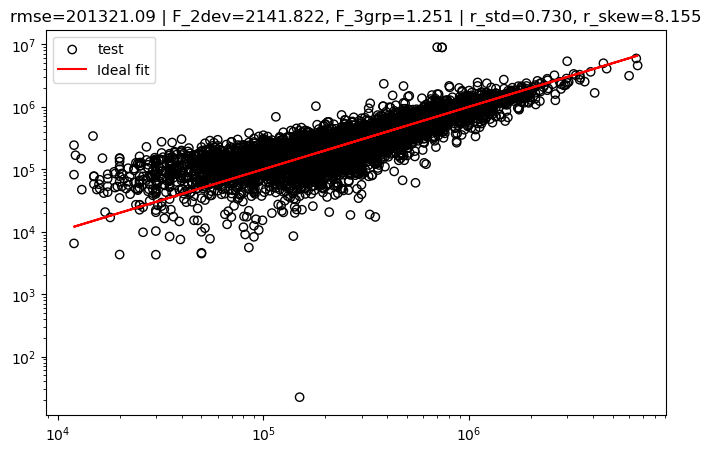

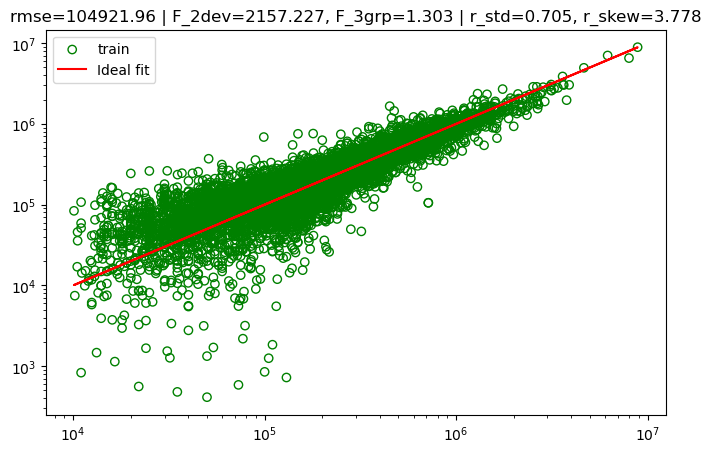

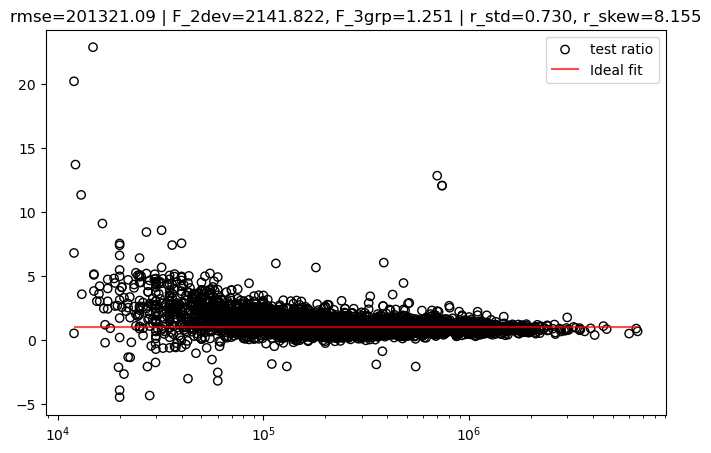

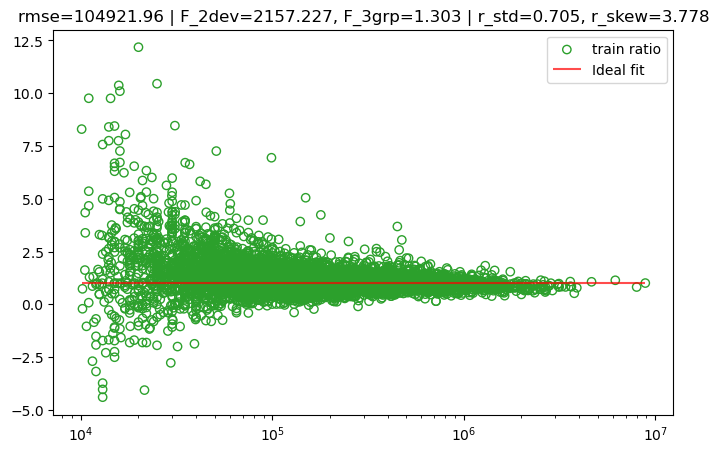

In [65]:
# Sample data
sample_size = 10000
X_train_sample, X_test_sample = X_train.sample(sample_size, random_state=42), X_test.sample(sample_size, random_state=42)
y_train_sample, y_test_sample = y_train.loc[X_train_sample.index], y_test.loc[X_test_sample.index] 

# print("Shapes")
# print(X_train_sample

# for thresh in [0.15,] # Small enough: 0,03 , 3 , 0,3
model = LinearRegression()#UpperBoundLossRegression(delta=0.01, n_groups=5, deviation_thresh=1e10)#ConstraintBothRegression(delta=10, n_groups=5, deviation_thresh=10)# UpperBoundLossRegression(delta=.5, n_groups=1, deviation_thresh=.25)#LinearRegression()#ConstraintBothRegression(delta=10, n_groups=11, deviation_thresh=.5)#ConstraintGroupsMeanRegression(delta=0.01, n_groups=3)####ConstraintDeviationRegression(deviation_thresh=0.47)#
model.fit(X_train_sample, y_train_sample)
y_pred_train = model.predict(X_train_sample) 
y_pred = model.predict(X_test_sample)

# ratio
r_pred = y_pred / y_test_sample
r_pred_train = y_pred_train / y_train_sample



n_groups = 3
alpha = 2
f_metrics = compute_haihao_F_metrics(r_pred, y_test_sample, n_groups=n_groups, alpha=alpha)
f_dev, f_grp = f_metrics["f_dev"], f_metrics["f_grp"]

f_metrics_train = compute_haihao_F_metrics(r_pred_train, y_train_sample, n_groups=n_groups)
f_dev_train, f_grp_train = f_metrics_train["f_dev"], f_metrics_train["f_grp"]


# Plots general setting
log_scale = True

# Plot real data v/s predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test_sample,y_pred, facecolor='none', label="test", color="black")
plt.plot(y_test_sample, y_test_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred):.3f}
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()



plt.figure(figsize=(8,5))
plt.scatter(y_train_sample,y_pred_train, facecolor='none', label="train", color="green")
plt.plot(y_train_sample, y_train_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred_train):.3f}, 
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()

# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_test_sample,r_pred, facecolor='none', label="test ratio", color="black")
plt.hlines(1, np.min(y_test_sample), np.max(y_test_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()


# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_train_sample, r_pred_train, facecolor='none', label="train ratio", color="C2")
plt.hlines(1, np.min(y_train_sample), np.max(y_train_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()

# Visualizing the outliers on the prediction plot

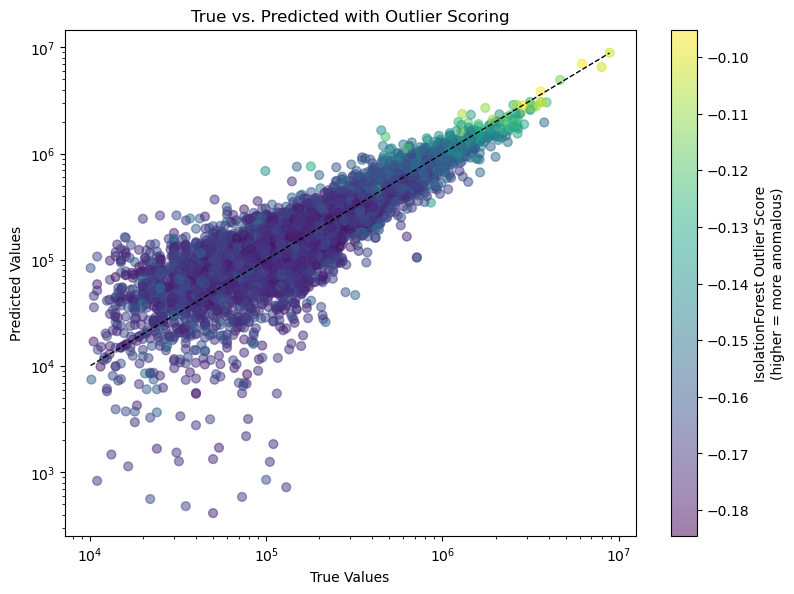

In [67]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# ── 1. Assume you already have:
#    X_train, X_test : feature matrices
#    y_train, y_test : true targets
#    y_pred_train, y_pred_test : model predictions on train/test

# Example placeholders (remove these in your actual code)
# X_train, X_test = np.random.rand(100, 5), np.random.rand(50, 5)
# y_train, y_test = np.random.rand(100), np.random.rand(50)
# y_pred_train, y_pred_test = y_train + 0.1*np.random.randn(100), y_test + 0.1*np.random.randn(50)

# ── 2. Fit the Isolation Forest on training features
iso = IsolationForest(
    n_estimators=1000,
    contamination='auto',  # or a float like 0.05 if you know the expected outlier fraction
    # behaviour='new',       # for newest scikit‑learn versions; remove if deprecated
    random_state=42
)
iso.fit(X_train_sample)

# ── 3. Compute outlier scores
# decision_function returns higher = more “inlier”-like, so we invert it:
score_train = -iso.decision_function(X_train_sample)
# score_test  = -iso.decision_function(X_test)

# # ── 4. Combine train and test for a single scatter (optional)
# y_true_all = np.concatenate([y_train, y_test])
# y_pred_all = np.concatenate([y_pred_train, y_pred_test])
# score_all  = np.concatenate([score_train, score_test])

# ── 5. Plot true vs. predicted with colorbar for outlier score
plt.figure(figsize=(8,6))
sc = plt.scatter(
    y_train_sample, 
    y_pred_train, 
    c=score_train, 
    cmap='viridis', 
    s=40,        # marker size
    alpha=0.5    # slight transparency
)
plt.plot([y_train_sample.min(), y_train_sample.max()],
         [y_train_sample.min(), y_train_sample.max()],
         'k--', lw=1)  # 45° line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
cbar = plt.colorbar(sc)
cbar.set_label('IsolationForest Outlier Score\n(higher = more anomalous)')
plt.title('True vs. Predicted with Outlier Scoring')
plt.tight_layout()
plt.xscale("log")
plt.yscale("log")
plt.show()


(array([ 368.,  710., 1210.,    0.,    0., 2875.,    0.,    0.,    0.,
        4837.]),
 array([   5. ,  488.2,  971.4, 1454.6, 1937.8, 2421. , 2904.2, 3387.4,
        3870.6, 4353.8, 4837. ]),
 <BarContainer object of 10 artists>)

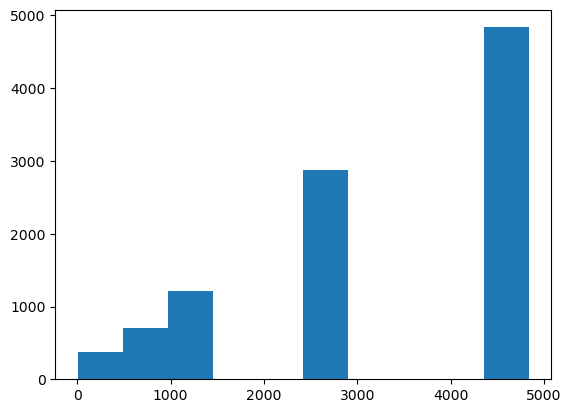

In [95]:
n_bins = 10

outlier_bin_edges = compute_bin_edges(score_train, num_bins=10 +1)
outlier_bins = get_bins_from_edges(score_train, outlier_bin_edges)

bin_sizes = []
for bin_ in outlier_bins:
    bin_sizes+=[bin_.size]*bin_.size
plt.hist(bin_sizes, bins=n_bins)

# Weighted pricing and re-sampling techniques

In [85]:

def get_uniform_bins(vector_range=(0,100), n_bins=10):
    # Distribution of each one
    y_min, y_max = vector_range
    # print("range: ", y_min, y_max)
    # B =  30#int((y_max - y_min)/330000)+1 # number of bins
    bins = np.linspace(y_min, y_max, n_bins+1)
    # print(f"{n_bins} bins: ")
    # print(bins)
    # lb = bins[0]
    return bins

def compute_bin_edges(data, num_bins):
    """
    Compute bin edges similar to matplotlib.pyplot.hist behavior.
    
    Parameters:
    - data: array-like, the input data
    - num_bins: int, the number of bins

    Returns:
    - bin_edges: ndarray of bin edges
    """
    data = np.asarray(data)

    if data.size == 0:
        raise ValueError("Input data must not be empty.")
    
    data_min, data_max = np.min(data), np.max(data)

    if data_min == data_max:
        # Create small range around the constant value
        data_min -= 0.5
        data_max += 0.5

    bin_edges = np.linspace(data_min, data_max, num_bins + 1)

    return bin_edges

def get_group_weights(vector, bins, alpha=1, weight_type="raw"):
    """
        Let the weights first be the size of each group for simplicity
        Let intervals be: [lb, ub)
    """
    weights = []
    lb = bins[0] # first lower bound
    i = 0
    for ub in bins[1:]:
        if i >= len(bins) -2: # one for python and one for extra bound (last interval)
            vector_group_ids = (lb <= vector) & (vector <= ub)
        else:
            vector_group_ids = (lb <= vector) & (vector < ub)
        group_size = np.sum(vector_group_ids)
        if group_size > 0:
            if weight_type == "raw": # Directly use the number of samples of the bin as weight
                weights+= [1/group_size**alpha]*group_size # inverse of size repeated the number of samples times
        i+=1
        lb = ub # update lb
    return weights


def get_bins_from_edges(vector, bin_edges):
    if type(vector) == pd.Series:
        vector = vector.to_numpy()
    bins = []
    lb = bin_edges[0]
    for i,ub in enumerate(bin_edges[1:]):
        vector_i = vector[(vector >= lb) & (vector < ub)]
        if vector_i.size == 0:
            print("No size in: ", i)
        bins.append(vector_i)
        lb = ub
    bins[i] =  np.concatenate((bins[i], vector[vector == ub]))
    return bins
        



In [131]:
# Re-weighted loss function

# import cvxpy as cp 

class ReWeightedLoss:
    def __init__(self, deviation_thresh= 1e3, groups_mean_delta=1e3, solver_parameters=None): #bins=[], blurred_hist=[], alpha=2):
        self.parameters = None
        self.solver_parameters = solver_parameters
        # self.delta = delta
        # self.bins = bins
        # self.blurred_hist = blurred_hist
        # self.alpha = alpha
        self.deviation_thresh = deviation_thresh
        self.groups_mean_delta = groups_mean_delta

    def fit(self, X, y, weights=None):
        X,y = X.to_numpy(), y.to_numpy()
        n,m = X.shape
        # y_quants = quantiles_price(y)
        # groups_intervals = np.linspace(0, 1, self.blurred_hist+1)
        # groups_dict = dict()

        # Need to fix:
        # bin_weights = bin_weights#[:-1]
        # bin_weights = 1/self.blurred_hist

        # Optimize
        # beta = cp.Variable(m)
        if weights:
            D = np.diag(weights)
        else:
            D = np.eye(n)
            
        print("D shape", D.shape)
        print("X shape", X.shape)
        print("y shape", y.shape)

        # print(X_train.shape)
        # print(beta.size)
        # print((X_train.to_numpy() @ beta).size )
        # print(y_train.size)
        # print(D.shape)
        # print(bin_weights.shape)

        # for i in range(10):
        #     print(X[i,:])
        #     print(y[i])
        

        constraints = []

        # 1. Deviation threshold 
        # constraints +=[
        #     X[i,:] @ beta / y[i] -1 <= self.deviation_thresh for i in range(n)
        # ]
        # constraints+=[
        #     X[i,:] @ beta / y[i] -1 >= -self.deviation_thresh for i in range(n)
        # ]
        
        # Vector format
#         constraints +=[
#             X @ beta / y -1 <= self.deviation_thresh
#         ]
#         constraints+=[
#             X @ beta / y -1 >= -self.deviation_thresh
#         ]




        # 2. Groups mean close to zero

        # y_quants = quantiles_price(y)
        # groups_dict = get_groups_from_quants(y, y_quants, n_groups=3)

        # print("groups dict: ", groups_dict)
        # for j in groups_dict:

        #     constraints+=[
        #             # (1/len(groups_dict[j])) * (cp.sum( [X[i,:] @ beta / y[i] -1 for i in  groups_dict[j]]  ))<= self.groups_mean_delta for j in groups_dict
        #             (1/len(groups_dict[j])) * (cp.sum( X[groups_dict[j],:] @ beta / y[groups_dict[j]] - 1  )) <= self.groups_mean_delta 
        #         ]
        #     constraints+=[
        #             # (1/len(groups_dict[j])) * (cp.sum( [X[i,:] @ beta / y[i] -1 for i in  groups_dict[j]]  ))>= -self.groups_mean_delta for j in groups_dict
        #             (1/len(groups_dict[j])) * (cp.sum( X[groups_dict[j],:] @ beta / y[groups_dict[j]] - 1  )) >= -self.groups_mean_delta 
        #         ]


        if len(constraints) > 0:
            socp = cp.Problem(
                cp.Minimize(
                        1/(2 * y.size) * cp.quad_form(X @ beta - y, D)
                    ),
                    constraints
                )
            socp.solve(
                solver="MOSEK",
                verbose=False,
                
                # self.solver_parameters
            )
            self.parameters = beta.value
        else:
            self.parameters = np.linalg.pinv(X.T @ D @ X) @ X.T @ D @ y



        # print("SOLVER SOL:")
        # print(self.parameters[:10])
        # print(type(X_train))
        # print(X_train.T @ D @ X_train)
        # closed_form_beta = np.linalg.inv(X_train.T @ D @ X_train) @ X_train.T @ D @ y_train 
        # print("Closed form solution:")
        # print(closed_form_beta[:10])

    def predict(self, X_test):
        # print(self.parameters)
        return X_test.to_numpy() @ self.parameters
    



In [75]:
len(y_train_bins)

1001

In [134]:
# Re-compute the weights to use in the loss function in terms of the representativity of each bin
n_bins = 800
y_train_bins = compute_bin_edges(y_train_sample, num_bins=n_bins) #get_uniform_bins(vector_range=(14000,501000), n_bins=100)
print(y_train_bins.shape[0])
y_train_weights = get_group_weights(y_train_sample, y_train_bins, alpha=9)
print(len(y_train_weights))


# raise("ALO")
# Model selection and fit
model = ReWeightedLoss(deviation_thresh=1, groups_mean_delta=1e3) #UpperBoundLossRegression(n_groups=5)# #ConstraintBothRegression(n_groups=5, delta=0.3, deviation_thresh=5)#ConstraintDeviationRegression(deviation_thresh=1)#LinearRegression()#ReWeightedLoss(deviation_thresh=1e3, groups_mean_delta=0.5)
# print(X_train_resampled.shape)
model.fit(X_train_sample, y_train_sample, weights=y_train_weights)
y_pred_train = model.predict(X_train_sample)
y_pred = model.predict(X_test_sample)

# ratio
r_pred = y_pred / y_test_sample
r_pred_train = y_pred_train / y_train_sample


801
10000
D shape (10000, 10000)
X shape (10000, 2927)
y shape (10000,)


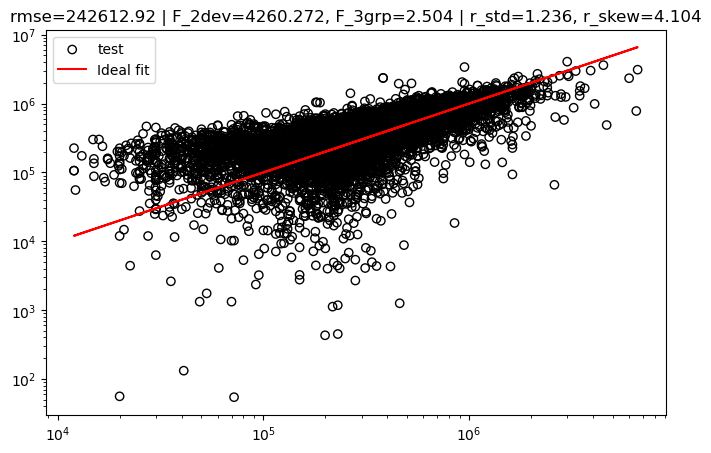

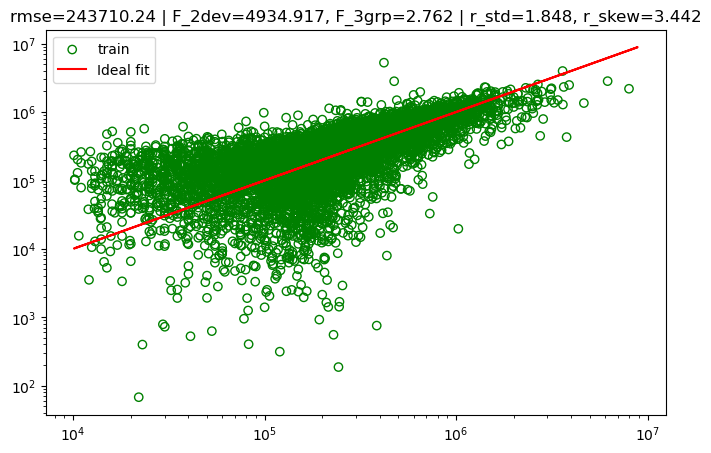

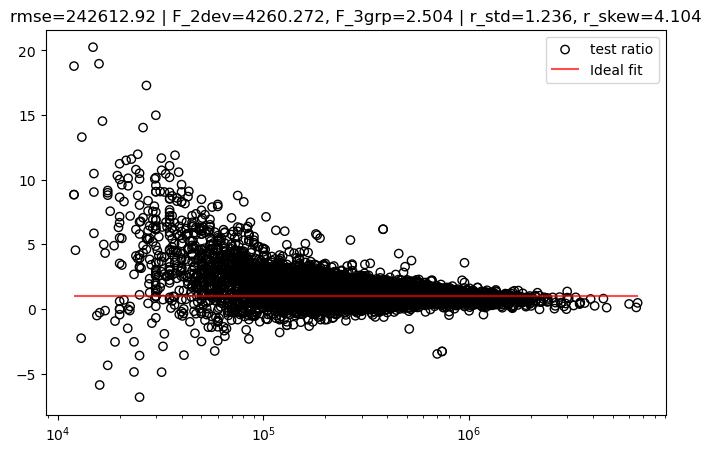

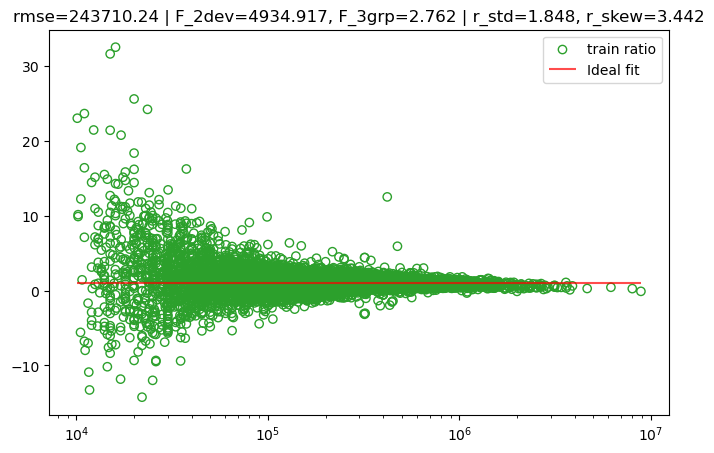

In [135]:


n_groups = 3
alpha = 2
f_metrics = compute_haihao_F_metrics(r_pred, y_test_sample, n_groups=n_groups, alpha=alpha)
f_dev, f_grp = f_metrics["f_dev"], f_metrics["f_grp"]

f_metrics_train = compute_haihao_F_metrics(r_pred_train, y_train_sample, n_groups=n_groups)
f_dev_train, f_grp_train = f_metrics_train["f_dev"], f_metrics_train["f_grp"]


# Plots general setting
log_scale = True

# Plot real data v/s predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test_sample,y_pred, facecolor='none', label="test", color="black")
plt.plot(y_test_sample, y_test_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred):.3f}
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()



plt.figure(figsize=(8,5))
plt.scatter(y_train_sample,y_pred_train, facecolor='none', label="train", color="green")
plt.plot(y_train_sample, y_train_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred_train):.3f}, 
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()

# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_test_sample,r_pred, facecolor='none', label="test ratio", color="black")
plt.hlines(1, np.min(y_test_sample), np.max(y_test_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()


# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_train_sample, r_pred_train, facecolor='none', label="train ratio", color="C2")
plt.hlines(1, np.min(y_train_sample), np.max(y_train_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()

### 2) Re-sampling

In [105]:
from sklearn.neighbors import NearestNeighbors
## ONLY FOR ISOLATION
from sklearn.ensemble import IsolationForest


# # Loop the bins
# lb = y_train_bins[0]
# for ub in y_train_bins[1:]:
#     y_bin = y_train_sample.loc[(y_train_sample >= lb) & (y_train_sample < ub)]
#     y_pred_bin = y_pred_train[(y_train_sample >= lb) & (y_train_sample < ub)]
#     X_bin = X_train_sample.loc[y_bin.index,:]

#     if y_bin.size >= 100:

#         # ── 2. Fit the Isolation Forest on training features
#         iso = IsolationForest(
#             n_estimators=100,
#             contamination='auto',  # or a float like 0.05 if you know the expected outlier fraction
#             # behaviour='new',       # for newest scikit‑learn versions; remove if deprecated
#             random_state=42
#         )
#         iso.fit(X_bin)

#         # ── 3. Compute outlier scores
#         # decision_function returns higher = more “inlier”-like, so we invert it:
#         score_train = -iso.decision_function(X_bin)
#         # score_test  = -iso.decision_function(X_test)

#         # ── 4. Combine train and test for a single scatter (optional)
#         # y_true_all = np.concatenate([y_train, y_test])
#         # y_pred_all = np.concatenate([y_pred_train, y_pred_test])
#         # score_all  = np.concatenate([score_train, score_test])

#         # ── 5. Plot true vs. predicted with colorbar for outlier score
#         plt.figure(figsize=(5,4))
#         sc = plt.scatter(
#             y_bin, 
#             y_pred_bin, 
#             c=score_train, 
#             cmap='viridis', 
#             s=40,        # marker size
#             alpha=0.5    # slight transparency
#         )
#         plt.plot([y_bin.min(), y_bin.max()],
#                  [y_bin.min(), y_bin.max()],
#                  'k--', lw=1)  # 45° line
#         plt.xlabel('True Values')
#         plt.ylabel('Predicted Values')
#         cbar = plt.colorbar(sc)
#         cbar.set_label('IsolationForest Outlier Score\n(higher = more anomalous)')
#         plt.title('True vs. Predicted with Outlier Scoring')
#         plt.tight_layout()
#         plt.show()
                           
#     # update bound
#     lb = ub


class SMOTERegressor:
    def __init__(self, bin_edges, k_neighbors=5, metric="minkowski", p=2, metric_params=None, random_state=None, bin_size_ratio=0.5, undersampling_policy="random"):
        self.bin_edges = np.array(bin_edges)
        self.k_neighbors = k_neighbors
        self.metric = metric
        self.p = p 
        self.metric_params = metric_params
        self.random_state = np.random.RandomState(random_state)
        self.bin_size_ratio = bin_size_ratio# r: ratio of (max-min) to add to each bin (or to cut in larger bins)
        self.undersampling_policy = undersampling_policy # either delete random samples or by outlier score in the bin
    
    def _assign_bins(self, y):
        return np.digitize(y, self.bin_edges, right=False) - 1

    def _compute_bin_counts(self, y_bins):
        bin_counts = np.bincount(y_bins, minlength=len(self.bin_edges) - 1)
        return bin_counts

    def _generate_samples(self, X_bin, y_bin, n_samples):
        if len(X_bin) <= 1:
            return X_bin, y_bin  # Can't interpolate

        nn = NearestNeighbors(n_neighbors=min(self.k_neighbors, len(X_bin)), metric=self.metric, p=self.p, metric_params=self.metric_params)
        nn.fit(X_bin)
        indices = self.random_state.randint(0, len(X_bin), size=n_samples)

        X_synthetic = []
        y_synthetic = []

        for idx in indices:
            x_i = X_bin[idx]
            y_i = y_bin[idx]

            neighbors = nn.kneighbors([x_i], return_distance=False)[0]
            neighbor_idx = self.random_state.choice(neighbors[neighbors != idx])

            x_n = X_bin[neighbor_idx]
            y_n = y_bin[neighbor_idx]

            alpha = self.random_state.rand()
            x_new = x_i + alpha * (x_n - x_i)
            y_new = y_i + alpha * (y_n - y_i)

            X_synthetic.append(x_new)
            y_synthetic.append(y_new)

        return np.array(X_synthetic), np.array(y_synthetic)
    
    def _under_samples(self, X_bin, y_bin, n_samples):
        
        if self.undersampling_policy == "random":
            # Choose n_samples random observations
            synthetic_indices = np.random.choice(range(y_bin.size), size=n_samples, replace=False)

        elif self.undersampling_policy == "outlier_score":
            # Choose the n_samples obs with higher inlier score
            iso = IsolationForest(
                n_estimators=100,
                contamination='auto',  # or a float like 0.05 if you know the expected outlier fraction
                random_state=42
            )
            iso.fit(X_bin)
            inlier_score = iso.decision_function(X_bin)
            synthetic_indices = np.argsort(inlier_score)[-n_samples:]
            
        X_synthetic = X_bin[synthetic_indices,:]
        y_synthetic = y_bin[synthetic_indices]
        
        return X_synthetic, y_synthetic
        

    def fit_resample(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        
        y_bins = self._assign_bins(y)
        bin_counts = self._compute_bin_counts(y_bins)
        max_count = max(bin_counts)
        min_count = min(bin_counts[bin_counts>0])
        objective_bin_size = min_count + int( (max_count - min_count) * self.bin_size_ratio )
        print("objective_bin_size", objective_bin_size)

        X_resampled = [X]
        y_resampled = [y]

        for bin_idx in range(len(bin_counts)):
            count = bin_counts[bin_idx]
            print("Bin: ", bin_idx, " | bin count: ", count) 
            # if count == 0 or count == max_count:
            if count < self.k_neighbors or count == max_count:
                print("skipped")
                continue  # skip (almost) empty or already balanced bins
            
            # Filter bin's datapoints
            mask = y_bins == bin_idx
            X_bin = X[mask]
            y_bin = y[mask]
            
            
            # Check if it is larger (under-sample) or smaller (over-sample) than the desired size
            if count > objective_bin_size:
                n_to_sample = objective_bin_size
                X_synth, y_synth = self._under_samples(X_bin, y_bin, n_to_sample)
                print("Undersampled to: ", y_synth.size)
                
            else:
                n_to_sample = objective_bin_size
                X_synth, y_synth = self._generate_samples(X_bin, y_bin, n_to_sample)
                print("Oversampled to: ", y_synth.size)

            X_resampled.append(X_synth)
            y_resampled.append(y_synth)

        return np.vstack(X_resampled), np.concatenate(y_resampled)


In [106]:


# Re-compute the weights to use in the loss function in terms of the representativity of each bin
n_bins = 1000
y_train_bins = compute_bin_edges(y_train_sample, num_bins=n_bins) #get_uniform_bins(vector_range=(14000,501000), n_bins=100)
# print(y_train_bins.shape[0])
y_train_weights = get_group_weights(y_train_sample, y_train_bins, alpha=5)
# print(len(y_train_weights))


# Resampler
# metric_params={"VI":np.linalg.pinv(X_train_sample.cov())}
csmote = SMOTERegressor(bin_edges=y_train_bins, k_neighbors=3, metric="minkowski", p=2, random_state=45, bin_size_ratio=0.5, undersampling_policy="random")  # New one
X_train_resampled, y_train_resampled = csmote.fit_resample(X_train_sample, y_train_sample)


# raise("ALO")
# Model selection and fit
model = LinearRegression()#ReWeightedLoss(deviation_thresh=1, groups_mean_delta=1e3) #UpperBoundLossRegression(n_groups=5)# #ConstraintBothRegression(n_groups=5, delta=0.3, deviation_thresh=5)#ConstraintDeviationRegression(deviation_thresh=1)#LinearRegression()#ReWeightedLoss(deviation_thresh=1e3, groups_mean_delta=0.5)
# print(X_train_resampled.shape)
model.fit(X_train_resampled, y_train_resampled)
y_pred_train = model.predict(X_train_sample)
y_pred = model.predict(X_test_sample)

# ratio
r_pred = y_pred / y_test_sample
r_pred_train = y_pred_train / y_train_sample


[158 230 250 ...   0   0   1]
(1001,)


TypeError: exceptions must derive from BaseException

In [ ]:


n_groups = 3
alpha = 2
f_metrics = compute_haihao_F_metrics(r_pred, y_test_sample, n_groups=n_groups, alpha=alpha)
f_dev, f_grp = f_metrics["f_dev"], f_metrics["f_grp"]

f_metrics_train = compute_haihao_F_metrics(r_pred_train, y_train_sample, n_groups=n_groups)
f_dev_train, f_grp_train = f_metrics_train["f_dev"], f_metrics_train["f_grp"]


# Plots general setting
log_scale = True

# Plot real data v/s predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test_sample,y_pred, facecolor='none', label="test", color="black")
plt.plot(y_test_sample, y_test_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred):.3f}
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()



plt.figure(figsize=(8,5))
plt.scatter(y_train_sample,y_pred_train, facecolor='none', label="train", color="green")
plt.plot(y_train_sample, y_train_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred_train):.3f}, 
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()

# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_test_sample,r_pred, facecolor='none', label="test ratio", color="black")
plt.hlines(1, np.min(y_test_sample), np.max(y_test_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()


# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_train_sample, r_pred_train, facecolor='none', label="train ratio", color="C2")
plt.hlines(1, np.min(y_train_sample), np.max(y_train_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()

# Outlier score re-sampling

In [128]:

class OutlierSmoteResampler:
    def __init__(self, bin_indices, k_neighbors=5, metric="minkowski", p=2, metric_params=None, random_state=None, bin_size_ratio=0.5, undersampling_policy="random"):
        self.bin_indices = bin_indices
        self.k_neighbors = k_neighbors
        self.metric = metric
        self.p = p 
        self.metric_params = metric_params
        self.random_state = np.random.RandomState(random_state)
        self.bin_size_ratio = bin_size_ratio# r: ratio of (max-min) to add to each bin (or to cut in larger bins)
        self.undersampling_policy = undersampling_policy # either delete random samples or by outlier score in the bin
    
    def _assign_bins(self, y):
        y_bins = np.zeros(y.size)
        for i, bin_indices_i in enumerate(self.bin_indices):
            y_bins[bin_indices_i] = i
        return y_bins #np.digitize(y, self.bin_edges, right=False) - 1

    def _compute_bin_counts(self, y_bins):
        bin_counts = []
        for i, bin_indices_i in enumerate(self.bin_indices):
            bin_counts.append(bin_indices_i.size)
        # bin_counts =  #np.bincount(y_bins, minlength=len(self.bin_edges) - 1)
        return np.array(bin_counts)

    def _generate_samples(self, X_bin, y_bin, n_samples):
        if len(X_bin) <= 1:
            return X_bin, y_bin  # Can't interpolate

        nn = NearestNeighbors(n_neighbors=min(self.k_neighbors, len(X_bin)), metric=self.metric, p=self.p, metric_params=self.metric_params)
        nn.fit(X_bin)
        indices = self.random_state.randint(0, len(X_bin), size=n_samples)

        X_synthetic = []
        y_synthetic = []

        for idx in indices:
            x_i = X_bin[idx]
            y_i = y_bin[idx]

            neighbors = nn.kneighbors([x_i], return_distance=False)[0]
            neighbor_idx = self.random_state.choice(neighbors[neighbors != idx])

            x_n = X_bin[neighbor_idx]
            y_n = y_bin[neighbor_idx]

            alpha = self.random_state.rand()
            x_new = x_i + alpha * (x_n - x_i)
            y_new = y_i + alpha * (y_n - y_i)

            X_synthetic.append(x_new)
            y_synthetic.append(y_new)

        return np.array(X_synthetic), np.array(y_synthetic)
    
    def _under_samples(self, X_bin, y_bin, n_samples):
        
        if self.undersampling_policy == "random":
            # Choose n_samples random observations
            synthetic_indices = np.random.choice(range(y_bin.size), size=n_samples, replace=False)

        elif self.undersampling_policy == "outlier_score":
            # Choose the n_samples obs with higher inlier score
            iso = IsolationForest(
                n_estimators=100,
                contamination='auto',  # or a float like 0.05 if you know the expected outlier fraction
                random_state=42
            )
            iso.fit(X_bin)
            inlier_score = iso.decision_function(X_bin)
            synthetic_indices = np.argsort(inlier_score)[-n_samples:]
            
        X_synthetic = X_bin[synthetic_indices,:]
        y_synthetic = y_bin[synthetic_indices]
        
        return X_synthetic, y_synthetic
        

    def fit_resample(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        
        y_bins = self._assign_bins(y)
        bin_counts = self._compute_bin_counts(y_bins)
        max_count = max(bin_counts)
        min_count = min(bin_counts[bin_counts>0])
        objective_bin_size = min_count + int( (max_count - min_count) * self.bin_size_ratio )
        print("objective_bin_size", objective_bin_size)

        X_resampled = [X]
        y_resampled = [y]

        for bin_idx in range(len(bin_counts)):
            count = bin_counts[bin_idx]
            print("Bin: ", bin_idx, " | bin count: ", count) 
            # if count == 0 or count == max_count:
            if count < min(self.k_neighbors, 5) or count == max_count:
                print("skipped")
                continue  # skip (almost) empty or already balanced bins
            
            # Filter bin's datapoints
            mask = y_bins == bin_idx
            X_bin = X[mask]
            y_bin = y[mask]
            
            
            # Check if it is larger (under-sample) or smaller (over-sample) than the desired size
            if count > objective_bin_size:
                n_to_sample = objective_bin_size
                X_synth, y_synth = self._under_samples(X_bin, y_bin, n_to_sample)
                print("Undersampled to: ", y_synth.size)
                
            else:
                n_to_sample = objective_bin_size
                X_synth, y_synth = self._generate_samples(X_bin, y_bin, n_to_sample)
                print("Oversampled to: ", y_synth.size)

            X_resampled.append(X_synth)
            y_resampled.append(y_synth)

        return np.vstack(X_resampled), np.concatenate(y_resampled)


In [129]:
def get_bin_indices_from_edges(vector, bin_edges):
    if type(vector) == pd.Series:
        vector = vector.to_numpy()
    bins = list()
    lb = bin_edges[0]
    for i,ub in enumerate(bin_edges[1:]):
        bin_indices = np.where((vector >= lb) & (vector < ub))[0]
        # if vector_i.size == 0:
            # print("No size in: ", i)
        bins.append(bin_indices)
        lb = ub
    bins[i] =  np.concatenate((bins[i], np.where(vector == ub)[0]))
    return bins


    

n_bins = 10

outlier_bin_edges = compute_bin_edges(score_train, num_bins=n_bins +1)
outlier_bin_indices = get_bin_indices_from_edges(score_train, outlier_bin_edges)
outlier_bin_indices

# Resampler
# metric_params={"VI":np.linalg.pinv(X_train_sample.cov())}
csmote = OutlierSmoteResampler(bin_indices=outlier_bin_indices, k_neighbors=10, metric="minkowski", p=2, random_state=45, bin_size_ratio=0.05, undersampling_policy="random")  # New one
X_train_resampled, y_train_resampled = csmote.fit_resample(X_train_sample, y_train_sample)


# raise("ALO")
# Model selection and fit
model = LinearRegression()#ReWeightedLoss(deviation_thresh=1, groups_mean_delta=1e3) #UpperBoundLossRegression(n_groups=5)# #ConstraintBothRegression(n_groups=5, delta=0.3, deviation_thresh=5)#ConstraintDeviationRegression(deviation_thresh=1)#LinearRegression()#ReWeightedLoss(deviation_thresh=1e3, groups_mean_delta=0.5)
# print(X_train_resampled.shape)
model.fit(X_train_resampled, y_train_resampled)
y_pred_train = model.predict(X_train_sample)
y_pred = model.predict(X_test_sample)

# ratio
r_pred = y_pred / y_test_sample
r_pred_train = y_pred_train / y_train_sample

objective_bin_size 246
Bin:  0  | bin count:  1210
Undersampled to:  246
Bin:  1  | bin count:  4837
skipped
Bin:  2  | bin count:  2875
Undersampled to:  246
Bin:  3  | bin count:  710
Undersampled to:  246
Bin:  4  | bin count:  213
Oversampled to:  246
Bin:  5  | bin count:  64
Oversampled to:  246
Bin:  6  | bin count:  52
Oversampled to:  246
Bin:  7  | bin count:  15
Oversampled to:  246
Bin:  8  | bin count:  8
Oversampled to:  246
Bin:  9  | bin count:  11
Oversampled to:  246
Bin:  10  | bin count:  5
Oversampled to:  246


/home/nacevedo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/nacevedo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


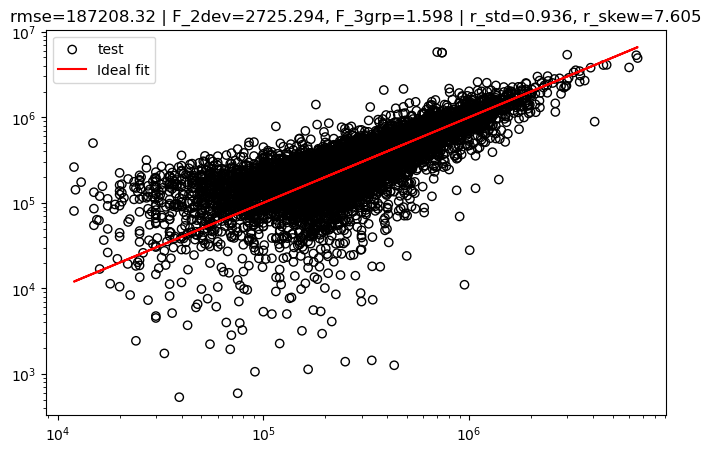

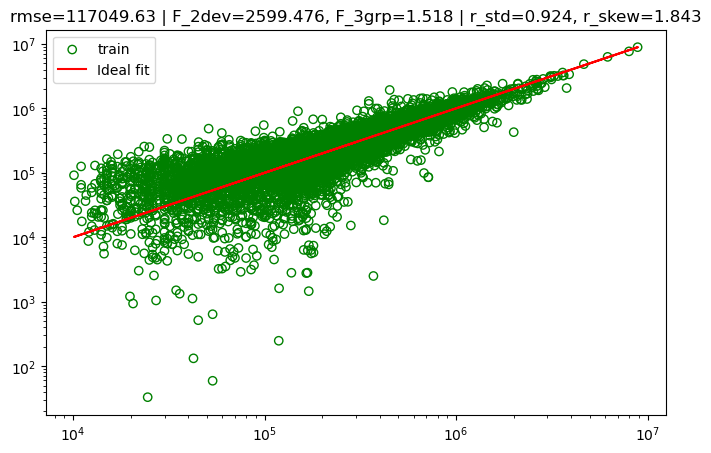

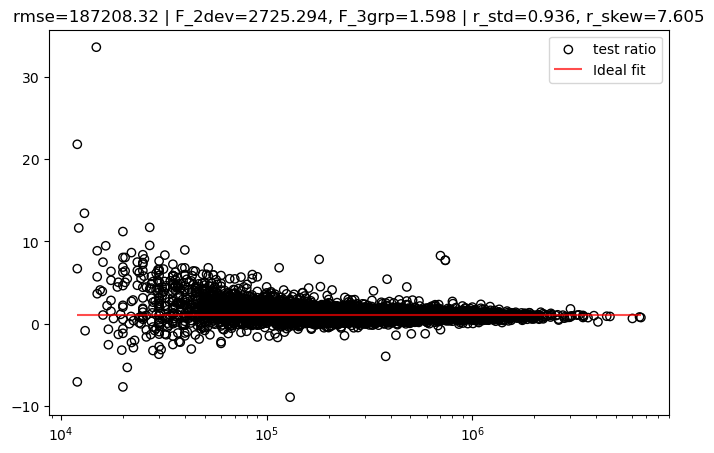

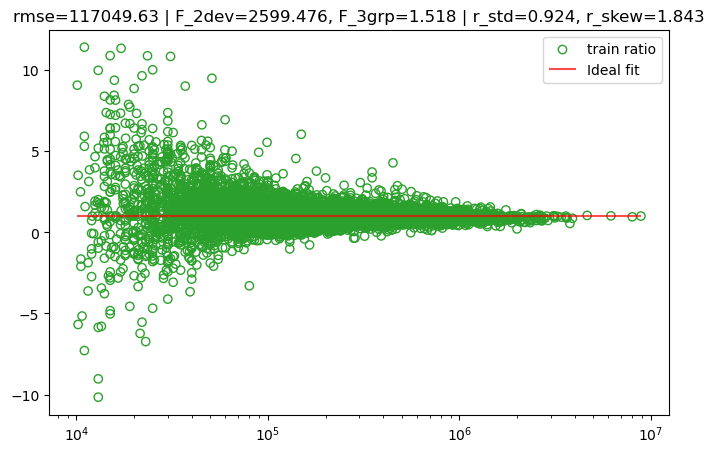

In [130]:


n_groups = 3
alpha = 2
f_metrics = compute_haihao_F_metrics(r_pred, y_test_sample, n_groups=n_groups, alpha=alpha)
f_dev, f_grp = f_metrics["f_dev"], f_metrics["f_grp"]

f_metrics_train = compute_haihao_F_metrics(r_pred_train, y_train_sample, n_groups=n_groups)
f_dev_train, f_grp_train = f_metrics_train["f_dev"], f_metrics_train["f_grp"]


# Plots general setting
log_scale = True

# Plot real data v/s predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test_sample,y_pred, facecolor='none', label="test", color="black")
plt.plot(y_test_sample, y_test_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred):.3f}
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()



plt.figure(figsize=(8,5))
plt.scatter(y_train_sample,y_pred_train, facecolor='none', label="train", color="green")
plt.plot(y_train_sample, y_train_sample, color="red", label="Ideal fit")
plt.legend() # mn_dev={mean_deviation(r_pred_train):.3f}, 
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    plt.yscale("log")
plt.show()

# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_test_sample,r_pred, facecolor='none', label="test ratio", color="black")
plt.hlines(1, np.min(y_test_sample), np.max(y_test_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred - y_test_sample)**2)):.2f} | F_{alpha}dev={f_dev:.3f}, F_{n_groups}grp={f_grp:.3f} | r_std={np.std(r_pred):.3f}, r_skew={skew(r_pred):.3f}")#, kt={kurtosis(r_pred):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()


# ratio v/s price
plt.figure(figsize=(8,5))
# plt.plot(y_train, y_pred_train, 'o', label="train")
plt.scatter(y_train_sample, r_pred_train, facecolor='none', label="train ratio", color="C2")
plt.hlines(1, np.min(y_train_sample), np.max(y_train_sample), alpha=0.7, colors="red", label="Ideal fit")
plt.legend()
plt.title(f"rmse={np.sqrt(np.mean((y_pred_train - y_train_sample)**2)):.2f} | F_{alpha}dev={f_dev_train:.3f}, F_{n_groups}grp={f_grp_train:.3f} | r_std={np.std(r_pred_train):.3f}, r_skew={skew(r_pred_train):.3f}")#, , kt={kurtosis(r_pred_train):.3f}")
if log_scale:
    plt.xscale("log")
    # plt.yscale("log")
plt.show()